**https://ods.ai/competitions/mtsmlcup**

Первое соревнование от МТС Digital Big Data по определению пола/возраста владельца cookie 

In [2]:
import os
import re
import gc
import pandas as pd
import numpy as np
import time

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.feather as ft
import pyarrow.compute as pc
import bisect

from time import time, sleep
from pathlib import Path
from glob import glob
from IPython.display import display, FileLink

__import__('warnings').filterwarnings("ignore")

import scipy
import implicit

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
!pip install --user faiss-cpu --no-cache

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 145.9 MB/s eta 0:00:00a 0:00:01


In [12]:
!pip install --user faiss-gpu --no-cache

In [5]:
!pip install --user feather-format

In [6]:
LOCAL_DATA_PATH = './kaggle/input/mts-ml-cookies'
MY_DATA_PATH = Path('/kaggle/input/mtsmlcup-preprocess-data')
TRAIN_PATH = Path('/kaggle/input/mtsmlcup-train-test')
WORK_PATH = Path('.')
SPLIT_SEED = 2023
DATA_FILE = 'dataset_full.feather'
TARGET_FILE = 'target_train.feather'
SUBMISSION_FILE = 'submission.feather'

In [7]:
def memory_compression(df, use_category=True, use_float=True):
    """
    Изменение типов данных для экономии памяти
    :param df_in: исходный ДФ
    :param use_category: преобразовывать строки в категорию
    :return: сжатый ДФ
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        if str(df[col].dtype) not in ('object', 'category'):
            col_min = df[col].min()
            col_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and \
                        col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and \
                        col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and \
                        col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and \
                        col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif use_float and str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float16).min and \
                        col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and \
                        col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif use_category:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f'Исходный размер датасета в памяти '
          f'равен {round(start_mem, 2)} мб.')
    print(f'Конечный размер датасета в памяти '
          f'равен {round(end_mem, 2)} мб.')
    print(f'Экономия памяти = {(1 - end_mem / start_mem):.1%}')
    return df


def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)


def convert_seconds(time_apply):
    # print(type(time_apply), time_apply)
    try:
        time_apply = float(time_apply)
    except ValueError:
        time_apply = 0
    if isinstance(time_apply, (int, float)):
        hrs = time_apply // 3600
        mns = time_apply % 3600
        sec = mns % 60
        time_string = ''
        if hrs:
            time_string = f'{hrs:.0f} час '
        if mns // 60 or hrs:
            time_string += f'{mns // 60:.0f} мин '
        return f'{time_string}{sec:.1f} сек'


def print_time(time_start):
    """
    Печать времени выполнения процесса
    :param time_start: время запуска в формате time.time()
    :return:
    """
    time_apply = time() - time_start
    print(f'Время обработки: {convert_seconds(time_apply)}')


def print_msg(msg):
    print(msg)
    return time()


file_urls = WORK_PATH.joinpath('file_urls.feather')
file_users = WORK_PATH.joinpath('file_users.feather')

file_preprocess_0 = WORK_PATH.joinpath('data_set_preprocess_0.feather')
file_preprocess_1 = WORK_PATH.joinpath('data_set_preprocess_1.feather')
file_preprocess_2 = WORK_PATH.joinpath('data_set_preprocess_2.feather')
file_preprocess_3 = WORK_PATH.joinpath('data_set_preprocess_3.feather')
file_preprocess_4 = WORK_PATH.joinpath('data_set_preprocess_4.feather')
file_preprocess_5 = WORK_PATH.joinpath('data_set_preprocess_5.feather')

file_user_cpe = WORK_PATH.joinpath('file_user_cpe.feather')
file_cpe_models = WORK_PATH.joinpath('file_cpe_models.feather')
file_user_city_cpe = WORK_PATH.joinpath('file_user_city_cpe.feather')

file_url_male = WORK_PATH.joinpath('file_url_male.feather')
file_url_age = WORK_PATH.joinpath('file_url_age.feather')

file_train_pre = WORK_PATH.joinpath('file_train_pre.feather')
file_train_df = WORK_PATH.joinpath('file_train_df.feather')
file_test_df = WORK_PATH.joinpath('file_test_df.feather')
file_merge_train = WORK_PATH.joinpath('file_merge_train.feather')
file_merge_test = WORK_PATH.joinpath('file_merge_test.feather')
df_train_users = WORK_PATH.joinpath('train_users.feather')
df_test_users = WORK_PATH.joinpath('test_users.feather')

In [4]:
# ( Класс 1 —19-25, Класс 2 —26-35, Класс 3 —36-45, Класс 4 —46-55, Класс 5 —56-65, Класс 6— 66+)
ages = [18,19,24,25,26,34,35,36,44,45,46,54,55,56,64,65,66,67]
for age in ages:
    print(f'{age} --> {age_bucket(age)}')

18 --> 0
19 --> 1
24 --> 1
25 --> 1
26 --> 2
34 --> 2
35 --> 2
36 --> 3
44 --> 3
45 --> 3
46 --> 4
54 --> 4
55 --> 4
56 --> 5
64 --> 5
65 --> 5
66 --> 6
67 --> 6


In [8]:
%%time

# # тут отфильтровать только нужные user_id
# targets = pd.read_feather('/kaggle/input/mts-ml-cookies/target_train.feather')
# targets.age = pd.to_numeric(targets.age, errors='coerce')
# # уберем лиц младше 19 лет
# targets.dropna(inplace=True)
# targets.age = targets.age.astype(int)
# targets = targets[targets.age > 18]
# # уберем бесполых лиц
# targets.is_male = pd.to_numeric(targets.is_male, errors='coerce')
# targets.dropna(inplace=True)
# targets.is_male = targets.is_male.astype(int)
# targets.age = targets.age.map(age_bucket)
# targets = memory_compression(targets)

# targets.reset_index(drop=True).to_feather(file_users)
# targets.to_csv(file_users.with_suffix('.csv'), index=False)

targets = pd.read_feather(file_users)
targets.head()

FileNotFoundError: [Errno 2] No such file or directory: 'file_users.feather'

In [ ]:
data = pd.DataFrame()

In [ ]:
%%time
if not file_preprocess_1.is_file() and not file_preprocess_2.is_file():
    if file_preprocess_0.is_file():
        if not file_preprocess_1.is_file():
            data = pd.read_feather(file_preprocess_0)
            data.head()
    else:
        data = pd.read_feather('/kaggle/input/mts-ml-cookies/dataset_full.feather')

        # удаление неинформативных колонок
        data.drop(['cpe_type_cd', 'cpe_model_os_type'], axis=1, inplace=True)

        users = pd.read_feather('/kaggle/input/mts-ml-cookies/submission.feather')
        users = set(users.user_id.to_list()) | set(targets.user_id.to_list())
        users_to_remove = set(data.user_id.unique()) - users
        print('Количество удаленных пользователей =', len(users_to_remove))

        data.drop(data[data.user_id.isin(users_to_remove)].index, inplace=True)
        users = users_to_remove = None

        data.reset_index(drop=True).to_feather(file_preprocess_0)
        data.head()    

In [ ]:
def make_url_hosts():
    url_hosts = pd.DataFrame(data.url_host.unique(), columns=['url_host'])
    url_hosts.sort_values('url_host', inplace=True, ignore_index=True)
    url_hosts['url_id'] = url_hosts.index
    url_hosts.reset_index(drop=True).to_feather(file_urls)
    url_hosts.to_csv(file_urls.with_suffix('.csv'), index=False)
    print(url_hosts.info())
    url_hosts = dict(url_hosts.to_dict(orient='split')['data'])
    return url_hosts


def make_region_city():
    cities = data[['region_name', 'city_name']].drop_duplicates()
    cities.sort_values(['city_name', 'region_name'], inplace=True, ignore_index=True)
    cities['city_id'] = cities.index

    regions = pd.DataFrame(cities['region_name'].drop_duplicates(), columns=['region_name'])
    regions.sort_values('region_name', inplace=True, ignore_index=True)
    regions['region_id'] = regions.index
    cities = cities.merge(regions, on='region_name', how='left')

    cities['region_city'] = cities.region_id.astype(str) + '|' + cities.city_name.astype(str)

    cities.to_csv('cities.csv', index=False)
    print(cities.info())

    regions = dict(regions.to_dict(orient='split')['data'])
    cities = dict(cities[['region_city', 'city_id']].to_dict(orient='split')['data'])
    return regions, cities

In [ ]:
%%time
if file_preprocess_1.is_file():
    if not file_cpe_models.is_file() or not file_preprocess_2.is_file() :
        print(f'Читаю файл {file_preprocess_1}')
        data = pd.read_feather(file_preprocess_1)
        print(data.info())
elif not file_preprocess_4.is_file():
    print('Замена url_host на индексы...')
    # получение индексов для url_host
    url_hosts = make_url_hosts()
    # замена url_host на индексы
    data.url_host = data.url_host.map(url_hosts)
    url_hosts = None
    data.url_host = data.url_host.astype(np.int32)
    data.url_host = data.url_host.astype('category')

    print(f'Сохраняю файл {file_preprocess_1}')
    # сохраним файл с замененой колонками url_host
    data.reset_index(drop=True).to_feather(file_preprocess_1)
    gc.collect()
    sleep(2)

    print(data.info())

if not file_cpe_models.is_file():
    print('Преобразование в формат pyarrow')
    data = pa.Table.from_pandas(data)

    print('Группировки по моделям устройств...')
    # получение модели устройства, с которого пользователь выходит в инет
    cpe = data.select(['user_id', 'cpe_manufacturer_name', 'cpe_model_name']).\
        group_by(['user_id', 'cpe_manufacturer_name', 'cpe_model_name']).\
        aggregate([('cpe_model_name', "count")]).to_pandas()


    # получение списка устройств
    cols = ['cpe_manufacturer_name', 'cpe_model_name']
    cpe_models = cpe[cols].drop_duplicates()
    cpe_models.sort_values(cols, inplace=True, ignore_index=True)
    cpe_models['cpe_id'] = cpe_models.index
    manufacturer = cpe_models[['cpe_manufacturer_name']].drop_duplicates()
    manufacturer.sort_values('cpe_manufacturer_name', inplace=True, ignore_index=True)
    manufacturer['firm_id'] = manufacturer.index
    cpe_models = cpe_models.merge(manufacturer, on='cpe_manufacturer_name', how='left')

    # получение стоимости устройств
    data_agg = data.select(['cpe_manufacturer_name', 'cpe_model_name', 'price']).\
        group_by(['cpe_manufacturer_name', 'cpe_model_name']).\
        aggregate([('price', "mean")]).to_pandas()


    cpe_models = cpe_models.merge(data_agg, on=['cpe_manufacturer_name', 'cpe_model_name'], how='left')

    cpe.reset_index(drop=True).to_feather(file_user_cpe)
    cpe_models.reset_index(drop=True).to_feather(file_cpe_models)
    
    print(cpe.head())
    print(cpe_models.head())

    if not file_preprocess_2.is_file():
        data = data.to_pandas()

In [ ]:
# data[data.user_id.isin(targets.user_id)].user_id.nunique()

In [ ]:
%%time

if file_preprocess_2.is_file():
    if not file_preprocess_4.is_file():
        print(f'Читаю файл {file_preprocess_2}')
        data = pd.read_feather(file_preprocess_2)
else:
    print('Замена region_name и city_name на индексы...')
    
    # удаляю из-за нехватки памяти
    if 'cpe_manufacturer_name' in data.columns:
        data.drop(['cpe_manufacturer_name', 'cpe_model_name', 'price'], axis=1, inplace=True)
    
    # получение индексов для region_name, city_name
    regions, cities = make_region_city()
    
    chunk_size = 20_000_000
    num_chunks = len(data) // chunk_size
    if len(data) % chunk_size:
        num_chunks += 1
    total = 0    
    for n in range(num_chunks):
        temp = data[n * chunk_size:(n + 1) * chunk_size]
        size = len(temp.index)
        total += size
        print(f'Обрабатываю {n + 1:02} часть, размер {size:_}, всего: {total:_}')
        # замена region_name, city_name на индексы
        temp.region_name = temp.region_name.map(regions)
        temp.city_name = temp.region_name.astype(str) + '|' + temp.city_name.astype(str)
        temp.city_name = temp.city_name.map(cities)
        temp.city_name = temp.city_name.astype(np.int32)
        temp.city_name = temp.city_name.astype('category')
        temp.to_pickle(f'step2_part{n:02}.pkl')

    data = temp = regions = cities = None
    gc.collect()
    
    print('Объединение файлов step2_part*.pkl')
    # объединение обработанных файлов в один ДФ
    name_files = sorted(glob('step2_part*.pkl'))
    data = pd.concat(pd.read_pickle(name_file) for name_file in name_files)
    data.city_name = data.city_name.astype(np.int32)
    data.city_name = data.city_name.astype('category')
    print(data.info())
    
    # удаление временных файлов
    for name_file in name_files:
        Path(name_file).unlink()
    
    # сохраним файл с замененой колонками region_name, city_name на индексы
    print(f'Сохрание объединенного ДФ {file_preprocess_2}')
    data.reset_index(drop=True).to_feather(file_preprocess_2)
    
    file_preprocess_0.unlink()
    file_preprocess_1.unlink()
    
gc.collect()

In [ ]:
# data[data.user_id.isin(targets.user_id)].user_id.nunique(), data.user_id.nunique()

In [ ]:
# data.columns

, Регион   
, населенный пункт   
, производиель устройства   
, модель устроства   
, домен, с которого пришел рекламный запрос   
, тип устройства (смартфон или что-то другое)   
, операционка на устройстве   
, оценка цены устройства   
, дата   
, время дня (утро, вечер ...)   
, число запросов   
, id пользователя   

In [ ]:
%%time

if not file_user_city_cpe.is_file():

    # преобразование в формат pyarrow
    data = pa.Table.from_pandas(data)

    # статистика по пользователям
    user_stats = data.select(['user_id', 'url_host', 'date','city_name', 'region_name']). \
        group_by(['user_id']).aggregate([('url_host', "count_distinct"),
                                         ('city_name', "count_distinct"),
                                         ('region_name', "count_distinct"),
                                         ('date', "count_distinct")
                                         ]).to_pandas()

    # получение списка городов
    data_agg = data.select(['user_id', 'region_name', 'city_name', 'date', 'request_cnt']).\
        group_by(['user_id', 'region_name', 'city_name']).\
        aggregate([('city_name', "count"),('request_cnt', "sum"), ('date', "count")]).to_pandas()

    # получение города, где живет или максимально бывал пользователь
    grp = data_agg.groupby(['user_id'], as_index=False).agg(
            city_name_count=('city_name_count', 'max'),
            different_city=('city_name', lambda x: x.nunique())
    )

    grp = grp.merge(data_agg, on=['user_id', 'city_name_count'], how='left')
    reqs = grp.groupby(['user_id', 'city_name_count'], as_index=False).request_cnt_sum.max() 
    grp = reqs.merge(grp, on=['user_id', 'city_name_count', 'request_cnt_sum'], how='left')
    grp = grp.drop_duplicates(subset=['user_id', 'city_name_count', 'request_cnt_sum'])

    grp = grp.merge(user_stats, on=['user_id'], how='left')
    
    user_stats = reqs = data_agg = None
    gc.collect()
    
    cpe = pd.read_feather(file_user_cpe)
    cpe_models = pd.read_feather(file_cpe_models)
    
    grp = grp.merge(cpe, on=['user_id'], how='left')
    grp = grp.merge(cpe_models, on=['cpe_manufacturer_name', 'cpe_model_name'], how='left')
    
    cpe = cpe_models = None
    
    grp.drop(['cpe_manufacturer_name', 'cpe_model_name'], axis=1, inplace=True)
    
    grp = memory_compression(grp)
    
    cat_columns = ['region_name', 'city_name', 'firm_id', 'cpe_id']
    for col in cat_columns:
        grp[col] = grp[col].astype('category')

    grp.to_csv('user_city_cpe.csv', index=False)
    grp.reset_index(drop=True).to_feather(file_user_city_cpe)
    
    data = data.to_pandas()

    print(grp)

In [ ]:
# data.isna().sum()
# data[data.user_id.isin(targets.user_id)].user_id.nunique(), data.user_id.nunique()

In [ ]:
# grp[grp.user_id.isin(targets.user_id)].user_id.nunique(), grp.user_id.nunique()

In [ ]:
# cpe = pd.read_feather(file_user_cpe)
# cpe_models = pd.read_feather(file_cpe_models)

In [ ]:
# cpe[cpe.user_id.isin(targets.user_id)].user_id.nunique(), cpe.user_id.nunique()

In [ ]:
cpe = cpe_models = grp = None
gc.collect()

In [ ]:
%%time
print('Читаю предобработнный файл')
if file_preprocess_4.is_file():
    if not file_train_pre.is_file():
        data = pd.read_feather(file_preprocess_4)

else:
    data = pd.read_feather(file_preprocess_2)
    
    print('Фильтрую ДФ...')
    
    data = data[['user_id', 'url_host', 'request_cnt']]
    
    # оставим только данные для url, которые есть в трейне
    train_urls = data[data.user_id.isin(targets.user_id)].url_host.unique()
    data = data[data.url_host.isin(train_urls)]    
    train_urls = None
    gc.collect()

    # сохраним обрезанный ДФ
    data.reset_index(drop=True).to_feather(file_preprocess_4)
    gc.collect()

In [ ]:
# data[data.user_id.isin(targets.user_id)].user_id.nunique(), data.user_id.nunique()

In [ ]:
targets.user_id.nunique()

#### Собирание данных для маркировки url

In [ ]:
def ratio_groups(df, col_name, prefix, codes, url_col='url_host', url_rf=True):
    # вместо получения списка url_host из большого ДФ, просто прочитаем уже
    # подготовленный ДФ с индексами url_host
    if url_rf:
        url_host = pd.read_feather(file_urls)
        if 'url_host' in url_host.columns:
            url_host.drop('url_host', axis=1, inplace=True)
        url_host.columns = [url_col]
    else:
        url_host = pd.DataFrame(df[url_col].unique(), columns=[url_col])

    prefixes = [prefix]
    if f'{prefix}_user_count' in df.columns:
        prefixes.append(f'{prefix}_user')
    for pref in prefixes:
        for cod in codes:
            tmp = df[df[col_name] == cod].rename(
                columns={f'{pref}_count': f'{pref}_{cod}_count'})
            merge_columns = [url_col, f'{pref}_{cod}_count']
            url_host = url_host.merge(tmp[merge_columns], on=url_col, how='left')
        url_host.fillna(0, inplace=True)
        total_sum = sum(url_host[f'{pref}_{cod}_count'] for cod in codes)
        for cod in codes:
            ratio_name = f'{pref}_prs_{cod}'
            count_name = f'{pref}_{cod}_count'
            url_host[ratio_name] = url_host[count_name] / total_sum
        url_host.fillna(0, inplace=True)    
    # поставим тип INT для колонок с количеством
    for col in url_host.columns:
        if col.endswith('_count'):
            url_host[col] = url_host[col].astype(int)
    # посчитаем средний рейтинг между запросами и уникальными пользователями
    for cod in codes:
        ratio_cols = [f'{pref}_prs_{cod}' for pref in prefixes]
        url_host[f'{prefix}_avg_prs_{cod}'] = url_host[ratio_cols].mean(axis=1)
    
    return url_host

In [ ]:
data

In [ ]:
targets.columns

ТУТ ФОРМИРУЕТСЯ 

        url_male.reset_index(drop=True).to_feather(file_url_male)
        
        url_age.reset_index(drop=True).to_feather(file_url_age)
        
ОБРАБОТАТЬ КОЛОНКИ

url_m_0	url_m_1	url_u_0	url_u_1	url_a_0	url_a_1	fm_r0	fm_u0	fm_r1	fm_u1

In [ ]:
%%time

if file_train_df.is_file():
    print('Читаю тренировочный файл')
    
    df_train = pd.read_feather(file_train_df)

else:

    if file_train_pre.is_file():
        start_time = print_msg(f'Читаю файл {file_train_pre}')
        df = pd.read_feather(file_train_pre)
        url_male = pd.read_feather(file_url_male)
        url_age = pd.read_feather(file_url_age)
        print_time(start_time)
    else:
        # для повторного запуска ячейки прочитать ДФ снова
        if data is None:
            start_time = print_msg(f'Читаю файл {file_preprocess_4}')
            data = pd.read_feather(file_preprocess_4)
            print_time(start_time)
        
        start_time = print_msg('Готовлю тренировочный датасет')

        data.reset_index(drop=True, inplace=True)
        df_users = pa.Table.from_pandas(targets)
        df = pa.Table.from_pandas(data[data.user_id.isin(targets.user_id)])
        
        data = None
        gc.collect()
        
        df = df.join(df_users.select(['user_id', 'is_male', 'age']), 'user_id')
        print_time(start_time)

        start_time = print_msg('Группирую данные по полу...')

        grp_m = df.select(['url_host', 'is_male', 'user_id', 'request_cnt']). \
            group_by(['url_host', 'is_male']). \
            aggregate([('request_cnt', "sum"),
                       ('user_id', "count_distinct")
                       ]).to_pandas()
        grp_m.rename({'request_cnt_sum': 'male_count',
                      'user_id_count_distinct': 'male_user_count'},
                     axis=1, inplace=True)
        # print(grp_m)

        grp_m = memory_compression(grp_m, use_category=False)
        print_time(start_time)

        start_time = print_msg('Группирую данные по возрастным группам...')

        grp_a = df.select(['url_host', 'age', 'user_id', 'request_cnt']). \
            group_by(['url_host', 'age']). \
            aggregate([('request_cnt', "sum"),
                       ('user_id', "count_distinct")
                       ]).to_pandas()
        grp_a.rename({'request_cnt_sum': 'age_count',
                      'user_id_count_distinct': 'age_user_count'},
                     axis=1, inplace=True)
        # print(grp_a)

        grp_a = memory_compression(grp_a, use_category=False)
        print_time(start_time)

        # Обработка сгруппированных данных по полу и возрастным категориям

        start_time = print_msg('Обрабатываю группировки...')

        url_male = ratio_groups(grp_m, 'is_male', 'male', (0, 1), url_rf=False)
        # print(url_male)

        edge = 0.55
        # маркировка сайта -1 - женский, 0 - нейтральный, 1 - мужской        
        # url_male['url_male'] = url_male.apply(
        #     lambda row: int(row.male_prs_1 > edge) - int(row.male_prs_0 > edge),
        #     axis=1)
        # url_male['url_user'] = url_male.apply(
        #     lambda row: int(row.male_user_prs_1 > edge) -
        #                 int(row.male_user_prs_0 > edge), axis=1)
        # url_male['url_avg'] = url_male.apply(
        #     lambda row: int(row.male_avg_prs_1 > edge) -
        #                 int(row.male_avg_prs_0 > edge), axis=1)
        # маркировка сайта Х_0 = 1 - женский Х_1 = 1 - мужской, оба = 0 - нейтральный
        # url_m - request_cnt, url_u - user_id, url_a - среднее между ними
        for pref in ['', 'user_', 'avg_']:
            for cod in (0, 1):
                smb = pref[0] if pref else 'm'
                col = f'male_{pref}prs_{cod}'
                url_male[f'url_{smb}_{cod}'] = url_male[col] > edge
        
        # маркировка популярности сайта по полу
        for cod in (0, 1):
            a_cnt = f'male_{cod}_count'
            u_cnt = f'male_user_{cod}_count'
            url_male[f'fm_r{cod}'] = url_male[a_cnt] / url_male[a_cnt].sum()
            url_male[f'fm_u{cod}'] = url_male[u_cnt] / url_male[u_cnt].sum()
        # маркировка популярности сайта - старая версия
        url_male['fame_user'] = url_male.male_user_1_count / male_users
        # суммирование количества пользователей по колонкам
        cnt_columns = [c for c in url_male.columns if re.match('male_.+_count', c)]
        total_counts = url_male[cnt_columns].sum(axis=0)
        print('Итоговое кол-во:')
        print(total_counts)
        url_male.fillna(0, inplace=True)
        url_male = memory_compression(url_male, use_float=False)

        url_age = ratio_groups(grp_a, 'age', 'age', range(1, 7), url_rf=False)
        # print(url_age)

        # маркировка сайта по возрастным группам
        # П.1 - по максимальной принадлежности к группе

        # max (age_1_count age_2_count age_3_count age_4_count age_5_count age_6_count)
        age_cnt = [f'age_{cod}_count' for cod in range(1, 7)]
        # url_age['url_age'] = url_age.apply(
        #     lambda row: max((row[c], n) for n,c in enumerate(age_cnt, 1))[1], axis=1)
        max_cnt = url_age[age_cnt].max(axis=1)
        for cod in range(1, 7):
            url_age[f'url_g_{cod}'] = url_age[f'age_{cod}_count'] > max_cnt * 0.97

        age_cnt = [f'age_user_{cod}_count' for cod in range(1, 7)]
        # url_age['url_age_u'] = url_age.apply(
        #     lambda row: max((row[c], n) for n,c in enumerate(age_cnt, 1))[1], axis=1)
        max_cnt = url_age[age_cnt].max(axis=1)
        for cod in range(1, 7):
            url_age[f'url_p_{cod}'] = url_age[f'age_user_{cod}_count'] > max_cnt * 0.97

        max_cnt = None

        # П.2 - по популярности сайта в группе
        for cod in range(1, 7):
            a_cnt = f'age_{cod}_count'
            u_cnt = f'age_user_{cod}_count'
            url_age[f'fa_r{cod}'] = url_age[a_cnt] / url_age[a_cnt].sum()
            url_age[f'fa_u{cod}'] = url_age[u_cnt] / url_age[u_cnt].sum()

        url_age.fillna(0, inplace=True)
        url_age = memory_compression(url_age, use_float=False)
        
        # это пока для опытов закомментарил
        url_male.reset_index(drop=True).to_feather(file_url_male)
        url_age.reset_index(drop=True).to_feather(file_url_age)
        
        df_users = grp_a = grp_m = url_male = url_age = None
        gc.collect()
        
        df = df.select(['user_id', 'is_male', 'age', 'url_host', 'request_cnt']).to_pandas()
        df.reset_index(drop=True, inplace=True)
        df.reset_index(drop=True).to_feather(file_train_pre)

        print_time(start_time)       

In [ ]:
df

In [ ]:
# url_male = pd.read_feather(file_url_male)
# url_age = pd.read_feather(file_url_age)

In [ ]:
url_male

In [ ]:
url_male.columns

In [ ]:
url_age

In [ ]:
url_age.columns

In [ ]:
# file_train_pre.unlink()

In [ ]:
# data[data.user_id.isin(targets.user_id)].user_id.nunique(), data.user_id.nunique()

In [ ]:
df[df.user_id.isin(targets.user_id)].user_id.nunique(), df.user_id.nunique()

In [ ]:
df_users = grp_a = grp_m = url_male = url_age = tmp = None
gc.collect()

In [ ]:
# Path(file_train_pre).unlink()

In [ ]:
# tmp = pd.read_feather('step4_part00.feather')

In [ ]:
tmp.info()

In [ ]:
name_files = sorted(glob('step4_part*.feather'))
# удаление временных файлов
for name_file in name_files:
    Path(name_file).unlink()

In [ ]:
%%time

def process_step4(df, train=True):
    """
    Добавление сгруппированных данных в ДФ c url_host для группировки по user_id,
    чтобы посчитать какие url_host он посещал: сложить url_type, fame_user,
    получить кол-во посещенных уникальных сайтов, общее кол-во запросов
    :return: None
    """
    start_time = print_msg('Добавляю информацию по сайтам...')
    
    url_male = pd.read_feather(file_url_male)
    url_age = pd.read_feather(file_url_age)
    
    # эту секцию проделать для url_age ########################################

    # необходимые колонки
    male_columns = ['url_host', 'male_0_count', 'male_1_count',
                    'male_user_0_count', 'male_user_1_count'
                    # 'url_male', 'url_user', 'url_avg', 'fm_r1', 'fm_u1'
                    ]
    # колонки с маркировкой
    male_prs = [f"url_{pref[0] if pref else 'm'}_{cod}"
                for pref in ['', 'user_', 'avg_'] for cod in (0, 1)]
    # хватит ли памяти при объединении ДФ ???
    # male_columns.extend(male_prs)
    
    age_cnt = [f'age_{cod}_count' for cod in range(1, 7)]
    age_users = [f'age_user_{cod}_count' for cod in range(1, 7)]
    age_columns = ['url_host'] + age_cnt + age_users

    age_prs1 = ['age_prs_1', 'age_prs_2', 'age_prs_3', 'age_prs_4',
                'age_prs_5', 'age_prs_6']
    age_prs2 = ['age_user_prs_1', 'age_user_prs_2', 'age_user_prs_3',
                'age_user_prs_4', 'age_user_prs_5', 'age_user_prs_6']
    # хватит ли памяти при объединении ДФ ???
    # age_columns.extend(age_prs1)

    # объединение сделать по кускам
    chunk_size = 20_000_000
    num_chunks = len(df) // chunk_size
    if len(df) % chunk_size:
        num_chunks += 1
    total = 0
    for n in range(num_chunks):
        temp = df[n * chunk_size:(n + 1) * chunk_size]
        size = len(temp.index)
        total += size
        print(f'Добавляю {n + 1:02} часть, размер {size:_}, всего: {total:_}')
        temp = temp.merge(url_male[male_columns], on='url_host', how='left')
        temp = temp.merge(url_age[age_columns], on='url_host', how='left')
        temp.reset_index(drop=True).to_feather(f'step4_part{n:02}.feather')
    
    print('temp.columns:', temp.columns)

    df = temp = None
    gc.collect()
    print_time(start_time)

    print('Объединение файлов step4_part*.feather')
    # объединение обработанных файлов в один ДФ
    name_files = sorted(glob('step4_part*.feather'))
    
#     df = pd.concat(pd.read_feather(name_file) for name_file in name_files)
#     df.reset_index(drop=True, inplace=True)
#     print(df.info())

    df = pa.concat_tables(pa.Table.from_pandas(pd.read_feather(name_file)) 
                          for name_file in name_files)
    print('df.columns:', df.column_names)

    # удаление временных файлов
    for name_file in name_files:
        Path(name_file).unlink()
        
    if train:    
        name_merge_file = file_merge_train
    else:    
        name_merge_file = file_merge_test
        
    print(f'Сохраняю файл {name_merge_file}')
#     df.reset_index(drop=True).to_feather(name_merge_file)
    ft.write_feather(df, name_merge_file)
    print_time(start_time)

    start_time = print_msg('Группирую данные...')    
    
#     df = pa.Table.from_pandas(df)
    
    from_df = ['user_id', 'request_cnt'] + male_columns + age_cnt + age_users
    print('from_df:', from_df)
    
    grp_users = df.select(from_df).group_by(['user_id']). \
        aggregate([('request_cnt', 'sum'),
                   ('url_host', 'count'),
                   ('url_host', 'count_distinct'),
                   ('male_0_count', 'sum'),
                   ('male_1_count', 'sum'),
                   ('male_user_0_count', 'sum'),
                   ('male_user_1_count', 'sum'),
                   # ('url_male', 'sum'),
                   # ('url_user', 'sum'),
                   # ('url_avg', 'sum'),
                   # ('fm_r1', 'sum'), ('fm_u1', 'sum')
                   ('age_1_count', 'sum'),
                   ('age_2_count', 'sum'),
                   ('age_3_count', 'sum'),
                   ('age_4_count', 'sum'),
                   ('age_5_count', 'sum'),
                   ('age_6_count', 'sum'),
                   ('age_user_1_count', 'sum'),
                   ('age_user_2_count', 'sum'),
                   ('age_user_3_count', 'sum'),
                   ('age_user_4_count', 'sum'),
                   ('age_user_5_count', 'sum'),
                   ('age_user_6_count', 'sum'),
                   ]).to_pandas()
    # 'male_0_count', 'male_1_count', 'male_user_0_count', 'male_user_1_count'
    # #########################################################################
    
        
    df = None
    gc.collect()

    grp_users.reset_index(drop=True, inplace=True)
    
#     for col in ('url_male_sum', 'url_user_sum', 'url_avg_sum'):
#         grp_users[col] = np.sign(grp_users[col])

    # удалить левые колонки
    for col in ('level_0', 'index'):
        if col in grp_users.columns:
            grp_users.drop(col, axis=1, inplace=True)

    if train:    
        name_merge_file = df_train_users
    else:    
        name_merge_file = df_test_users
        
    grp_users.reset_index(drop=True).to_feather(name_merge_file)
    grp_users.to_csv(name_merge_file.with_suffix('.csv'), index=False)

    print_time(start_time)
    return grp_users


if file_train_df.is_file():
    print('Читаю тренировочный файл')
    
    df_train = pd.read_feather(file_train_df)

else:    
    if df_train_users.is_file():
        print(f'Читаю файл {df_train_users}')
        grp_users = pd.read_feather(df_train_users)

    else:
        df = pd.read_feather(file_train_pre)

        grp_users = process_step4(df)
    
        df = None
        
    # удалить левые колонки
    for col in ('level_0', 'index'):
        if col in grp_users.columns:
            grp_users.drop(col, axis=1, inplace=True)    
        
    user_id_city_cpe = pd.read_feather(file_user_city_cpe)
    drop_cpe = ['cpe_model_name_count', 'request_cnt_sum', 'url_host_count_distinct']
    df_train = grp_users.merge(user_id_city_cpe.drop(drop_cpe, axis=1), on='user_id', how='left')
    # удалить дубли колонок
    for col in ('level_0', 'index', 'cpe_model_name_count', 
                'request_cnt_sum_y', 'url_host_count_distinct_y'):
        if col in df_train.columns:
            df_train.drop(col, axis=1, inplace=True) 
    df_train.fillna(0, inplace=True)
    df_train = memory_compression(df_train)
    df_train.reset_index(drop=True).to_feather(file_train_df)
    df_train.to_csv(file_train_df.with_suffix('.csv'), index=False)
    
#     print(grp_users)

In [ ]:
url_male.describe()

In [ ]:
url_age.describe()

In [ ]:
df_train[df_train.user_id.isin(targets.user_id)].user_id.nunique(), df_train.user_id.nunique()

In [ ]:
# Path(file_train_df).unlink()
# Path(df_train_users).unlink()

In [ ]:
%%time

if file_test_df.is_file():
    print('Читаю тестовый файл')
    
    df_test = pd.read_feather(file_test_df)

else:
    start_time = print_msg(f'Читаю файл {file_preprocess_4}')
    data = pd.read_feather(file_preprocess_4)
    print_time(start_time)
    
    start_time = print_msg('Готовлю тестовый датасет')
    
    id_to_submit = pd.read_feather('/kaggle/input/mts-ml-cookies/submission.feather')

    df = data[data.user_id.isin(id_to_submit.user_id)]
    df.reset_index(drop=True, inplace=True)

    data = None
    gc.collect()

    print_time(start_time)

    start_time = print_msg('Добавляю группировки...')
    
    grp_users = process_step4(df, train=False)
    
    df = None
    
    # удалить левые колонки
    for col in ('level_0', 'index', 'cpe_model_name_count'):
        if col in grp_users.columns:
            grp_users.drop(col, axis=1, inplace=True)    
        
    user_id_city_cpe = pd.read_feather(file_user_city_cpe)
    drop_cpe = ['cpe_model_name_count', 'request_cnt_sum', 'url_host_count_distinct']
    df_test = grp_users.merge(user_id_city_cpe.drop(drop_cpe, axis=1), on='user_id', how='left')
    # удалить левые колонки
    for col in ('level_0', 'index', 'cpe_model_name_count', 
                'request_cnt_sum_y', 'url_host_count_distinct_y'):
        if col in df_test.columns:
            df_test.drop(col, axis=1, inplace=True) 
    df_test.fillna(0, inplace=True)
    df_test.reset_index(drop=True).to_feather(file_test_df)
    df_test.to_csv(file_test_df.with_suffix('.csv'), index=False)
    
    # print(grp_users)
    print_time(start_time)

In [ ]:
# grp_users

In [ ]:
df_train

In [ ]:
df_test

In [ ]:
df = temp = df_train = df_test = None
gc.collect()

In [ ]:
%%time

# получение ембендингов по сайтам

# количество признаков
als_factors = 150

name_csv = f'url_usr_emb_factors_{als_factors}.csv'
url_usr_emb_factors = WORK_PATH.joinpath(name_csv.replace('.csv', '.feather'))

if not url_usr_emb_factors.is_file():
    
    import scipy
    import implicit
    
    start_time = print_msg(f'Читаю файл {file_preprocess_4}')
    data = pd.read_feather(file_preprocess_4)
    print_time(start_time)

    start_time = print_msg('Преобразование в формат pyarrow...')
    # преобразование в формат pyarrow
    data = pa.Table.from_pandas(data)

    data_agg = data.select(['user_id', 'url_host', 'request_cnt']). \
        group_by(['user_id', 'url_host']).aggregate([('request_cnt', "sum")])
    print_time(start_time)

    url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
    print(f'{len(url_set)} urls')
    url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
    usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
    print(f'{len(usr_set)} users')
    usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

    start_time = print_msg('Получение ембендингов по сайтам...')
    values = np.array(data_agg.select(['request_cnt_sum']).to_pandas()['request_cnt_sum'])
    rows = np.array(data_agg.select(['user_id']).to_pandas()['user_id'].map(usr_dict),dtype=int)
    cols = np.array(data_agg.select(['url_host']).to_pandas()['url_host'].map(url_dict),dtype=int)
    mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
    als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = als_factors,
                                                                iterations = 50,
                                                                use_gpu = True,
                                                                calculate_training_loss = False,
                                                                regularization = 0.1)
    als.fit(mat)

    u_factors = als.user_factors
    d_factors = als.item_factors

    inv_usr_map = {v: k for k, v in usr_dict.items()}
    usr_emb = pd.DataFrame(d_factors)

    # переименование колонок
    usr_emb.columns = [f'uf_{col}' for col in usr_emb.columns]

    usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)


    # тут сохранить usr_emb с маркировкой по количеству признаков
    usr_emb.to_csv(name_csv, index=False)
    usr_emb.reset_index(drop=True).to_feather(url_usr_emb_factors)
    print_time(start_time)

In [ ]:
FileLink(url_usr_emb_factors)

In [ ]:
%%time

# получение ембендингов по регионам

# количество признаков
region_als_factors = 20

name_csv = f'region_usr_emb_factors_{region_als_factors}.csv'
region_usr_emb_factors = WORK_PATH.joinpath(name_csv.replace('.csv', '.feather'))

if not region_usr_emb_factors.is_file():                                          

    if file_preprocess_5.is_file():
        print(f'Читаю файл {file_preprocess_5}')
        data = pd.read_feather(file_preprocess_5)
    else:
        print(f'Читаю файл {file_preprocess_2}')
        data = pd.read_feather(file_preprocess_2)
        print('Фильтрую ДФ...')
        # оставим только данные для регионов, которые есть в трейне
        train_city = data[data.user_id.isin(targets.user_id)].region_name.unique()
        data = data[data.region_name.isin(train_city)]    
        train_city = None
        gc.collect()
        data.reset_index(drop=True).to_feather(file_preprocess_5)
                                          
    import scipy
    import implicit                                      

    print('Преобразование в формат pyarrow...')    
    # преобразование в формат pyarrow
    data = pa.Table.from_pandas(data)
                                          
    print('Группировка по user_id, region_name...')
    data_agg = data.select(['user_id', 'region_name', 'request_cnt']).\
        group_by(['user_id', 'region_name']).aggregate([('request_cnt', "sum")])    

    url_set = set(data_agg.select(['region_name']).to_pandas()['region_name'])
    print(f'{len(url_set)} region_name')
    url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
    usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
    print(f'{len(usr_set)} users')
    usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

    values = np.array(data_agg.select(['request_cnt_sum']).to_pandas()['request_cnt_sum'])
    rows = np.array(data_agg.select(['user_id']).to_pandas()['user_id'].map(usr_dict),dtype=int)
    cols = np.array(data_agg.select(['region_name']).to_pandas()['region_name'].map(url_dict),dtype=int)
    mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
    als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = region_als_factors, 
                                                                iterations = 50, 
                                                                use_gpu = False,
                                                                calculate_training_loss = False, 
                                                                regularization = 0.1)

    als.fit(mat)

    u_factors = als.user_factors 
    d_factors = als.item_factors

    inv_usr_map = {v: k for k, v in usr_dict.items()}
    usr_emb = pd.DataFrame(d_factors)
                                          
    # переименование колонок
    usr_emb.columns = [f'rf_{col}' for col in usr_emb.columns]

    usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)

    # тут сохранить usr_emb с маркировкой по количеству признаков
    usr_emb.to_csv(name_csv, index=False)
    usr_emb.reset_index(drop=True).to_feather(region_usr_emb_factors)

In [ ]:
FileLink(region_usr_emb_factors)

In [ ]:
%%time

# получение ембендингов по городам

# количество признаков
city_als_factors = 30

name_csv = f'city_usr_emb_factors_{city_als_factors}.csv'
city_usr_emb_factors = WORK_PATH.joinpath(name_csv.replace('.csv', '.feather'))

if not city_usr_emb_factors.is_file():                                          

    if file_preprocess_3.is_file():
        print(f'Читаю файл {file_preprocess_3}')
        data = pd.read_feather(file_preprocess_3)
    else:
        print(f'Читаю файл {file_preprocess_2}')
        data = pd.read_feather(file_preprocess_2)
        print('Фильтрую ДФ...')
        # оставим только данные для городов, которые есть в трейне
        train_city = data[data.user_id.isin(targets.user_id)].city_name.unique()
        data = data[data.city_name.isin(train_city)]    
        train_city = None
        gc.collect()
        data.reset_index(drop=True).to_feather(file_preprocess_3)
                                          
    import scipy
    import implicit                                      

    print('Преобразование в формат pyarrow...')    
    # преобразование в формат pyarrow
    data = pa.Table.from_pandas(data)
                                          
    print('Группировка по user_id, city_name...')
    data_agg = data.select(['user_id', 'city_name', 'request_cnt']).\
        group_by(['user_id', 'city_name']).aggregate([('request_cnt', "sum")])    

    url_set = set(data_agg.select(['city_name']).to_pandas()['city_name'])
    print(f'{len(url_set)} city_name')
    url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
    usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
    print(f'{len(usr_set)} users')
    usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

    values = np.array(data_agg.select(['request_cnt_sum']).to_pandas()['request_cnt_sum'])
    rows = np.array(data_agg.select(['user_id']).to_pandas()['user_id'].map(usr_dict),dtype=int)
    cols = np.array(data_agg.select(['city_name']).to_pandas()['city_name'].map(url_dict),dtype=int)
    mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
    als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = city_als_factors, 
                                                                iterations = 50, 
                                                                use_gpu = False,
                                                                calculate_training_loss = False, 
                                                                regularization = 0.1)

    als.fit(mat)

    u_factors = als.user_factors 
    d_factors = als.item_factors

    inv_usr_map = {v: k for k, v in usr_dict.items()}
    usr_emb = pd.DataFrame(d_factors)
                                          
    # переименование колонок
    usr_emb.columns = [f'cf_{col}' for col in usr_emb.columns]

    usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)

    # тут сохранить usr_emb с маркировкой по количеству признаков
    usr_emb.to_csv(name_csv, index=False)
    usr_emb.reset_index(drop=True).to_feather(city_usr_emb_factors)

In [ ]:
FileLink(city_usr_emb_factors)

In [ ]:
stop

## Получим оценку по полу

In [ ]:
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [ ]:
df = pd.read_feather(df_train_users)

In [ ]:
df.info()

In [ ]:
df.columns

In [ ]:
targets = pd.read_feather(file_users)
targets

In [ ]:
%%time

targets = pd.read_feather(file_users)
df = pd.read_feather(df_train_users)
df = targets.merge(df, how='left', on='user_id')
df.fillna(0, inplace=True)
# удалить колонку index
add_drop = tuple()
# add_drop = ('url_type_sum', 'fame_recs_sum', 'fame_user_sum')
for col in ('index', 'url_host_count_distinct_y') + add_drop:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)
        
cat_list = ['cpe_id', 'firm_id', 'region_name', 'city_name', 'url_male_sum', 'url_user_sum', 'url_avg_sum']
for col in cat_list:
    if col in df.columns:
        df[col] = df[col].astype(str)

train_columns = df.columns[2:]
train_dtypes = df.dtypes[2:]

# df['is_male'].value_counts()

cols = [
    'age', 'is_male', 'user_id',
    'region_name', 'city_name', 'cpe_id', 'firm_id', 'price_mean',
    'request_cnt_sum',
    'url_host_count',
    'url_host_count_distinct',
    'different_city',
    'date_count',
    'city_name_count_distinct',
    'region_name_count_distinct',
    'date_count_distinct',
    'male_prs_1',
    # 'male_user_prs_1',  # с этим меньше
    # 'male_avg_1',
    'age_prs_1', 'age_prs_2', 'age_prs_3', 'age_prs_4', 'age_prs_5',
    'age_prs_6',
    'age_user_prs_1', 'age_user_prs_2', 'age_user_prs_3', 'age_user_prs_4',
    'age_user_prs_5', 'age_user_prs_6',  # С ЭТИМ МЕНЬШЕ
    # 'age_avg_1','age_avg_2', 'age_avg_3', 'age_avg_4', 'age_avg_5', 'age_avg_6',
    'pd_prs_0', 'pd_prs_1', 'pd_prs_2', 'pd_prs_3',
    'url_m_0_sum', 'url_m_1_sum',  # GINI по полу 0.724
    'url_u_0_sum', 'url_u_1_sum',  # GINI по полу 0.724
    # 'url_a_0_sum', 'url_a_1_sum', # GINI по полу 0.716
    'fm_r1_sum', 'fm_u1_sum', 'fame_user_sum'
]
df = df[cols]


# df = targets
# df['price_mean'] = 0

# for file in (region_usr_emb_factors, city_usr_emb_factors, url_usr_emb_factors):
# url_male_emb_factors
# без ембендингов по городам GINI по полу 0.710
for file in (url_usr_emb_factors, region_usr_emb_factors, ):    
    usr_emb = pd.read_feather(file)
    df = df.merge(usr_emb, how='left', on='user_id')
    

cat_list = ['cpe_id', 'firm_id', 'region_name', 'city_name']

x_train, x_test, y_train, y_test = train_test_split(df.drop(['user_id', 'age', 'is_male', 
                                                             'price_mean'], axis = 1), 
                                                    df['is_male'], 
                                                    test_size = 0.25, 
                                                    random_state = SPLIT_SEED)
clf = CatBoostClassifier(cat_features=cat_list)
clf.fit(x_train, y_train, verbose = False, cat_features=cat_list)
print(f'GINI по полу {2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}')
# MAX GINI по полу 0.725

In [ ]:
# df.columns

In [ ]:
# df.info()

In [ ]:
# train_columns

In [ ]:
# train_dtypes

In [ ]:
# количество признаков
als_factors = 100
name_csv = f'url_usr_emb_factors_{als_factors}.csv'
url_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv', '.feather'))

# количество признаков
region_als_factors = 20
name_csv = f'region_usr_emb_factors_{region_als_factors}.csv'
region_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv', '.feather'))

# количество признаков
city_als_factors = 30
name_csv = f'city_usr_emb_factors_{city_als_factors}.csv'
city_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv', '.feather'))

In [ ]:
%%time
# df = targets
# df['price_mean'] = 0

# for file in (region_usr_emb_factors, city_usr_emb_factors, url_usr_emb_factors):
# url_male_emb_factors
# без ембендингов по городам GINI по полу 0.710
for file in (url_usr_emb_factors, region_usr_emb_factors, ):    
    usr_emb = pd.read_feather(file)
    df = df.merge(usr_emb, how='left', on='user_id')

In [ ]:
df.head()

In [ ]:
# df.info()

In [ ]:
%%time
cat_list = ['cpe_id', 'firm_id', 'region_name', 'city_name']

x_train, x_test, y_train, y_test = train_test_split(df.drop(['user_id', 'age', 'is_male', 
                                                             'price_mean'], axis = 1), 
                                                    df['is_male'], 
                                                    test_size = 0.25, 
                                                    random_state = SPLIT_SEED)
clf = CatBoostClassifier(cat_features=cat_list)
clf.fit(x_train, y_train, verbose = False, cat_features=cat_list)
print(f'GINI по полу {2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}')
# GINI по полу 0.695

In [ ]:
stop

In [ ]:
%%time
clf.fit(df.drop(['user_id', 'age', 'is_male', 'price_mean'], axis = 1), 
        df['is_male'], verbose = False, cat_features=cat_list)

In [ ]:
id_to_submit = pd.read_feather('/kaggle/input/mts-ml-cookies/submission.feather')
id_to_submit.info()

In [ ]:
sub = pd.read_feather(file_test_df)
sub = id_to_submit.merge(sub[train_columns], how='left', on='user_id')
# удалить колонку index
add_drop = tuple()
# add_drop = ('url_type_sum', 'fame_recs_sum', 'fame_user_sum')
for col in ('index', 'url_host_count_distinct_y', 'age', 'is_male', 'price_mean') + add_drop:
    if col in sub.columns:
        sub.drop(col, axis=1, inplace=True)
# установить тип данных как в тренировочном ДФ        
for col in sub.columns:
    sub[col] = sub[col].astype(train_dtypes[col])         

In [ ]:
sub.isna().sum()

In [ ]:
sub.info()

In [ ]:
# for file in (region_usr_emb_factors, city_usr_emb_factors, url_usr_emb_factors):
# без ембендингов по городам GINI по полу 0.710
for file in (region_usr_emb_factors, url_usr_emb_factors):    
    usr_emb = pd.read_feather(file)
    sub = sub.merge(usr_emb, how='left', on='user_id')

In [ ]:
pred = clf.predict_proba(sub.drop(['user_id'], axis = 1))[:,1]
len(pred)

In [ ]:
id_to_submit['is_male'] = pred

## Получим оценку по возрасту

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
sns.histplot(df['age'], bins = 6)

In [ ]:
df['age'].value_counts()

In [ ]:
%%time
x_train, x_test, y_train, y_test = train_test_split(df.drop(['user_id', 'age', 'is_male', 
                                                             'price_mean'], axis = 1), 
                                                    df['age'], 
                                                    test_size = 0.25, 
                                                    random_state = SPLIT_SEED)
clf = CatBoostClassifier(cat_features=cat_list)
clf.fit(x_train, y_train, verbose = False, cat_features=cat_list)
print(m.classification_report(y_test, clf.predict(x_test), 
                              target_names = ['18-25','25-34', '35-44', '45-54', '55-65', '65+']))

In [ ]:
%%time
clf.fit(df.drop(['user_id', 'age', 'is_male', 'price_mean'], axis = 1), 
        df['age'], verbose = False, cat_features=cat_list)

In [ ]:
id_to_submit['age'] = clf.predict(sub.drop(['user_id'], axis = 1))

## Сабмит

In [ ]:
id_to_submit.head()

In [ ]:
id_to_submit.age.value_counts()

In [ ]:
file_submission = 'submission_5.csv'
id_to_submit.to_csv(file_submission, index = False)
id_to_submit.to_pickle('submission_5.pkl')

**Score 1,5473539313**

In [ ]:
FileLink(file_submission)

# Тут опыты на небольшом куске в 200 пользователей

In [ ]:
start_time = print_msg('Готовлю тренировочный датасет')

targets = targets.head(200) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!

data = pd.read_feather(file_preprocess_4)
df = data[data.user_id.isin(targets.user_id)]
df.reset_index(inplace=True)
data = None
gc.collect()
print_time(start_time)

In [ ]:
age_X_cnt = targets.groupby('age').agg(age_users=('is_male', 'count'))
age_X_cnt

In [ ]:
age_X_cnt.loc[3]

In [ ]:
df

In [ ]:
targets

In [ ]:
for col in ('index', 'url_host_count_distinct_y', 'age', 'is_male', 'price_mean'):
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)
sample = df.head(300_000)
sample = memory_compression(sample)
print(sample.info())
file_preprocess_4_sample = WORK_PATH.joinpath('file_preprocess_4_sample.feather')
sample.reset_index(drop=True).to_feather(file_preprocess_4_sample)
sample.to_csv(file_preprocess_4_sample.with_suffix('.csv'), index=False)

In [ ]:
FileLink(file_preprocess_4_sample)

In [ ]:
start_time = print_msg('Готовлю тренировочный датасет')
data = pd.read_feather(file_preprocess_4_sample)

df_users = pa.Table.from_pandas(targets)
df = pa.Table.from_pandas(data[data.user_id.isin(targets.user_id)])
df = df.join(df_users, 'user_id')
print_time(start_time)

start_time = print_msg('Группирую данные по полу...')

grp_m = df.select(['url_host', 'is_male', 'user_id', 'request_cnt']). \
    group_by(['url_host', 'is_male']). \
    aggregate([('request_cnt', "sum"),
               ('user_id', "count_distinct")
               ]).to_pandas()
grp_m.rename({'request_cnt_sum': 'male_count',
              'user_id_count_distinct': 'male_user_count'},
             axis=1, inplace=True)
# print(grp_m)

grp_m = memory_compression(grp_m, use_category=False)
print_time(start_time)

start_time = print_msg('Группирую данные по возрастным группам...')

grp_a = df.select(['url_host', 'age', 'user_id', 'request_cnt']). \
    group_by(['url_host', 'age']). \
    aggregate([('request_cnt', "sum"),
               ('user_id', "count_distinct")
               ]).to_pandas()
grp_a.rename({'request_cnt_sum': 'age_count',
              'user_id_count_distinct': 'age_user_count'},
             axis=1, inplace=True)
# print(grp_a)

grp_a = memory_compression(grp_a, use_category=False)
print_time(start_time)

In [ ]:
grp_m.sort_values(['url_host', 'is_male'])

In [ ]:
grp_a.sort_values(['url_host', 'age'])

In [ ]:
df_users.select(['is_male']). \
    group_by(['is_male']). \
    aggregate([('is_male', "sum"),('is_male', "count")
               ]).to_pandas()

In [ ]:
df.select(['is_male']). \
    group_by(['is_male']). \
    aggregate([('is_male', "count")]).to_pandas()

In [ ]:
# Обработка сгруппированных данных по полу и возрастным категориям

start_time = print_msg('Обрабатываю группировки...')

url_male = ratio_groups(grp_m, 'is_male', 'male', (0, 1), url_rf=False)
# print(url_male)

# маркировка сайта -1 - женский, 0 - нейтральный, 1 - мужской
# male_prs_1, male_user_prs_1, male_avg_prs_1
edge = 0.53
url_male['url_male'] = url_male.apply(
    lambda row: int(row.male_prs_1 > edge) - int(row.male_prs_0 > edge),
    axis=1)
url_male['url_user'] = url_male.apply(
    lambda row: int(row.male_user_prs_1 > edge) -
                int(row.male_user_prs_0 > edge), axis=1)
url_male['url_avg'] = url_male.apply(
    lambda row: int(row.male_avg_prs_1 > edge) -
                int(row.male_avg_prs_0 > edge), axis=1)

# маркировка популярности сайта по полу
for cod in (0, 1):
    a_cnt = f'male_{cod}_count'
    u_cnt = f'male_user_{cod}_count'
    url_male[f'fm_r{cod}'] = url_male[a_cnt] / url_male[a_cnt].sum()
    url_male[f'fm_u{cod}'] = url_male[u_cnt] / url_male[u_cnt].sum()
    
# суммирование количества пользователей по колонкам
cnt_columns = [c for c in url_male.columns if re.match('male_.+_count', c)]
total_counts = url_male[cnt_columns].sum(axis=0)
print('Итоговое кол-во:')
print(total_counts)
url_male.fillna(0, inplace=True)
url_male = memory_compression(url_male, use_float=False)

url_age = ratio_groups(grp_a, 'age', 'age', range(1, 7), url_rf=False)
# print(url_age)

# маркировка сайта по возрастным группам
# П.1 - по максимальной принадлежности к группе
# max (age_1_count age_2_count age_3_count age_4_count age_5_count age_6_count)
age_cnt = [f'age_{cod}_count' for cod in range(1, 7)]
url_age['url_age'] = url_age.apply(
    lambda row: max((row[c], n) for n, c in enumerate(age_cnt, 1))[1], axis=1)
age_cnt = [f'age_user_{cod}_count' for cod in range(1, 7)]
url_age['url_age_u'] = url_age.apply(
    lambda row: max((row[c], n) for n, c in enumerate(age_cnt, 1))[1], axis=1)
# П.2 - по популярности сайта в группе
for cod in range(1, 7):
    a_cnt = f'age_{cod}_count'
    u_cnt = f'age_user_{cod}_count'
    url_age[f'fa_r{cod}'] = url_age[a_cnt] / url_age[a_cnt].sum()
    url_age[f'fa_u{cod}'] = url_age[u_cnt] / url_age[u_cnt].sum()

url_age.fillna(0, inplace=True)
url_age = memory_compression(url_age, use_float=False)

# # это пока для опытов закомментарил
# pq.write_table(df, file_train_pre)

print_time(start_time)

In [ ]:
url_male = pd.read_feather(file_url_male)
url_age = pd.read_feather(file_url_age)

In [ ]:
url_male

In [ ]:
url_male.columns

In [ ]:
url_age

In [ ]:
start_time = print_msg(f'Читаю файл {file_preprocess_4}')
data = pd.read_feather(file_preprocess_4)
print_time(start_time)

start_time = print_msg('Преобразование в формат pyarrow...')
# преобразование в формат pyarrow
data = pa.Table.from_pandas(data)

data_agg = data.select(['user_id', 'url_host', 'request_cnt']).\
    group_by(['user_id', 'url_host']).aggregate([('request_cnt', "sum")]).to_pandas()
print_time(start_time)

In [ ]:
data_agg

In [ ]:
data_agg.user_id.nunique(), data_agg.url_host.nunique()

In [9]:
file_urls = MY_DATA_PATH.joinpath('file_urls.feather')
file_users = MY_DATA_PATH.joinpath('file_users.feather')

file_preprocess_4 = MY_DATA_PATH.joinpath('data_set_preprocess_4.feather')

file_user_cpe = MY_DATA_PATH.joinpath('file_user_cpe.feather')
file_cpe_models = MY_DATA_PATH.joinpath('file_cpe_models.feather')
file_user_city_cpe = MY_DATA_PATH.joinpath('file_user_city_cpe.feather')

file_url_male = MY_DATA_PATH.joinpath('file_url_male.feather')
file_url_age = MY_DATA_PATH.joinpath('file_url_age.feather')

file_train_df = TRAIN_PATH.joinpath('file_train_df.feather')
file_test_df = TRAIN_PATH.joinpath('file_test_df.feather')
df_train_users = TRAIN_PATH.joinpath('train_users.feather')
df_test_users = TRAIN_PATH.joinpath('test_users.feather')

In [ ]:
%%time
# тут отфильтрованы только нужные user_id
targets = pd.read_feather(file_users)
targets.head()

In [ ]:
# получение ембендингов по сайтам с % посещаемости по полу

# количество признаков
als_factors = 100

name_csv = f'url_male_agg_factors_{als_factors}.csv'
url_male_agg_factors = WORK_PATH.joinpath(name_csv.replace('.csv', '.feather'))

# 'male_prs_1', 'male_user_prs_1', 'male_avg_prs_1'
als_column = 'male_user_prs_1'

name_csv = f'url_{als_column}_emb_factors_{als_factors}.csv'
url_male_emb_factors = WORK_PATH.joinpath(name_csv.replace('.csv', '.feather'))

if not url_male_emb_factors.is_file():

    if not url_male_agg_factors.is_file():
        start_time = print_msg(f'Читаю файл {file_preprocess_4}')
        data = pd.read_feather(file_preprocess_4)
        print_time(start_time)

        start_time = print_msg('Преобразование в формат pyarrow...')
        # преобразование в формат pyarrow
        data = pa.Table.from_pandas(data)
        print_time(start_time)

        start_time = print_msg('Группировка...')

        # эта группировка получается после пункта
        # --> получение ембендингов по сайтам
        data_agg = data.select(['user_id', 'url_host', 'request_cnt']). \
            group_by(['user_id', 'url_host']). \
            aggregate([('request_cnt', "sum")])
        data = None
        data_agg = data_agg.to_pandas()
        url_male = pd.read_feather(file_url_male)
        url_age = pd.read_feather(file_url_age)
        agg_col = ['user_id', 'url_host']
        url_col = ['url_host', 'male_prs_1', 'male_user_prs_1',
                   'male_avg_prs_1']
        print_time(start_time)
        start_time = print_msg('Объединение...')
        # колонки из группировки по возрастным группам
        age_col = ['url_host']
        # нужно выделить индекс группы, в которой встречается True
        for symbol in 'gp':
            a_col = [f'url_{symbol}_{i}' for i in range(1, 7)]
            age_col.append(f'age_{symbol}')
            url_age[f'age_{symbol}'] = url_age.apply(
                lambda row: row[a_col].to_list().index(True) + 1, axis=1)

        data_agg = data_agg[agg_col].merge(url_male[url_col],
                                           on=['url_host'], how='left')
        data_agg = data_agg.merge(url_age[age_col],
                                  on=['url_host'], how='left')

        data_agg = memory_compression(data_agg)
        print_time(start_time)
        start_time = print_msg('Сохранение...')
        data_agg.reset_index(drop=True).to_feather(url_male_agg_factors)
        # data_agg.to_csv(url_male_agg_factors.with_suffix('.csv'), index=False)
        print_time(start_time)

    else:
        start_time = print_msg(f'Читаю файл {url_male_agg_factors}')
        data_agg = pd.read_feather(url_male_agg_factors)
        print_time(start_time)        

    url_set = set(data_agg.url_host.unique())
    print(f'{len(url_set)} urls')
    url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
    usr_set = set(data_agg.user_id.unique())
    print(f'{len(usr_set)} users')
    usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

    start_time = print_msg('Получение ембендингов по сайтам...')
    # в качестве значений попробовать все колонки:
    # 'male_prs_1', 'male_user_prs_1', 'male_avg_prs_1'
    values = np.array(data_agg[als_column])
    rows = np.array(data_agg['user_id'].map(usr_dict), dtype=int)
    cols = np.array(data_agg['url_host'].map(url_dict), dtype=int)
    mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
    als = implicit.approximate_als.FaissAlternatingLeastSquares(factors=als_factors,
                                                                iterations=100,
                                                                use_gpu=True,
                                                                calculate_training_loss=False,
                                                                regularization=0.1)
    als.fit(mat)

    u_factors = als.user_factors
    d_factors = als.item_factors

    inv_usr_map = {v: k for k, v in usr_dict.items()}
    usr_emb = pd.DataFrame(d_factors)

    # переименование колонок
    usr_emb.columns = [f'um_{col}' for col in usr_emb.columns]

    usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)

    # тут сохранить usr_emb с маркировкой по количеству признаков
    usr_emb.to_csv(name_csv, index=False)
    usr_emb.reset_index(drop=True).to_feather(url_male_emb_factors)
    print_time(start_time)

In [ ]:
FileLink(url_male_emb_factors)

In [ ]:
%%time
data = pd.read_feather('/kaggle/input/mts-ml-cookies/dataset_full.feather')

# удаление неинформативных колонок
data.drop(['cpe_type_cd', 'cpe_model_os_type'], axis=1, inplace=True)

In [ ]:
data.columns

In [ ]:
data.part_of_day.unique()

In [ ]:
%%time
data = pa.Table.from_pandas(data)

In [ ]:
%%time
file_user_part_of_day = WORK_PATH.joinpath('file_user_part_of_day.feather')
df = data.select(['user_id', 'part_of_day']).\
    group_by(['user_id', 'part_of_day']).aggregate([('part_of_day', "count")]).to_pandas()

In [ ]:
start_time = print_msg('Перестраиваю данные...')
users = pd.DataFrame(df.user_id.unique(), columns=['user_id'])
users.sort_values('user_id', inplace=True, ignore_index=True)
codes = range(4)
for cod, part_day in enumerate(['morning', 'day', 'evening', 'night']):
    tmp = df[df['part_of_day'] == part_day].rename(
        columns={'part_of_day_count': f'part_day_{cod}_count'})
    merge_columns = ['user_id', f'part_day_{cod}_count']
    users = users.merge(tmp[merge_columns], on='user_id', how='left')
users.fillna(0, inplace=True)
cnt_columns = [f'part_day_{cod}_count' for cod in codes]
total_counts = users[cnt_columns].sum(axis=1)
for cod in codes:
    ratio_name = f'pd_prs_{cod}'
    count_name = f'part_day_{cod}_count'
    users[ratio_name] = users[count_name] / total_counts
users.fillna(0, inplace=True)
print_time(start_time)

In [ ]:
users

In [ ]:
users.drop(cnt_columns, axis=1, inplace=True)
users.reset_index(drop=True).to_feather(file_user_part_of_day)
FileLink(file_user_part_of_day)

In [ ]:
users

In [ ]:
df_train = pd.read_feather(file_train_df)

In [ ]:
df_train.sort_values('user_id')

In [ ]:
df_train.columns

In [ ]:
# убрать одно из этих полей
all(df_train.city_name_count == df_train.date_count)

In [ ]:
df_test = pd.read_feather(file_test_df)
df_test.sort_values('user_id')

In [ ]:
# убрать одно из этих полей
all(df_test.city_name_count == df_test.date_count)

In [ ]:
def post_process(df):
    """Замена колонок на их процентное содержание:
    'male_0_count_sum', 'male_1_count_sum',
    'male_user_0_count_sum', 'male_user_1_count_sum',
    'age_1_count_sum', 'age_2_count_sum', 'age_3_count_sum',
    'age_4_count_sum', 'age_5_count_sum', 'age_6_count_sum',
    'age_user_1_count_sum', 'age_user_2_count_sum', 'age_user_3_count_sum',
    'age_user_4_count_sum', 'age_user_5_count_sum', 'age_user_6_count_sum'
    :type df: входной ДФ
    :return: обработанный и сжатый ДФ
    """
    if all(df.city_name_count == df.date_count):
        df.drop('city_name_count', axis=1, inplace=True)

    mask_columns = ('male_{}_count_sum', 'male_user_{}_count_sum',
                    'age_{}_count_sum', 'age_user_{}_count_sum')
    prs_columns = []
    for mask_col in mask_columns:
        cod_range = (0, 1) if mask_col.startswith('male') else range(1, 7)
        cnt_columns = [mask_col.format(cod) for cod in cod_range]
        print('Обрабатываю колонки:', cnt_columns)
        total_counts = df[cnt_columns].sum(axis=1)
        for cod in cod_range:
            ratio_name = f'{mask_col.split("{")[0]}prs_{cod}'
            count_name = mask_col.format(cod)
            prs_columns.append(ratio_name)
            print(count_name, ratio_name, sep=' --> ')
            df[ratio_name] = df[count_name] / total_counts
        df.drop(cnt_columns, axis=1, inplace=True)
        df.fillna(0, inplace=True)
        if 'user' in mask_col:
            print('Обрабатываю колонки:', prs_columns)
            half = len(cod_range)
            all_ratio_cols = [*zip(prs_columns[:half], prs_columns[half:])]
            for ratio_cols in all_ratio_cols:
                ma = 'age' if 'age' in mask_col else 'male'
                # получение последнего символа из наименования колонки
                name_avg = f"{ma}_avg_{ratio_cols[-1][-1]}"
                print(ratio_cols, name_avg, sep=': --> ')
                df[name_avg] = df[list(ratio_cols)].mean(axis=1)
            prs_columns = []
    drop_cols = [col for col in file_df.columns if re.match('male_.+_0', col)]
    df.drop(drop_cols, axis=1, inplace=True)
    df = df.merge(user_part_of_day, on='user_id', how='left')
    return memory_compression(df)


start_time = print_msg(f'Читаю файлы...')
user_part_of_day = pd.read_feather(file_user_part_of_day)

for file in (file_train_df, file_test_df):
    file_df = pd.read_feather(file)
    file_df = post_process(file_df)
print_time(start_time)

In [ ]:
file_df.info()

In [ ]:
file_df

In [ ]:
file_df.columns

In [ ]:
[col for col in file_df.columns if re.match('male_.+_0', col)]

In [ ]:
user_part_of_day

In [ ]:
cpe_models.isna().sum()

In [ ]:
cpe_models[cpe_models.price_mean.isna()]

In [ ]:
from catboost import CatBoostClassifier, cv, Pool
from catboost import GridSearch

train_pool = Pool(data=train, label=target)

grid = {'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 6, 9]}
grid_search_result = model.grid_search(grid, train_pool)
best_params = grid_search_result['params']
model = CatBoostClassifier(iterations=500, loss_function='Logloss', **best_params)
model.fit(train_pool)
test_pool = Pool(data=test)
predictions = model.predict(test_pool)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_target, predictions)
precision = precision_score(test_target, predictions)
recall = recall_score(test_target, predictions)
f1 = f1_score(test_target, predictions)


# ТУТ ГОТОВЯТСЯ ЕМБЕНДИНГИ

In [8]:
import re
from glob import glob
from pathlib import Path

# удаление временных файлов
# name_files = glob('*.feather') + glob('*.csv') + glob('*.zip')
name_files = [*filter(lambda x: re.findall('320|325|330|335', x), glob('*.feather'))]
print(name_files)
for name_file in name_files:
    Path(name_file).unlink()

['url_male_user_prs_1_emb_factors_320.feather', 'url_male_prs_1_emb_factors_325.feather', 'url_male_avg_prs_1_emb_factors_320.feather']


In [9]:
!pip install --user faiss-gpu --no-cache
!pip install --user feather-format

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 197.1 MB/s eta 0:00:0000:0100:01


In [10]:
import os
import re
import gc
import pandas as pd
import numpy as np
import time

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.feather as ft
import pyarrow.compute as pc
import bisect

from time import time, sleep
from pathlib import Path
from glob import glob
from IPython.display import display, FileLink

__import__('warnings').filterwarnings("ignore")

import scipy
import implicit

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

LOCAL_DATA_PATH = './kaggle/input/mts-ml-cookies'
MY_DATA_PATH = Path('/kaggle/input/mtsmlcup-preprocess-data')
TRAIN_PATH = Path('/kaggle/input/mtsmlcup-train-test')
WORK_PATH = Path('.')
SPLIT_SEED = 2023
DATA_FILE = 'dataset_full.feather'
TARGET_FILE = 'target_train.feather'
SUBMISSION_FILE = 'submission.feather'

def memory_compression(df, use_category=True, use_float=True):
    """
    Изменение типов данных для экономии памяти
    :param df_in: исходный ДФ
    :param use_category: преобразовывать строки в категорию
    :return: сжатый ДФ
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        if str(df[col].dtype) not in ('object', 'category'):
            col_min = df[col].min()
            col_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and \
                        col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and \
                        col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and \
                        col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and \
                        col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif use_float and str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float16).min and \
                        col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and \
                        col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif use_category:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f'Исходный размер датасета в памяти '
          f'равен {round(start_mem, 2)} мб.')
    print(f'Конечный размер датасета в памяти '
          f'равен {round(end_mem, 2)} мб.')
    print(f'Экономия памяти = {(1 - end_mem / start_mem):.1%}')
    return df


def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)


def convert_seconds(time_apply):
    # print(type(time_apply), time_apply)
    try:
        time_apply = float(time_apply)
    except ValueError:
        time_apply = 0
    if isinstance(time_apply, (int, float)):
        hrs = time_apply // 3600
        mns = time_apply % 3600
        sec = mns % 60
        time_string = ''
        if hrs:
            time_string = f'{hrs:.0f} час '
        if mns // 60 or hrs:
            time_string += f'{mns // 60:.0f} мин '
        return f'{time_string}{sec:.1f} сек'


def print_time(time_start):
    """
    Печать времени выполнения процесса
    :param time_start: время запуска в формате time.time()
    :return:
    """
    time_apply = time() - time_start
    print(f'Время обработки: {convert_seconds(time_apply)}')


def print_msg(msg):
    print(msg)
    return time()


file_urls = WORK_PATH.joinpath('file_urls.feather')
file_users = WORK_PATH.joinpath('file_users.feather')

file_preprocess_0 = WORK_PATH.joinpath('data_set_preprocess_0.feather')
file_preprocess_1 = WORK_PATH.joinpath('data_set_preprocess_1.feather')
file_preprocess_2 = WORK_PATH.joinpath('data_set_preprocess_2.feather')
file_preprocess_3 = WORK_PATH.joinpath('data_set_preprocess_3.feather')
file_preprocess_4 = WORK_PATH.joinpath('data_set_preprocess_4.feather')
file_preprocess_5 = WORK_PATH.joinpath('data_set_preprocess_5.feather')

file_user_cpe = WORK_PATH.joinpath('file_user_cpe.feather')
file_cpe_models = WORK_PATH.joinpath('file_cpe_models.feather')
file_user_city_cpe = WORK_PATH.joinpath('file_user_city_cpe.feather')

file_url_male = WORK_PATH.joinpath('file_url_male.feather')
file_url_age = WORK_PATH.joinpath('file_url_age.feather')

file_train_pre = WORK_PATH.joinpath('file_train_pre.feather')
file_train_df = WORK_PATH.joinpath('file_train_df.feather')
file_test_df = WORK_PATH.joinpath('file_test_df.feather')
file_merge_train = WORK_PATH.joinpath('file_merge_train.feather')
file_merge_test = WORK_PATH.joinpath('file_merge_test.feather')
df_train_users = WORK_PATH.joinpath('train_users.feather')
df_test_users = WORK_PATH.joinpath('test_users.feather')

file_urls = MY_DATA_PATH.joinpath('file_urls.feather')
file_users = MY_DATA_PATH.joinpath('file_users.feather')

file_preprocess_4 = MY_DATA_PATH.joinpath('data_set_preprocess_4.feather')
file_data_agg = MY_DATA_PATH.joinpath('data_agg.parquet')

file_user_cpe = MY_DATA_PATH.joinpath('file_user_cpe.feather')
file_cpe_models = MY_DATA_PATH.joinpath('file_cpe_models.feather')
file_user_city_cpe = MY_DATA_PATH.joinpath('file_user_city_cpe.feather')

file_url_male = MY_DATA_PATH.joinpath('file_url_male.feather')
file_url_age = MY_DATA_PATH.joinpath('file_url_age.feather')

file_train_df = TRAIN_PATH.joinpath('file_train_df.feather')
file_test_df = TRAIN_PATH.joinpath('file_test_df.feather')
df_train_users = TRAIN_PATH.joinpath('train_users.feather')
df_test_users = TRAIN_PATH.joinpath('test_users.feather')

# тут отфильтрованы только нужные user_id
targets = pd.read_feather(file_users)
targets.head()

,age,is_male,user_id
0,2,1,350459
1,2,1,188276
2,3,0,99002
3,2,0,155506
4,4,0,213873


In [4]:
%%time

# получение ембендингов по сайтам

start_time = print_msg(f'Читаю файл {file_data_agg}')
data_agg = pq.read_table(file_data_agg)
print_time(start_time)

url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
print(f'{len(usr_set)} users')
usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

values = np.array(data_agg.select(['request_cnt_sum']).to_pandas()['request_cnt_sum'])
rows = np.array(data_agg.select(['user_id']).to_pandas()['user_id'].map(usr_dict),dtype=int)
cols = np.array(data_agg.select(['url_host']).to_pandas()['url_host'].map(url_dict),dtype=int)
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))

# количество признаков
als_range = (*range(80, 140, 20), *range(150, 401, 50))
for als_factors in als_range:
    print(f'als_factors={als_factors}')
    
    name_csv = f'url_usr_emb_factors_{als_factors}.csv'
    url_usr_emb_factors = WORK_PATH.joinpath(name_csv.replace('.csv', '.feather'))

    if not url_usr_emb_factors.is_file():
        start_time = print_msg('Получение ембендингов по сайтам...')
        als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = als_factors,
                                                                    iterations = 100,
                                                                    use_gpu = True,
                                                                    calculate_training_loss = False,
                                                                    regularization = 0.1)
        als.fit(mat)

        u_factors = als.user_factors
        d_factors = als.item_factors

        inv_usr_map = {v: k for k, v in usr_dict.items()}
        usr_emb = pd.DataFrame(d_factors)

        # переименование колонок
        usr_emb.columns = [f'uf_{col}' for col in usr_emb.columns]
        usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)

        # тут сохранить usr_emb с маркировкой по количеству признаков
        usr_emb.reset_index(drop=True).to_feather(url_usr_emb_factors)
        print(FileLink(url_usr_emb_factors))
        print_time(start_time)

Читаю файл /kaggle/input/mtsmlcup-preprocess-data/data_agg.parquet
Время обработки: 2.6 сек
170663 urls
408232 users
als_factors=250
Получение ембендингов по сайтам...


  0%|          | 0/100 [00:00<?, ?it/s]

/kaggle/working/url_usr_emb_factors_250.feather
Время обработки: 6 мин 12.2 сек
als_factors=300
Получение ембендингов по сайтам...


  0%|          | 0/100 [00:00<?, ?it/s]

/kaggle/working/url_usr_emb_factors_300.feather
Время обработки: 7 мин 8.6 сек
als_factors=350
Получение ембендингов по сайтам...


  0%|          | 0/100 [00:00<?, ?it/s]

/kaggle/working/url_usr_emb_factors_350.feather
Время обработки: 7 мин 48.1 сек
als_factors=400
Получение ембендингов по сайтам...


  0%|          | 0/100 [00:00<?, ?it/s]

/kaggle/working/url_usr_emb_factors_400.feather
Время обработки: 9 мин 16.1 сек
CPU times: user 30min 22s, sys: 23 s, total: 30min 45s
Wall time: 30min 42s


In [7]:
als_factors = 200
als_range = iter((*range(80, 140, 20), *range(150, 401, 50)))

In [11]:
# als_factors += 50
als_factors = next(als_range)
name_csv = f'url_usr_emb_factors_{als_factors}.csv'
url_usr_emb_factors = WORK_PATH.joinpath(name_csv.replace('.csv', '.feather'))
FileLink(url_usr_emb_factors)

/kaggle/working/url_usr_emb_factors_400.feather

In [6]:
url_male_agg_factors = MY_DATA_PATH.joinpath('url_male_agg_factors.feather')
start_time = print_msg(f'Читаю файл {url_male_agg_factors}')
data_agg = pd.read_feather(url_male_agg_factors)
print_time(start_time) 

Читаю файл /kaggle/input/mtsmlcup-preprocess-data/url_male_agg_factors.feather
Время обработки: 5.0 сек


In [7]:
data_agg

,user_id,url_host,male_prs_1,male_user_prs_1,male_avg_prs_1,age_g,age_p
0,45098,5762,0.510,0.510,0.510,2,2
1,45098,17526,0.557,0.516,0.536,2,2
2,45098,59040,0.523,0.511,0.517,2,2
3,45098,65502,0.562,0.515,0.539,2,2
4,45098,65719,0.481,0.493,0.487,2,2
...,...,...,...,...,...,...,...
31705178,300964,194604,0.566,0.551,0.559,2,2
31705179,300964,23839,0.232,0.235,0.234,2,3
31705180,300964,31413,0.400,0.143,0.271,2,3
31705181,300964,160026,0.519,0.509,0.514,2,2


In [14]:
%%time

# получение ембендингов по сайтам с % посещаемости по полу

url_male_agg_factors = MY_DATA_PATH.joinpath('url_male_agg_factors.feather')

start_time = print_msg(f'Читаю файл {url_male_agg_factors}')
data_agg = pd.read_feather(url_male_agg_factors)
print_time(start_time) 

url_set = set(data_agg.url_host.unique())
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
usr_set = set(data_agg.user_id.unique())
print(f'{len(usr_set)} users')
usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

# в качестве значений попробовать все колонки:
# 'male_prs_1', 'male_user_prs_1', 'male_avg_prs_1'
als_column = 'male_prs_1'

values = np.array(data_agg[als_column])
rows = np.array(data_agg['user_id'].map(usr_dict), dtype=int)
cols = np.array(data_agg['url_host'].map(url_dict), dtype=int)
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
    
# количество признаков
als_range = (*range(60, 101, 5), *range(125, 141, 10), 195, 205)
# als_range = (*range(300, 401, 50), )
# als_range = [335, 340, 345, 355, 360, 365]
# als_range = [90, 95, 105, 110]

als_range = (*range(165, 189, 10), 190)
# als_range = range(65, 70, 5)

for als_factors in als_range:
    print(f'als_factors={als_factors}')
    
    name_csv = f'url_{als_column}_emb_factors_{als_factors}.csv'
    url_male_emb_factors = WORK_PATH.joinpath(name_csv.replace('.csv', '.feather'))

    if not url_male_emb_factors.is_file():
        start_time = print_msg('Получение ембендингов по сайтам...')
        als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = als_factors,
                                                                    iterations = 50,
                                                                    use_gpu = True,
                                                                    calculate_training_loss = False,
                                                                    regularization = 0.1)
        als.fit(mat)

        u_factors = als.user_factors
        d_factors = als.item_factors

        inv_usr_map = {v: k for k, v in usr_dict.items()}
        usr_emb = pd.DataFrame(d_factors)

        # переименование колонок
        usr_emb.columns = [f'um_{col}' for col in usr_emb.columns]
        usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)

        # тут сохранить usr_emb с маркировкой по количеству признаков
        usr_emb.reset_index(drop=True).to_feather(url_male_emb_factors)
        print_time(start_time)    

Читаю файл /kaggle/input/mtsmlcup-preprocess-data/url_male_agg_factors.feather
Время обработки: 1.3 сек
170663 urls
408232 users
als_factors=165
Получение ембендингов по сайтам...


  0%|          | 0/50 [00:00<?, ?it/s]

Время обработки: 2 мин 39.3 сек
als_factors=175
Получение ембендингов по сайтам...


  0%|          | 0/50 [00:00<?, ?it/s]

Время обработки: 2 мин 41.4 сек
als_factors=185
Получение ембендингов по сайтам...


  0%|          | 0/50 [00:00<?, ?it/s]

Время обработки: 2 мин 41.0 сек
als_factors=190
Получение ембендингов по сайтам...


  0%|          | 0/50 [00:00<?, ?it/s]

Время обработки: 2 мин 40.0 сек
CPU times: user 10min 36s, sys: 13.9 s, total: 10min 50s
Wall time: 10min 47s


In [15]:
# als_factors = 140
# als_column = 'male_avg_prs_1'
# als_range = [*range(305, 335, 5)] + [335, 340, 345, 355, 360, 365]
# als_range = (*range(80, 140, 20), *range(150, 401, 50))
# als_range = (*range(300, 401, 50), )
als_range = iter(als_range)

In [20]:
# als_factors += 10
als_factors = next(als_range)
name_csv = f'url_{als_column}_emb_factors_{als_factors}.csv'
url_male_emb_factors = WORK_PATH.joinpath(name_csv.replace('.csv', '.feather'))
FileLink(url_male_emb_factors)

StopIteration: 

In [68]:
import re
from glob import glob
from pathlib import Path

# удаление временных файлов
als_column = 'male_avg_prs_1'
# количество признаков
all_files = glob(f'url_{als_column}*.feather')
print(sorted(all_files))
als_range = (*range(60, 91, 10), *range(270, 331, 10))
for als_factors in als_range:
    name_file = f'url_{als_column}_emb_factors_{als_factors}.feather'
    if name_file in all_files:
        all_files.remove(name_file)
    else:    
        print(name_file)
#         Path(name_file).unlink()
print(sorted(all_files))
# for name_file in all_files:
#     Path(name_file).unlink()

['url_male_avg_prs_1_emb_factors_270.feather', 'url_male_avg_prs_1_emb_factors_280.feather', 'url_male_avg_prs_1_emb_factors_290.feather', 'url_male_avg_prs_1_emb_factors_300.feather', 'url_male_avg_prs_1_emb_factors_310.feather', 'url_male_avg_prs_1_emb_factors_320.feather', 'url_male_avg_prs_1_emb_factors_330.feather', 'url_male_avg_prs_1_emb_factors_60.feather', 'url_male_avg_prs_1_emb_factors_70.feather', 'url_male_avg_prs_1_emb_factors_80.feather', 'url_male_avg_prs_1_emb_factors_90.feather']
[]


In [39]:
from zipfile import ZipFile, ZIP_DEFLATED as ZD
from glob import glob

files = glob(f'{PREDICTIONS_DIR}/*.csv') + glob(f'{PREDICTIONS_DIR}/*.logs')
zip_filename = WORK_PATH.joinpath('predictions.zip')
with ZipFile(zip_filename, 'w',  compression=ZD, compresslevel=9) as zip_file:
    for filename in files:
        print(filename)
        zip_file.write(filename)
FileLink(zip_filename)        

./cb_submit_age_092.csv
./cb_submit_age_100.csv
./cb_submit_age_089.csv
./cb_submit_age_090_full.csv
./cb_submit_age_095.csv
./cb_submit_age_091.csv
./cb_submit_age_088_full.csv
./cb_submit_age_089_full.csv
./cb_submit_age_088.csv
./cb_submit_age_098.csv
./cb_submit_age_093.csv
./cb_submit_age_099.csv
./cb_submit_age_102.csv
./cb_submit_age_087.csv
./cb_submit_age_096.csv
./cb_submit_age_094.csv
./cb_submit_age_090.csv
./cb_submit_age_101.csv
./cb_submit_age_097.csv
./age.logs


/kaggle/working/predictions.zip

/kaggle/input/mtsmlcup-preprocess-data/url_usr_emb_factors_100.feather
/kaggle/input/mtsmlcup-preprocess-data/region_usr_emb_factors_20.feather
/kaggle/input/mtsmlcup-train-test/url_male_user_prs_1_emb_factors_100.feather
Обучаюсь на колонках: ['age', 'is_male', 'user_id', 'price_mean', 'request_cnt_sum', 'url_host_count', 'url_host_count_distinct', 'different_city', 'date_count', 'city_name_count_distinct', 'region_name_count_distinct', 'date_count_distinct', 'male_prs_1', 'age_prs_1', 'age_prs_2', 'age_prs_3', 'age_prs_4', 'age_prs_5', 'age_prs_6', 'age_user_prs_1', 'age_user_prs_2', 'age_user_prs_3', 'age_user_prs_4', 'age_user_prs_5', 'age_user_prs_6', 'pd_prs_0', 'pd_prs_1', 'pd_prs_2', 'pd_prs_3', 'url_m_0_sum', 'url_m_1_sum', 'url_u_0_sum', 'url_u_1_sum', 'fm_r0_sum', 'fm_u0_sum', 'fm_r1_sum', 'fm_u1_sum', 'fame_user_sum', 'cpe_id', 'firm_id', 'city_name']
Категорийные колонки: ['cpe_id', 'firm_id', 'city_name']
Исключенные колонки: ['fame0user_sum', 'region_name']
Размер трейна

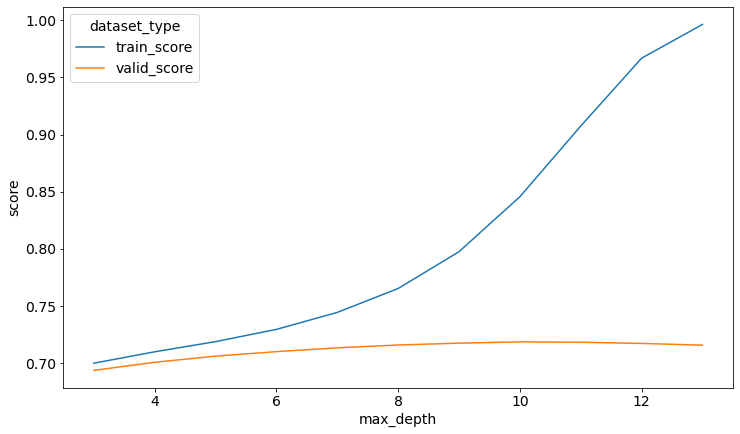

    max_depth  train_score  valid_score
7          10        0.846        0.719
8          11        0.907        0.718
6           9        0.797        0.718
9          12        0.967        0.717
5           8        0.765        0.716
10         13        0.996        0.716
4           7        0.744        0.713
3           6        0.730        0.710
2           5        0.719        0.706
1           4        0.710        0.701
0           3        0.700        0.694

Наилучший результат с параметрами:
max_depth     10.000
train_score    0.846
valid_score    0.719
Name: 7, dtype: float64

Дисбаланс классов = 0.9534738902232898
CPU times: user 28min 12s, sys: 1min 53s, total: 30min 6s
Wall time: 26min 33s


In [7]:
%%time

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from matplotlib import rcParams
from pathlib import Path

# from print_time import print_time, print_msg
# from mts_paths import *

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as RAS
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier

__import__("warnings").filterwarnings("ignore")

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

LOCAL_DATA_PATH = Path('/kaggle/input/mts-ml-cookies')
MY_DATA_PATH = Path('/kaggle/input/mtsmlcup-preprocess-data')
TRAIN_PATH = Path('/kaggle/input/mtsmlcup-train-test')
WORK_PATH = Path('.')
SEED = 2023
SPLIT_SEED = 2023
DATA_FILE = 'dataset_full.feather'
TARGET_FILE = 'target_train.feather'
SUBMISSION_FILE = 'submission.feather'

def memory_compression(df, use_category=True, use_float=True):
    """
    Изменение типов данных для экономии памяти
    :param df_in: исходный ДФ
    :param use_category: преобразовывать строки в категорию
    :return: сжатый ДФ
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        if str(df[col].dtype) not in ('object', 'category'):
            col_min = df[col].min()
            col_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and \
                        col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and \
                        col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and \
                        col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and \
                        col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif use_float and str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float16).min and \
                        col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and \
                        col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif use_category:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f'Исходный размер датасета в памяти '
          f'равен {round(start_mem, 2)} мб.')
    print(f'Конечный размер датасета в памяти '
          f'равен {round(end_mem, 2)} мб.')
    print(f'Экономия памяти = {(1 - end_mem / start_mem):.1%}')
    return df


def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)


def convert_seconds(time_apply):
    # print(type(time_apply), time_apply)
    try:
        time_apply = float(time_apply)
    except ValueError:
        time_apply = 0
    if isinstance(time_apply, (int, float)):
        hrs = time_apply // 3600
        mns = time_apply % 3600
        sec = mns % 60
        time_string = ''
        if hrs:
            time_string = f'{hrs:.0f} час '
        if mns // 60 or hrs:
            time_string += f'{mns // 60:.0f} мин '
        return f'{time_string}{sec:.1f} сек'


def print_time(time_start):
    """
    Печать времени выполнения процесса
    :param time_start: время запуска в формате time.time()
    :return:
    """
    time_apply = time() - time_start
    print(f'Время обработки: {convert_seconds(time_apply)}')


def print_msg(msg):
    print(msg)
    return time()



file_urls = MY_DATA_PATH.joinpath('file_urls.feather')
file_users = MY_DATA_PATH.joinpath('file_users.feather')

file_preprocess_4 = MY_DATA_PATH.joinpath('data_set_preprocess_4.feather')
file_data_agg = MY_DATA_PATH.joinpath('data_agg.parquet')

file_user_cpe = MY_DATA_PATH.joinpath('file_user_cpe.feather')
file_cpe_models = MY_DATA_PATH.joinpath('file_cpe_models.feather')
file_user_city_cpe = MY_DATA_PATH.joinpath('file_user_city_cpe.feather')

file_url_male = MY_DATA_PATH.joinpath('file_url_male.feather')
file_url_age = MY_DATA_PATH.joinpath('file_url_age.feather')

file_train_df = TRAIN_PATH.joinpath('file_train_df.feather')
file_test_df = TRAIN_PATH.joinpath('file_test_df.feather')
df_train_users = TRAIN_PATH.joinpath('train_users.feather')
df_test_users = TRAIN_PATH.joinpath('test_users.feather')

file_submit = LOCAL_DATA_PATH.joinpath('submission.feather')

# тут отфильтрованы только нужные user_id
targets = pd.read_feather(file_users)
targets.head()

USE_CORES = os.cpu_count() - 1
PATH_FILES = '.'
PATH_EXPORT = os.path.join(PATH_FILES, 'EXPORT')

if not os.path.exists(PATH_EXPORT):
    os.makedirs(PATH_EXPORT)
if not os.path.exists(os.path.join(PATH_EXPORT, 'predictions')):
    os.makedirs(os.path.join(PATH_EXPORT, 'predictions'))

rcParams.update({'font.size': 14})  # размер шрифта на графиках
pd.options.display.max_columns = 100
global_start_time = time.time()


def process_model(model=RandomForestClassifier(random_state=SEED),
                  params={'max_depth': [6]}, n_fold=4,
                  verbose=0, build_model=False):
    """
    Поиск лучшей модели
    :param model: модель для обучения и предсказаний
    :param params: параметры для модели
    :param n_fold: на сколько фолдов разбивать данные финальной модели
    :param verbose: = 1 - отображать процесс
    :param build_model: = True - строить модель и выгружать предсказания
    :return: параметры модели, feat_imp_df - датафрейм с фичами
    """
    # skf = StratifiedKFold(n_splits=n_fold, random_state=SEED, shuffle=True)
    skf = KFold(n_splits=n_fold, random_state=SEED, shuffle=True)
    gscv = model.grid_search(params, X_train, y_train, cv=skf,
                             # stratified=True,
                             refit=True)
    model.fit(X_train, y_train)
    best_ = gscv['params']
    print(gscv['cv_results'].keys())

    f1_train = np.array(gscv['cv_results']['train-AUC-mean']).max() * 2 - 1
    f1_valid = np.array(gscv['cv_results']['test-AUC-mean']).max() * 2 - 1

    print(f'folds={n_fold:2d}, '
          f'RAS_train={f1_train:0.7f}, '
          f'RAS_valid={f1_valid:0.7f}, '
          f'best_params={best_}')

    # построение лучшей модели
    if build_model:
        submit_prefix = 'cb_'
        file_submit_csv = os.path.join(PATH_EXPORT, 'predictions',
                                       f'{submit_prefix}submit.csv')
        start_time_cv = time.time()
        print('Обучение модели...')
        max_depth = best_['depth']

        feat_imp = model.feature_importances_
        feat_imp_df = pd.DataFrame({'features': X.columns.values,
                                    'importances': feat_imp})
        feat_imp_df.sort_values('importances', ascending=False, inplace=True)

        # params = {
        #     'n_estimators': 284,
        #     'max_depth': 4,
        #     'subsample': 0.6983901315995189,
        #     'l2_leaf_reg': 3.180242242411711,
        #     'random_strength': 1.2423130425640145,
        #     'eta': 0.04356020658096416,
        #     'min_data_in_leaf': 1,
        #     'grow_policy': 'Lossguide',
        #     'silent': True,
        #     'eval_metric': 'AUC:hints=skip_train~false'
        # }
        # model = CatBoostClassifier(cat_features=category_columns, **params)

        # Обучение модели
        model.fit(X, y)

        date_now = datetime.now()
        time_stamp = date_now.strftime('%y%m%d%H%M%S')

        submit = pd.read_feather(file_submit)
        submit['Churn'] = model.predict_proba(test)[:, 1]
        submit.to_csv(file_submit_csv.replace('.csv', f'_{time_stamp}.csv'))
        # сохранение результатов итерации в файл
        file_name = os.path.join(PATH_EXPORT, 'results.csv')
        if os.path.exists(file_name):
            file_df = pd.read_csv(file_name)
            file_df.time_stamp = pd.to_datetime(file_df.time_stamp,
                                                format='%y-%m-%d %H:%M:%S')
            file_df.time_stamp = file_df.time_stamp.dt.strftime(
                '%y-%m-%d %H:%M:%S')
            if 'comment' not in file_df.columns:
                file_df['comment'] = ''
        else:
            file_df = pd.DataFrame()

        time_stamp = date_now.strftime('%y-%m-%d %H:%M:%S')
        features_list = feat_imp_df.to_dict(orient='split')['data']
        # comments_ = f'{data.data_comment} '
        comments_ = ''
        comments_ += f'X={len(X_train)} rows, y={len(y_train)} rows'
        temp_df = pd.DataFrame({'time_stamp': time_stamp,
                                'mdl': submit_prefix[:2].upper(),
                                'max_depth': max_depth,
                                'folds': n_fold,
                                'f1_train': f1_train,
                                'f1_valid': f1_valid,
                                'best_params': [best_],
                                'features': [features_list],
                                # 'column_dummies': [processor_data.dummy],
                                'model_columns': [model_columns],
                                'category_columns': [category_columns],
                                'learn_exclude': [learn_exclude],
                                'comment': comments_
                                })

        file_df = file_df.append(temp_df)
        file_df.f1_train = file_df.f1_train.round(7)
        file_df.f1_valid = file_df.f1_valid.round(7)
        file_df.to_csv(file_name, index=False)
        file_df.name = 'results'
        # экспорт в эксель
        export_to_excel(file_df)
        print_time(start_time_cv)
        return feat_imp_df
    return [f1_train, f1_valid, n_fold, best_]


def find_depth(use_model, max_depth_values=range(5, 9), show_plot=True):
    print(use_model)
    # Подберем оптимальное значение глубины обучения дерева.
    scores = pd.DataFrame(columns=['max_depth', 'train_score', 'valid_score'])
    for max_depth in max_depth_values:
        print(f'max_depth = {max_depth}')
        find_model = use_model(task_type="GPU",
                               random_state=SEED, silent=True,
                               cat_features=category_columns,
                               max_depth=max_depth,
                               early_stopping_rounds=30,
                               # class_weights=[1, imbalance],
                               auto_class_weights='Balanced',
                               loss_function='Logloss',
#                                eval_metric='AUC:hints=skip_train~false'
                              )

        find_model.fit(X_train, y_train, cat_features=category_columns,
                       verbose=100)

        y_train_pred = find_model.predict_proba(X_train)[:, 1]
        y_valid_pred = find_model.predict_proba(X_valid)[:, 1]
        train_score = RAS(y_train, y_train_pred) * 2 - 1
        valid_score = RAS(y_valid, y_valid_pred) * 2 - 1

        print(f'\ttrain_score = {train_score:.5f}')
        print(f'\tvalid_score = {valid_score:.5f}\n')

        scores.loc[len(scores)] = [max_depth, train_score, valid_score]

    scores.max_depth = scores.max_depth.astype(int)
    scores_data = pd.melt(scores,
                          id_vars=['max_depth'],
                          value_vars=['train_score', 'valid_score'],
                          var_name='dataset_type',
                          value_name='score')
    if show_plot:
        # Визуализация
        plt.figure(figsize=(12, 7))
        sns.lineplot(x='max_depth', y='score', hue='dataset_type',
                     data=scores_data)
        plt.show()
    print(scores.sort_values('valid_score', ascending=False))
    print()
    print('Наилучший результат с параметрами:')
    print(scores.loc[scores.valid_score.idxmax()])
    print()


def export_to_excel(data_df: pd.DataFrame) -> None:
    """
    # экспорт датафрема в эксель
    Convert the dataframe to an XlsxWriter Excel object.
    Note that we turn off default header and skip one row to allow us
    to insert a user defined header.
    :param data: dataframe
    :return: None
    """
    name_data = data_df.name
    file_xls = os.path.join(PATH_EXPORT, f'{name_data}.xlsx')
    writer = pd.ExcelWriter(file_xls, engine='xlsxwriter')
    data_df.to_excel(writer, sheet_name=name_data, startrow=1,
                     header=False, index=False)
    # Get the xlsxwriter workbook and worksheet objects.
    workbook = writer.book
    worksheet = writer.sheets[name_data]
    # Add a header format.
    font_name = 'Arial'
    header_format = workbook.add_format({
        'font_name': font_name,
        'font_size': 10,
        'bold': True,
        'text_wrap': True,
        'align': 'center',
        'valign': 'center',
        'border': 1})
    # Write the column headers with the defined format.
    worksheet.freeze_panes(1, 0)
    for col_num, value in enumerate(data_df.columns.values):
        worksheet.write(0, col_num, value, header_format)
    cell_format = workbook.add_format()
    cell_format.set_font_name(font_name)
    cell_format.set_font_size(12)
    nums_format = workbook.add_format({'num_format': '#0.0000000'})
    nums_format.set_font_name(font_name)
    nums_format.set_font_size(12)
    for num, value in enumerate(data_df.columns.values):
        if value == 'time_stamp':
            width = 19
        elif value in ('mdl', 'folds'):
            width = 8
        elif value in ('max_depth', 'f1_train', 'f1_valid',
                       'r2_train', 'r2_valid',
                       'ras_train', 'ras_valid'):
            width = 14
        else:
            width = 32
        if value in ('f1_train', 'f1_valid', 'r2_train', 'r2_valid',
                     'ras_train', 'ras_valid'):
            worksheet.set_column(num, num, width, nums_format)
        else:
            worksheet.set_column(num, num, width, cell_format)
    worksheet.autofilter(0, 0, len(data_df) - 1, len(data_df) - 1)
    writer.save()
    # End excel save


total_time = time.time()

SEED = 2023

data = dict(data_comment='')

name_emb_factors = []
# количество признаков
# als_factors = 97
# als_factors = 104
als_factors = 100
# als_factors = 150
name_csv = f'url_usr_emb_factors_{als_factors}.csv'
url_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                             '.feather'))
print(url_usr_emb_factors)
name_emb_factors.append(url_usr_emb_factors)

# количество признаков
region_als_factors = 20
name_csv = f'region_usr_emb_factors_{region_als_factors}.csv'
region_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                                '.feather'))
print(region_usr_emb_factors)
name_emb_factors.append(region_usr_emb_factors)

# количество признаков
city_als_factors = 30
name_csv = f'city_usr_emb_factors_{city_als_factors}.csv'
city_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                              '.feather'))
# print(city_usr_emb_factors)
# name_emb_factors.append(city_usr_emb_factors)

# количество признаков
url_male_als_factors = 100
# male_prs_1=0.730036, male_user_prs_1=0.730056, male_avg_prs_1=0.729514
als_columns_male = ('male_prs_1', 'male_user_prs_1', 'male_avg_prs_1')
# als_columns_male = ('male_prs_1', 'male_user_prs_1')
als_columns_male = ('male_user_prs_1',)
# als_columns_male = ('male_avg_prs_1',)
for als_column in als_columns_male:
    name_a = f'url_{als_column}_emb_factors_{url_male_als_factors}.feather'
    url_male_emb_factors = TRAIN_PATH.joinpath(name_a)
    if not url_male_emb_factors.is_file():
        continue
    print(url_male_emb_factors)
    name_emb_factors.append(url_male_emb_factors)
#

# test = pd.read_feather(df_test_users)
test = pd.read_feather(file_submit)  # заглушка для поиска наилучшей модели

targets = pd.read_feather(file_users)
df = pd.read_feather(df_train_users)
df = targets.merge(df, how='left', on='user_id')
df.fillna(0, inplace=True)
# удалить колонку index
for col in ('index', 'url_host_count_distinct_y'):
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# df['is_male'].value_counts()

all_model_columns = [
    'age', 'is_male', 'user_id',
    # 'region_name', 'city_name', 'cpe_id', 'firm_id',
    'price_mean',
    'request_cnt_sum',
    'url_host_count',
    'url_host_count_distinct',
    'different_city',
    'date_count',
    'city_name_count_distinct',
    'region_name_count_distinct',
    'date_count_distinct',
    'male_prs_1',
    # 'male_user_prs_1',  # с этим меньше
    # 'male_avg_1',  #
    'age_prs_1', 'age_prs_2', 'age_prs_3', 'age_prs_4', 'age_prs_5',
    'age_prs_6',
    'age_user_prs_1', 'age_user_prs_2', 'age_user_prs_3', 'age_user_prs_4',
    'age_user_prs_5', 'age_user_prs_6',
    # 'age_avg_1','age_avg_2', 'age_avg_3', 'age_avg_4', 'age_avg_5', 'age_avg_6',
    'pd_prs_0', 'pd_prs_1', 'pd_prs_2', 'pd_prs_3',
    'url_m_0_sum', 'url_m_1_sum',  # GINI по полу 0.724
    'url_u_0_sum', 'url_u_1_sum',  # GINI по полу 0.724
    # 'url_a_0_sum', 'url_a_1_sum', # GINI по полу 0.716
    'fm_r0_sum', 'fm_u0_sum',
    'fm_r1_sum', 'fm_u1_sum',
    'fame0user_sum', 'fame_user_sum'
]

# колонки с категориями
all_categories = (
    'cpe_id',
    'firm_id',
    # 'region_name',
    'city_name',
    'url_m',
    'url_u',
    'url_a',
)

learn_exclude = ['fame0user_sum', 'region_name']

model_columns = []
for col in all_model_columns:
    if col in df.columns and col not in learn_exclude:
        if col not in model_columns:
            model_columns.append(col)

# маркировка сайта  -1 - женский,  1 - мужской, 0 - нейтральный
# df['url_m'] = np.sign(df.url_m_1_sum - df.url_m_0_sum)
# df['url_u'] = np.sign(df.url_u_1_sum - df.url_u_0_sum)
# df['url_a'] = np.sign(df.url_a_1_sum - df.url_a_0_sum)

# формирование списка колонок с категориями и
# добавление маркеров в категории если они присутствуют
category_columns = []
for col in all_categories:
    if col in df.columns and col not in learn_exclude:
        category_columns.append(col)
        if col not in model_columns:
            model_columns.append(col)

df = df[model_columns]

print('Обучаюсь на колонках:', model_columns)
print('Категорийные колонки:', category_columns)
print('Исключенные колонки:', learn_exclude)

for col in category_columns:
    if col in df.columns:
        df[col] = df[col].astype(str)

train_columns = df.columns[2:]
train_dtypes = df.dtypes[2:]

# df = targets
# df['price_mean'] = 0

for emb_file in name_emb_factors:
    usr_emb = pd.read_feather(emb_file)
    df = df.merge(usr_emb, how='left', on='user_id')

train = df.drop(['user_id', 'age', 'is_male', 'price_mean'], axis=1)
target = df['is_male']
# test = test[model_columns]

X = train
y = target

txt = ('Размер ', ' пропусков ')
print(f'{txt[0]}трейна: {train.shape}{txt[1]}{train.isna().sum().sum()}')
print(f'{txt[0]}теста: {test.shape}{txt[1]}{test.isna().sum().sum()}')

# было test_size=0.25
X_train, X_valid, y_train, y_valid = train_test_split(train, target,
                                                      test_size=0.25,
                                                      shuffle=True,
                                                      random_state=SEED,
                                                      # stratify=target
                                                      )
print()
print(f'{txt[0]}X_train: {X_train.shape}{txt[1]}'
      f'{X_train.isna().sum().sum()}')
print(f'{txt[0]}X_valid: {X_valid.shape}{txt[1]}'
      f'{X_valid.isna().sum().sum()}')

# X_train, X_valid, y_train, y_valid = X, X, y, y

imbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f'Дисбаланс классов = {imbalance}')

find_depth(CatBoostClassifier, max_depth_values=range(3, 14))
#    max_depth  train_score  valid_score
# 1          6     0.810699     0.729837
# 2          7     0.849588     0.728472
# 0          5     0.781493     0.727756
# 3          8     0.898785     0.727400

# настройки для первого приближения: поиск глубины деревьев
# и количества фолдов
# models = []
# for fold in range(4, 8):
#     for depth in range(5, 8):
#         param = {'max_depth': [depth]}
#         # определение моделей
#         mdl = CatBoostClassifier(task_type="GPU",
#                                  random_state=SEED, silent=True,
#                                  early_stopping_rounds=30,
#                                  cat_features=category_columns,
#                                  # class_weights=[1, imbalance],
#                                  auto_class_weights='Balanced',
#                                  loss_function='Logloss',
#                                  eval_metric='AUC:hints=skip_train~false'
#                                 )
#         result = process_model(mdl, params=param, n_fold=fold)
#         models.append(result)
# models.sort(key=lambda x: (-x[1], x[2]))
# print()
# for elem in models:
#     print(elem)

#     max_depth  train_score  valid_score
# 7          10        0.846        0.719
# 8          11        0.907        0.718
# 6           9        0.797        0.718
# 9          12        0.967        0.717
# 5           8        0.765        0.716
# 10         13        0.996        0.716
# 4           7        0.744        0.713
# 3           6        0.730        0.710
# 2           5        0.719        0.706
# 1           4        0.710        0.701
# 0           3        0.700        0.694


X_train, y_train = X, y

imbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f'Дисбаланс классов = {imbalance}')

# определение моделей
mdl = CatBoostClassifier(task_type="GPU",
                         random_state=SEED, silent=True,
                         cat_features=category_columns,
                         # class_weights=[1, imbalance],
                         auto_class_weights='Balanced',
                         early_stopping_rounds=50,
                         loss_function='Logloss',
                         eval_metric='AUC:hints=skip_train~false')

# немного потюним и результат грузим на Kaggle
feat_imp_df_ = pd.DataFrame()

# CB,4,6,0.873188,0.8490922,"{'min_data_in_leaf': 2, 'depth': 4,
# 'iterations': 370, 'subsample': 0.7, 'random_strength': 1.25,
# 'l2_leaf_reg': 3.2, 'grow_policy': 'Lossguide'}" mean_total_spent

f_params = {
    'n_estimators': range(365, 381, 1),
    # 'n_estimators': [370],
    # 'max_depth': range(2, 7),
    'max_depth': [4],
    # 'learning_rate': [.01, .05],
    # 'learning_rate': np.linspace(0.03, 0.04, 11),
    # 'learning_rate': [.03],
    # 'min_data_in_leaf': range(2, 4, 1),
    'min_data_in_leaf': [2],
    'subsample': np.linspace(0.7, 0.8, 11),
    # 'subsample': [0.75],
    # 'random_strength': np.linspace(1.24, 1.26, 5),
    'random_strength': [1.255],
    # 'l2_leaf_reg': np.linspace(3.1, 3.2, 11),
    'l2_leaf_reg': [3.15],
    'grow_policy': ['Lossguide'],
}
# раскоментарить эту строку для расчета
# for n in range(6, 7):
#     mdl = CatBoostClassifier(random_state=SEED, silent=True,
#                              cat_features=category_columns,
#                              # class_weights={0: 1, 1: imbalance},
#                              auto_class_weights='Balanced',
#                              loss_function='Logloss',
#                              eval_metric='AUC:hints=skip_train~false')
#
#     _, feat_imp_df_ = process_model(mdl, params=f_params, n_fold=n,
#                                     verbose=20, build_model=True)
#     print(feat_imp_df_)

# model = CatBoostClassifier(silent=True, random_state=SEED,
#                            class_weights=[1, imbalance],
#                            eval_metric='F1')
# model.fit(X_train, y_train)
# evaluate_preds(model, X_train, X_valid, y_train, y_valid)

# params = {
#     # 'iterations': [5, 7, 10, 20, 30, 50, 100],
#     # 'max_depth': [3, 5, 7, 10],
#     'max_depth': range(5, 6),
#     'iterations': range(50, 201, 10),
#     # 'learning_rate': [.005, .01, .025, .05]
# }
# поставил общий дисбаланс попробовать это грузануть
# imbalance = y.value_counts()[0] / y.value_counts()[1]

# model = CatBoostClassifier(silent=True, random_state=SEED,
#                            class_weights=[1, imbalance],
#                            cat_features=category_columns,
#                            eval_metric='F1',
#                            early_stopping_rounds=50, )
#
# feat_imp_df_ = process_model(model, params=params, fold_single=5,
#                              verbose=20, build_model=True)
# print(feat_imp_df_)

# skf = StratifiedKFold(n_splits=5, random_state=SEED,
#                       shuffle=True)
# search_cv = model.grid_search(params, X_train, y_train, cv=skf,
#                               stratified=True, refit=True)
# for key, value in model.get_all_params().items():
#     print(f'{key} : {value}'.format(key, value))
#
# a = model.get_all_params()['iterations']
# b = model.get_all_params()['depth']

/kaggle/input/mtsmlcup-preprocess-data/url_usr_emb_factors_97.feather
/kaggle/input/mtsmlcup-preprocess-data/region_usr_emb_factors_20.feather
/kaggle/input/mtsmlcup-train-test/url_male_avg_prs_1_emb_factors_100.feather
Обучаюсь на колонках: ['age', 'is_male', 'user_id', 'price_mean', 'request_cnt_sum', 'url_host_count', 'url_host_count_distinct', 'different_city', 'date_count', 'city_name_count_distinct', 'region_name_count_distinct', 'date_count_distinct', 'male_prs_1', 'age_prs_1', 'age_prs_2', 'age_prs_3', 'age_prs_4', 'age_prs_5', 'age_prs_6', 'age_user_prs_1', 'age_user_prs_2', 'age_user_prs_3', 'age_user_prs_4', 'age_user_prs_5', 'age_user_prs_6', 'pd_prs_0', 'pd_prs_1', 'pd_prs_2', 'pd_prs_3', 'url_m_0_sum', 'url_m_1_sum', 'url_u_0_sum', 'url_u_1_sum', 'fm_r0_sum', 'fm_u0_sum', 'fm_r1_sum', 'fm_u1_sum', 'fame_user_sum', 'cpe_id', 'firm_id', 'city_name']
Категорийные колонки: ['cpe_id', 'firm_id', 'city_name']
Исключенные колонки: ['fame0user_sum', 'region_name']
Размер трейна: 

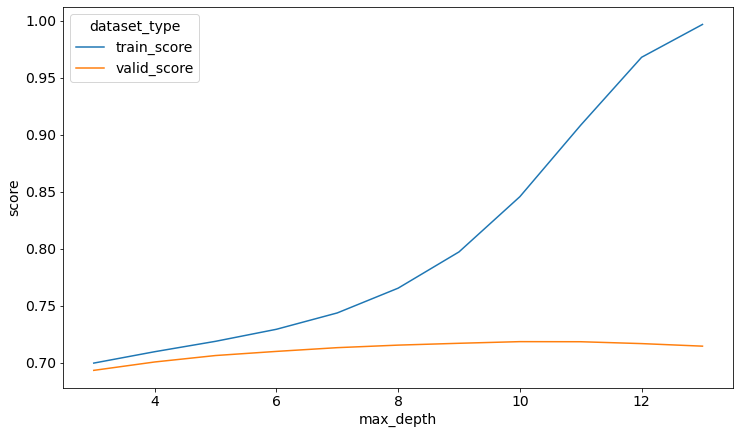

    max_depth  train_score  valid_score
7          10        0.846        0.719
8          11        0.908        0.719
6           9        0.797        0.717
9          12        0.968        0.717
5           8        0.765        0.716
10         13        0.997        0.715
4           7        0.744        0.713
3           6        0.729        0.710
2           5        0.719        0.706
1           4        0.710        0.701
0           3        0.700        0.693

Наилучший результат с параметрами:
max_depth     10.000
train_score    0.846
valid_score    0.719
Name: 7, dtype: float64

Дисбаланс классов = 0.9534738902232898
CPU times: user 28min 48s, sys: 1min 54s, total: 30min 43s
Wall time: 27min 20s


In [8]:
%%time

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from matplotlib import rcParams
from pathlib import Path

# from print_time import print_time, print_msg
# from mts_paths import *

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as RAS
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier

__import__("warnings").filterwarnings("ignore")

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

LOCAL_DATA_PATH = Path('/kaggle/input/mts-ml-cookies')
MY_DATA_PATH = Path('/kaggle/input/mtsmlcup-preprocess-data')
TRAIN_PATH = Path('/kaggle/input/mtsmlcup-train-test')
WORK_PATH = Path('.')
SEED = 2023
SPLIT_SEED = 2023
DATA_FILE = 'dataset_full.feather'
TARGET_FILE = 'target_train.feather'
SUBMISSION_FILE = 'submission.feather'

def memory_compression(df, use_category=True, use_float=True):
    """
    Изменение типов данных для экономии памяти
    :param df_in: исходный ДФ
    :param use_category: преобразовывать строки в категорию
    :return: сжатый ДФ
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        if str(df[col].dtype) not in ('object', 'category'):
            col_min = df[col].min()
            col_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and \
                        col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and \
                        col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and \
                        col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and \
                        col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif use_float and str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float16).min and \
                        col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and \
                        col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif use_category:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f'Исходный размер датасета в памяти '
          f'равен {round(start_mem, 2)} мб.')
    print(f'Конечный размер датасета в памяти '
          f'равен {round(end_mem, 2)} мб.')
    print(f'Экономия памяти = {(1 - end_mem / start_mem):.1%}')
    return df


def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)


def convert_seconds(time_apply):
    # print(type(time_apply), time_apply)
    try:
        time_apply = float(time_apply)
    except ValueError:
        time_apply = 0
    if isinstance(time_apply, (int, float)):
        hrs = time_apply // 3600
        mns = time_apply % 3600
        sec = mns % 60
        time_string = ''
        if hrs:
            time_string = f'{hrs:.0f} час '
        if mns // 60 or hrs:
            time_string += f'{mns // 60:.0f} мин '
        return f'{time_string}{sec:.1f} сек'


def print_time(time_start):
    """
    Печать времени выполнения процесса
    :param time_start: время запуска в формате time.time()
    :return:
    """
    time_apply = time() - time_start
    print(f'Время обработки: {convert_seconds(time_apply)}')


def print_msg(msg):
    print(msg)
    return time()



file_urls = MY_DATA_PATH.joinpath('file_urls.feather')
file_users = MY_DATA_PATH.joinpath('file_users.feather')

file_preprocess_4 = MY_DATA_PATH.joinpath('data_set_preprocess_4.feather')
file_data_agg = MY_DATA_PATH.joinpath('data_agg.parquet')

file_user_cpe = MY_DATA_PATH.joinpath('file_user_cpe.feather')
file_cpe_models = MY_DATA_PATH.joinpath('file_cpe_models.feather')
file_user_city_cpe = MY_DATA_PATH.joinpath('file_user_city_cpe.feather')

file_url_male = MY_DATA_PATH.joinpath('file_url_male.feather')
file_url_age = MY_DATA_PATH.joinpath('file_url_age.feather')

file_train_df = TRAIN_PATH.joinpath('file_train_df.feather')
file_test_df = TRAIN_PATH.joinpath('file_test_df.feather')
df_train_users = TRAIN_PATH.joinpath('train_users.feather')
df_test_users = TRAIN_PATH.joinpath('test_users.feather')

file_submit = LOCAL_DATA_PATH.joinpath('submission.feather')

# тут отфильтрованы только нужные user_id
targets = pd.read_feather(file_users)
targets.head()

USE_CORES = os.cpu_count() - 1
PATH_FILES = '.'
PATH_EXPORT = os.path.join(PATH_FILES, 'EXPORT')

if not os.path.exists(PATH_EXPORT):
    os.makedirs(PATH_EXPORT)
if not os.path.exists(os.path.join(PATH_EXPORT, 'predictions')):
    os.makedirs(os.path.join(PATH_EXPORT, 'predictions'))

rcParams.update({'font.size': 14})  # размер шрифта на графиках
pd.options.display.max_columns = 100
global_start_time = time.time()


def process_model(model=RandomForestClassifier(random_state=SEED),
                  params={'max_depth': [6]}, n_fold=4,
                  verbose=0, build_model=False):
    """
    Поиск лучшей модели
    :param model: модель для обучения и предсказаний
    :param params: параметры для модели
    :param n_fold: на сколько фолдов разбивать данные финальной модели
    :param verbose: = 1 - отображать процесс
    :param build_model: = True - строить модель и выгружать предсказания
    :return: параметры модели, feat_imp_df - датафрейм с фичами
    """
    # skf = StratifiedKFold(n_splits=n_fold, random_state=SEED, shuffle=True)
    skf = KFold(n_splits=n_fold, random_state=SEED, shuffle=True)
    gscv = model.grid_search(params, X_train, y_train, cv=skf,
                             # stratified=True,
                             refit=True)
    model.fit(X_train, y_train)
    best_ = gscv['params']
    print(gscv['cv_results'].keys())

    f1_train = np.array(gscv['cv_results']['train-AUC-mean']).max() * 2 - 1
    f1_valid = np.array(gscv['cv_results']['test-AUC-mean']).max() * 2 - 1

    print(f'folds={n_fold:2d}, '
          f'RAS_train={f1_train:0.7f}, '
          f'RAS_valid={f1_valid:0.7f}, '
          f'best_params={best_}')

    # построение лучшей модели
    if build_model:
        submit_prefix = 'cb_'
        file_submit_csv = os.path.join(PATH_EXPORT, 'predictions',
                                       f'{submit_prefix}submit.csv')
        start_time_cv = time.time()
        print('Обучение модели...')
        max_depth = best_['depth']

        feat_imp = model.feature_importances_
        feat_imp_df = pd.DataFrame({'features': X.columns.values,
                                    'importances': feat_imp})
        feat_imp_df.sort_values('importances', ascending=False, inplace=True)

        # params = {
        #     'n_estimators': 284,
        #     'max_depth': 4,
        #     'subsample': 0.6983901315995189,
        #     'l2_leaf_reg': 3.180242242411711,
        #     'random_strength': 1.2423130425640145,
        #     'eta': 0.04356020658096416,
        #     'min_data_in_leaf': 1,
        #     'grow_policy': 'Lossguide',
        #     'silent': True,
        #     'eval_metric': 'AUC:hints=skip_train~false'
        # }
        # model = CatBoostClassifier(cat_features=category_columns, **params)

        # Обучение модели
        model.fit(X, y)

        date_now = datetime.now()
        time_stamp = date_now.strftime('%y%m%d%H%M%S')

        submit = pd.read_feather(file_submit)
        submit['Churn'] = model.predict_proba(test)[:, 1]
        submit.to_csv(file_submit_csv.replace('.csv', f'_{time_stamp}.csv'))
        # сохранение результатов итерации в файл
        file_name = os.path.join(PATH_EXPORT, 'results.csv')
        if os.path.exists(file_name):
            file_df = pd.read_csv(file_name)
            file_df.time_stamp = pd.to_datetime(file_df.time_stamp,
                                                format='%y-%m-%d %H:%M:%S')
            file_df.time_stamp = file_df.time_stamp.dt.strftime(
                '%y-%m-%d %H:%M:%S')
            if 'comment' not in file_df.columns:
                file_df['comment'] = ''
        else:
            file_df = pd.DataFrame()

        time_stamp = date_now.strftime('%y-%m-%d %H:%M:%S')
        features_list = feat_imp_df.to_dict(orient='split')['data']
        # comments_ = f'{data.data_comment} '
        comments_ = ''
        comments_ += f'X={len(X_train)} rows, y={len(y_train)} rows'
        temp_df = pd.DataFrame({'time_stamp': time_stamp,
                                'mdl': submit_prefix[:2].upper(),
                                'max_depth': max_depth,
                                'folds': n_fold,
                                'f1_train': f1_train,
                                'f1_valid': f1_valid,
                                'best_params': [best_],
                                'features': [features_list],
                                # 'column_dummies': [processor_data.dummy],
                                'model_columns': [model_columns],
                                'category_columns': [category_columns],
                                'learn_exclude': [learn_exclude],
                                'comment': comments_
                                })

        file_df = file_df.append(temp_df)
        file_df.f1_train = file_df.f1_train.round(7)
        file_df.f1_valid = file_df.f1_valid.round(7)
        file_df.to_csv(file_name, index=False)
        file_df.name = 'results'
        # экспорт в эксель
        export_to_excel(file_df)
        print_time(start_time_cv)
        return feat_imp_df
    return [f1_train, f1_valid, n_fold, best_]


def find_depth(use_model, max_depth_values=range(5, 9), show_plot=True):
    print(use_model)
    # Подберем оптимальное значение глубины обучения дерева.
    scores = pd.DataFrame(columns=['max_depth', 'train_score', 'valid_score'])
    for max_depth in max_depth_values:
        print(f'max_depth = {max_depth}')
        find_model = use_model(task_type="GPU",
                               random_state=SEED, silent=True,
                               cat_features=category_columns,
                               max_depth=max_depth,
                               early_stopping_rounds=30,
                               # class_weights=[1, imbalance],
                               auto_class_weights='Balanced',
                               loss_function='Logloss',
#                                eval_metric='AUC:hints=skip_train~false'
                              )

        find_model.fit(X_train, y_train, cat_features=category_columns,
                       verbose=100)

        y_train_pred = find_model.predict_proba(X_train)[:, 1]
        y_valid_pred = find_model.predict_proba(X_valid)[:, 1]
        train_score = RAS(y_train, y_train_pred) * 2 - 1
        valid_score = RAS(y_valid, y_valid_pred) * 2 - 1

        print(f'\ttrain_score = {train_score:.5f}')
        print(f'\tvalid_score = {valid_score:.5f}\n')

        scores.loc[len(scores)] = [max_depth, train_score, valid_score]

    scores.max_depth = scores.max_depth.astype(int)
    scores_data = pd.melt(scores,
                          id_vars=['max_depth'],
                          value_vars=['train_score', 'valid_score'],
                          var_name='dataset_type',
                          value_name='score')
    if show_plot:
        # Визуализация
        plt.figure(figsize=(12, 7))
        sns.lineplot(x='max_depth', y='score', hue='dataset_type',
                     data=scores_data)
        plt.show()
    print(scores.sort_values('valid_score', ascending=False))
    print()
    print('Наилучший результат с параметрами:')
    print(scores.loc[scores.valid_score.idxmax()])
    print()


def export_to_excel(data_df: pd.DataFrame) -> None:
    """
    # экспорт датафрема в эксель
    Convert the dataframe to an XlsxWriter Excel object.
    Note that we turn off default header and skip one row to allow us
    to insert a user defined header.
    :param data: dataframe
    :return: None
    """
    name_data = data_df.name
    file_xls = os.path.join(PATH_EXPORT, f'{name_data}.xlsx')
    writer = pd.ExcelWriter(file_xls, engine='xlsxwriter')
    data_df.to_excel(writer, sheet_name=name_data, startrow=1,
                     header=False, index=False)
    # Get the xlsxwriter workbook and worksheet objects.
    workbook = writer.book
    worksheet = writer.sheets[name_data]
    # Add a header format.
    font_name = 'Arial'
    header_format = workbook.add_format({
        'font_name': font_name,
        'font_size': 10,
        'bold': True,
        'text_wrap': True,
        'align': 'center',
        'valign': 'center',
        'border': 1})
    # Write the column headers with the defined format.
    worksheet.freeze_panes(1, 0)
    for col_num, value in enumerate(data_df.columns.values):
        worksheet.write(0, col_num, value, header_format)
    cell_format = workbook.add_format()
    cell_format.set_font_name(font_name)
    cell_format.set_font_size(12)
    nums_format = workbook.add_format({'num_format': '#0.0000000'})
    nums_format.set_font_name(font_name)
    nums_format.set_font_size(12)
    for num, value in enumerate(data_df.columns.values):
        if value == 'time_stamp':
            width = 19
        elif value in ('mdl', 'folds'):
            width = 8
        elif value in ('max_depth', 'f1_train', 'f1_valid',
                       'r2_train', 'r2_valid',
                       'ras_train', 'ras_valid'):
            width = 14
        else:
            width = 32
        if value in ('f1_train', 'f1_valid', 'r2_train', 'r2_valid',
                     'ras_train', 'ras_valid'):
            worksheet.set_column(num, num, width, nums_format)
        else:
            worksheet.set_column(num, num, width, cell_format)
    worksheet.autofilter(0, 0, len(data_df) - 1, len(data_df) - 1)
    writer.save()
    # End excel save


total_time = time.time()

SEED = 2023

data = dict(data_comment='')

name_emb_factors = []
# количество признаков
als_factors = 97
# als_factors = 104
# als_factors = 100
# als_factors = 150
name_csv = f'url_usr_emb_factors_{als_factors}.csv'
url_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                             '.feather'))
print(url_usr_emb_factors)
name_emb_factors.append(url_usr_emb_factors)

# количество признаков
region_als_factors = 20
name_csv = f'region_usr_emb_factors_{region_als_factors}.csv'
region_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                                '.feather'))
print(region_usr_emb_factors)
name_emb_factors.append(region_usr_emb_factors)

# количество признаков
city_als_factors = 30
name_csv = f'city_usr_emb_factors_{city_als_factors}.csv'
city_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                              '.feather'))
# print(city_usr_emb_factors)
# name_emb_factors.append(city_usr_emb_factors)

# количество признаков
url_male_als_factors = 100
# male_prs_1=0.730036, male_user_prs_1=0.730056, male_avg_prs_1=0.729514
als_columns_male = ('male_prs_1', 'male_user_prs_1', 'male_avg_prs_1')
# als_columns_male = ('male_prs_1', 'male_user_prs_1')
# als_columns_male = ('male_user_prs_1',)
als_columns_male = ('male_avg_prs_1',)
for als_column in als_columns_male:
    name_a = f'url_{als_column}_emb_factors_{url_male_als_factors}.feather'
    url_male_emb_factors = TRAIN_PATH.joinpath(name_a)
    if not url_male_emb_factors.is_file():
        continue
    print(url_male_emb_factors)
    name_emb_factors.append(url_male_emb_factors)
#

# test = pd.read_feather(df_test_users)
test = pd.read_feather(file_submit)  # заглушка для поиска наилучшей модели

targets = pd.read_feather(file_users)
df = pd.read_feather(df_train_users)
df = targets.merge(df, how='left', on='user_id')
df.fillna(0, inplace=True)
# удалить колонку index
for col in ('index', 'url_host_count_distinct_y'):
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# df['is_male'].value_counts()

all_model_columns = [
    'age', 'is_male', 'user_id',
    # 'region_name', 'city_name', 'cpe_id', 'firm_id',
    'price_mean',
    'request_cnt_sum',
    'url_host_count',
    'url_host_count_distinct',
    'different_city',
    'date_count',
    'city_name_count_distinct',
    'region_name_count_distinct',
    'date_count_distinct',
    'male_prs_1',
    # 'male_user_prs_1',  # с этим меньше
    # 'male_avg_1',  #
    'age_prs_1', 'age_prs_2', 'age_prs_3', 'age_prs_4', 'age_prs_5',
    'age_prs_6',
    'age_user_prs_1', 'age_user_prs_2', 'age_user_prs_3', 'age_user_prs_4',
    'age_user_prs_5', 'age_user_prs_6',
    # 'age_avg_1','age_avg_2', 'age_avg_3', 'age_avg_4', 'age_avg_5', 'age_avg_6',
    'pd_prs_0', 'pd_prs_1', 'pd_prs_2', 'pd_prs_3',
    'url_m_0_sum', 'url_m_1_sum',  # GINI по полу 0.724
    'url_u_0_sum', 'url_u_1_sum',  # GINI по полу 0.724
    # 'url_a_0_sum', 'url_a_1_sum', # GINI по полу 0.716
    'fm_r0_sum', 'fm_u0_sum',
    'fm_r1_sum', 'fm_u1_sum',
    'fame0user_sum', 'fame_user_sum'
]

# колонки с категориями
all_categories = (
    'cpe_id',
    'firm_id',
    # 'region_name',
    'city_name',
    'url_m',
    'url_u',
    'url_a',
)

learn_exclude = ['fame0user_sum', 'region_name']

model_columns = []
for col in all_model_columns:
    if col in df.columns and col not in learn_exclude:
        if col not in model_columns:
            model_columns.append(col)

# маркировка сайта  -1 - женский,  1 - мужской, 0 - нейтральный
# df['url_m'] = np.sign(df.url_m_1_sum - df.url_m_0_sum)
# df['url_u'] = np.sign(df.url_u_1_sum - df.url_u_0_sum)
# df['url_a'] = np.sign(df.url_a_1_sum - df.url_a_0_sum)

# формирование списка колонок с категориями и
# добавление маркеров в категории если они присутствуют
category_columns = []
for col in all_categories:
    if col in df.columns and col not in learn_exclude:
        category_columns.append(col)
        if col not in model_columns:
            model_columns.append(col)

df = df[model_columns]

print('Обучаюсь на колонках:', model_columns)
print('Категорийные колонки:', category_columns)
print('Исключенные колонки:', learn_exclude)

for col in category_columns:
    if col in df.columns:
        df[col] = df[col].astype(str)

train_columns = df.columns[2:]
train_dtypes = df.dtypes[2:]

# df = targets
# df['price_mean'] = 0

for emb_file in name_emb_factors:
    usr_emb = pd.read_feather(emb_file)
    df = df.merge(usr_emb, how='left', on='user_id')

train = df.drop(['user_id', 'age', 'is_male', 'price_mean'], axis=1)
target = df['is_male']
# test = test[model_columns]

X = train
y = target

txt = ('Размер ', ' пропусков ')
print(f'{txt[0]}трейна: {train.shape}{txt[1]}{train.isna().sum().sum()}')
print(f'{txt[0]}теста: {test.shape}{txt[1]}{test.isna().sum().sum()}')

# было test_size=0.25
X_train, X_valid, y_train, y_valid = train_test_split(train, target,
                                                      test_size=0.25,
                                                      shuffle=True,
                                                      random_state=SEED,
                                                      # stratify=target
                                                      )
print()
print(f'{txt[0]}X_train: {X_train.shape}{txt[1]}'
      f'{X_train.isna().sum().sum()}')
print(f'{txt[0]}X_valid: {X_valid.shape}{txt[1]}'
      f'{X_valid.isna().sum().sum()}')

# X_train, X_valid, y_train, y_valid = X, X, y, y

imbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f'Дисбаланс классов = {imbalance}')

find_depth(CatBoostClassifier, max_depth_values=range(3, 14))

#     max_depth  train_score  valid_score
# 7          10        0.846        0.719
# 8          11        0.908        0.719
# 6           9        0.797        0.717
# 9          12        0.968        0.717
# 5           8        0.765        0.716
# 10         13        0.997        0.715
# 4           7        0.744        0.713
# 3           6        0.729        0.710
# 2           5        0.719        0.706
# 1           4        0.710        0.701
# 0           3        0.700        0.693

# настройки для первого приближения: поиск глубины деревьев
# и количества фолдов
# models = []
# for fold in range(4, 8):
#     for depth in range(5, 8):
#         param = {'max_depth': [depth]}
#         # определение моделей
#         mdl = CatBoostClassifier(task_type="GPU",
#                                  random_state=SEED, silent=True,
#                                  early_stopping_rounds=30,
#                                  cat_features=category_columns,
#                                  # class_weights=[1, imbalance],
#                                  auto_class_weights='Balanced',
#                                  loss_function='Logloss',
#                                  eval_metric='AUC:hints=skip_train~false'
#                                 )
#         result = process_model(mdl, params=param, n_fold=fold)
#         models.append(result)
# models.sort(key=lambda x: (-x[1], x[2]))
# print()
# for elem in models:
#     print(elem)
# [0.7630565540471375, 0.7162994858677696, 6, {'depth': 7}]
# [0.764672785812208, 0.7160511584270981, 5, {'depth': 7}]
# [0.7620053471970019, 0.7160235886937023, 7, {'depth': 7}]
# [0.7679784394628708, 0.7159254249644087, 4, {'depth': 7}]
# [0.7734023605216029, 0.7146306591834477, 3, {'depth': 7}]
# [0.7421915580785663, 0.7137629276584769, 7, {'depth': 6}]
# [0.7427936178219348, 0.7135691615616893, 6, {'depth': 6}]
# [0.7440312279758676, 0.7134294645426695, 5, {'depth': 6}]
# [0.7460892101865069, 0.7129328925062377, 4, {'depth': 6}]
# [0.7497012615335281, 0.7122280665887948, 3, {'depth': 6}]
# [0.7278463229514947, 0.709742577451753, 7, {'depth': 5}]
# [0.7281342327514402, 0.7097234543801096, 6, {'depth': 5}]
# [0.728833004284434, 0.7094904769714716, 5, {'depth': 5}]
# [0.730123345245042, 0.7093107163785246, 4, {'depth': 5}]
# [0.7324813841926314, 0.7090105864214025, 3, {'depth': 5}]

X_train, y_train = X, y

imbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f'Дисбаланс классов = {imbalance}')

# определение моделей
mdl = CatBoostClassifier(task_type="GPU",
                         random_state=SEED, silent=True,
                         cat_features=category_columns,
                         # class_weights=[1, imbalance],
                         auto_class_weights='Balanced',
                         early_stopping_rounds=50,
                         loss_function='Logloss',
                         eval_metric='AUC:hints=skip_train~false')

# немного потюним и результат грузим на Kaggle
feat_imp_df_ = pd.DataFrame()

# CB,4,6,0.873188,0.8490922,"{'min_data_in_leaf': 2, 'depth': 4,
# 'iterations': 370, 'subsample': 0.7, 'random_strength': 1.25,
# 'l2_leaf_reg': 3.2, 'grow_policy': 'Lossguide'}" mean_total_spent

f_params = {
    'n_estimators': range(365, 381, 1),
    # 'n_estimators': [370],
    # 'max_depth': range(2, 7),
    'max_depth': [4],
    # 'learning_rate': [.01, .05],
    # 'learning_rate': np.linspace(0.03, 0.04, 11),
    # 'learning_rate': [.03],
    # 'min_data_in_leaf': range(2, 4, 1),
    'min_data_in_leaf': [2],
    'subsample': np.linspace(0.7, 0.8, 11),
    # 'subsample': [0.75],
    # 'random_strength': np.linspace(1.24, 1.26, 5),
    'random_strength': [1.255],
    # 'l2_leaf_reg': np.linspace(3.1, 3.2, 11),
    'l2_leaf_reg': [3.15],
    'grow_policy': ['Lossguide'],
}
# раскоментарить эту строку для расчета
# for n in range(6, 7):
#     mdl = CatBoostClassifier(random_state=SEED, silent=True,
#                              cat_features=category_columns,
#                              # class_weights={0: 1, 1: imbalance},
#                              auto_class_weights='Balanced',
#                              loss_function='Logloss',
#                              eval_metric='AUC:hints=skip_train~false')
#
#     _, feat_imp_df_ = process_model(mdl, params=f_params, n_fold=n,
#                                     verbose=20, build_model=True)
#     print(feat_imp_df_)

# model = CatBoostClassifier(silent=True, random_state=SEED,
#                            class_weights=[1, imbalance],
#                            eval_metric='F1')
# model.fit(X_train, y_train)
# evaluate_preds(model, X_train, X_valid, y_train, y_valid)

# params = {
#     # 'iterations': [5, 7, 10, 20, 30, 50, 100],
#     # 'max_depth': [3, 5, 7, 10],
#     'max_depth': range(5, 6),
#     'iterations': range(50, 201, 10),
#     # 'learning_rate': [.005, .01, .025, .05]
# }
# поставил общий дисбаланс попробовать это грузануть
# imbalance = y.value_counts()[0] / y.value_counts()[1]

# model = CatBoostClassifier(silent=True, random_state=SEED,
#                            class_weights=[1, imbalance],
#                            cat_features=category_columns,
#                            eval_metric='F1',
#                            early_stopping_rounds=50, )
#
# feat_imp_df_ = process_model(model, params=params, fold_single=5,
#                              verbose=20, build_model=True)
# print(feat_imp_df_)

# skf = StratifiedKFold(n_splits=5, random_state=SEED,
#                       shuffle=True)
# search_cv = model.grid_search(params, X_train, y_train, cv=skf,
#                               stratified=True, refit=True)
# for key, value in model.get_all_params().items():
#     print(f'{key} : {value}'.format(key, value))
#
# a = model.get_all_params()['iterations']
# b = model.get_all_params()['depth']

/kaggle/input/mtsmlcup-preprocess-data/url_usr_emb_factors_97.feather
/kaggle/input/mtsmlcup-preprocess-data/region_usr_emb_factors_20.feather
/kaggle/input/mtsmlcup-train-test/url_male_avg_prs_1_emb_factors_100.feather
Обучаюсь на колонках: ['age', 'is_male', 'user_id', 'price_mean', 'request_cnt_sum', 'url_host_count', 'url_host_count_distinct', 'different_city', 'date_count', 'city_name_count_distinct', 'region_name_count_distinct', 'date_count_distinct', 'male_prs_1', 'age_prs_1', 'age_prs_2', 'age_prs_3', 'age_prs_4', 'age_prs_5', 'age_prs_6', 'age_user_prs_1', 'age_user_prs_2', 'age_user_prs_3', 'age_user_prs_4', 'age_user_prs_5', 'age_user_prs_6', 'pd_prs_0', 'pd_prs_1', 'pd_prs_2', 'pd_prs_3', 'url_m_0_sum', 'url_m_1_sum', 'url_u_0_sum', 'url_u_1_sum', 'fm_r0_sum', 'fm_u0_sum', 'fm_r1_sum', 'fm_u1_sum', 'fame_user_sum', 'cpe_id', 'firm_id', 'city_name']
Категорийные колонки: ['cpe_id', 'firm_id', 'city_name']
Исключенные колонки: ['fame0user_sum', 'region_name']
Размер трейна: 

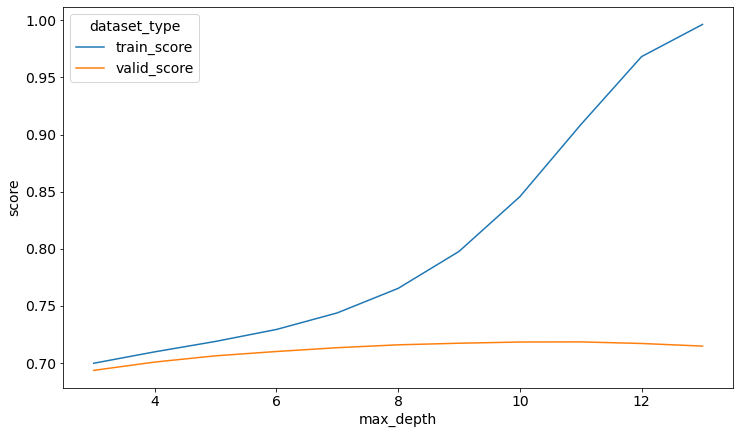

    max_depth  train_score  valid_score
8          11        0.909        0.718
7          10        0.846        0.718
6           9        0.798        0.717
9          12        0.968        0.717
5           8        0.765        0.716
10         13        0.996        0.715
4           7        0.744        0.713
3           6        0.729        0.710
2           5        0.719        0.706
1           4        0.710        0.701
0           3        0.700        0.694

Наилучший результат с параметрами:
max_depth     11.000
train_score    0.909
valid_score    0.718
Name: 8, dtype: float64

Дисбаланс классов = 0.9534738902232898
CPU times: user 1h 21min 6s, sys: 15min 56s, total: 1h 37min 3s
Wall time: 52min 47s


In [2]:
%%time

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from matplotlib import rcParams
from pathlib import Path

# from print_time import print_time, print_msg
# from mts_paths import *

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as RAS
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier

__import__("warnings").filterwarnings("ignore")

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

LOCAL_DATA_PATH = Path('/kaggle/input/mts-ml-cookies')
MY_DATA_PATH = Path('/kaggle/input/mtsmlcup-preprocess-data')
TRAIN_PATH = Path('/kaggle/input/mtsmlcup-train-test')
WORK_PATH = Path('.')
SEED = 2023
SPLIT_SEED = 2023
DATA_FILE = 'dataset_full.feather'
TARGET_FILE = 'target_train.feather'
SUBMISSION_FILE = 'submission.feather'

def memory_compression(df, use_category=True, use_float=True):
    """
    Изменение типов данных для экономии памяти
    :param df_in: исходный ДФ
    :param use_category: преобразовывать строки в категорию
    :return: сжатый ДФ
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        if str(df[col].dtype) not in ('object', 'category'):
            col_min = df[col].min()
            col_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and \
                        col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and \
                        col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and \
                        col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and \
                        col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif use_float and str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float16).min and \
                        col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and \
                        col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif use_category:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f'Исходный размер датасета в памяти '
          f'равен {round(start_mem, 2)} мб.')
    print(f'Конечный размер датасета в памяти '
          f'равен {round(end_mem, 2)} мб.')
    print(f'Экономия памяти = {(1 - end_mem / start_mem):.1%}')
    return df


def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)


def convert_seconds(time_apply):
    # print(type(time_apply), time_apply)
    try:
        time_apply = float(time_apply)
    except ValueError:
        time_apply = 0
    if isinstance(time_apply, (int, float)):
        hrs = time_apply // 3600
        mns = time_apply % 3600
        sec = mns % 60
        time_string = ''
        if hrs:
            time_string = f'{hrs:.0f} час '
        if mns // 60 or hrs:
            time_string += f'{mns // 60:.0f} мин '
        return f'{time_string}{sec:.1f} сек'


def print_time(time_start):
    """
    Печать времени выполнения процесса
    :param time_start: время запуска в формате time.time()
    :return:
    """
    time_apply = time() - time_start
    print(f'Время обработки: {convert_seconds(time_apply)}')


def print_msg(msg):
    print(msg)
    return time()



file_urls = MY_DATA_PATH.joinpath('file_urls.feather')
file_users = MY_DATA_PATH.joinpath('file_users.feather')

file_preprocess_4 = MY_DATA_PATH.joinpath('data_set_preprocess_4.feather')
file_data_agg = MY_DATA_PATH.joinpath('data_agg.parquet')

file_user_cpe = MY_DATA_PATH.joinpath('file_user_cpe.feather')
file_cpe_models = MY_DATA_PATH.joinpath('file_cpe_models.feather')
file_user_city_cpe = MY_DATA_PATH.joinpath('file_user_city_cpe.feather')

file_url_male = MY_DATA_PATH.joinpath('file_url_male.feather')
file_url_age = MY_DATA_PATH.joinpath('file_url_age.feather')

file_train_df = TRAIN_PATH.joinpath('file_train_df.feather')
file_test_df = TRAIN_PATH.joinpath('file_test_df.feather')
df_train_users = TRAIN_PATH.joinpath('train_users.feather')
df_test_users = TRAIN_PATH.joinpath('test_users.feather')

file_submit = LOCAL_DATA_PATH.joinpath('submission.feather')

# тут отфильтрованы только нужные user_id
targets = pd.read_feather(file_users)
targets.head()

USE_CORES = os.cpu_count() - 1
PATH_FILES = '.'
PATH_EXPORT = os.path.join(PATH_FILES, 'EXPORT')

if not os.path.exists(PATH_EXPORT):
    os.makedirs(PATH_EXPORT)
if not os.path.exists(os.path.join(PATH_EXPORT, 'predictions')):
    os.makedirs(os.path.join(PATH_EXPORT, 'predictions'))

rcParams.update({'font.size': 14})  # размер шрифта на графиках
pd.options.display.max_columns = 100
global_start_time = time.time()


def process_model(model=RandomForestClassifier(random_state=SEED),
                  params={'max_depth': [6]}, n_fold=4,
                  verbose=0, build_model=False):
    """
    Поиск лучшей модели
    :param model: модель для обучения и предсказаний
    :param params: параметры для модели
    :param n_fold: на сколько фолдов разбивать данные финальной модели
    :param verbose: = 1 - отображать процесс
    :param build_model: = True - строить модель и выгружать предсказания
    :return: параметры модели, feat_imp_df - датафрейм с фичами
    """
    # skf = StratifiedKFold(n_splits=n_fold, random_state=SEED, shuffle=True)
    skf = KFold(n_splits=n_fold, random_state=SEED, shuffle=True)
    gscv = model.grid_search(params, X_train, y_train, cv=skf,
                             # stratified=True,
                             refit=True)
    model.fit(X_train, y_train)
    best_ = gscv['params']
    print(gscv['cv_results'].keys())

    f1_train = np.array(gscv['cv_results']['train-AUC-mean']).max() * 2 - 1
    f1_valid = np.array(gscv['cv_results']['test-AUC-mean']).max() * 2 - 1

    print(f'folds={n_fold:2d}, '
          f'RAS_train={f1_train:0.7f}, '
          f'RAS_valid={f1_valid:0.7f}, '
          f'best_params={best_}')

    # построение лучшей модели
    if build_model:
        submit_prefix = 'cb_'
        file_submit_csv = os.path.join(PATH_EXPORT, 'predictions',
                                       f'{submit_prefix}submit.csv')
        start_time_cv = time.time()
        print('Обучение модели...')
        max_depth = best_['depth']

        feat_imp = model.feature_importances_
        feat_imp_df = pd.DataFrame({'features': X.columns.values,
                                    'importances': feat_imp})
        feat_imp_df.sort_values('importances', ascending=False, inplace=True)

        # params = {
        #     'n_estimators': 284,
        #     'max_depth': 4,
        #     'subsample': 0.6983901315995189,
        #     'l2_leaf_reg': 3.180242242411711,
        #     'random_strength': 1.2423130425640145,
        #     'eta': 0.04356020658096416,
        #     'min_data_in_leaf': 1,
        #     'grow_policy': 'Lossguide',
        #     'silent': True,
        #     'eval_metric': 'AUC:hints=skip_train~false'
        # }
        # model = CatBoostClassifier(cat_features=category_columns, **params)

        # Обучение модели
        model.fit(X, y)

        date_now = datetime.now()
        time_stamp = date_now.strftime('%y%m%d%H%M%S')

        submit = pd.read_feather(file_submit)
        submit['Churn'] = model.predict_proba(test)[:, 1]
        submit.to_csv(file_submit_csv.replace('.csv', f'_{time_stamp}.csv'))
        # сохранение результатов итерации в файл
        file_name = os.path.join(PATH_EXPORT, 'results.csv')
        if os.path.exists(file_name):
            file_df = pd.read_csv(file_name)
            file_df.time_stamp = pd.to_datetime(file_df.time_stamp,
                                                format='%y-%m-%d %H:%M:%S')
            file_df.time_stamp = file_df.time_stamp.dt.strftime(
                '%y-%m-%d %H:%M:%S')
            if 'comment' not in file_df.columns:
                file_df['comment'] = ''
        else:
            file_df = pd.DataFrame()

        time_stamp = date_now.strftime('%y-%m-%d %H:%M:%S')
        features_list = feat_imp_df.to_dict(orient='split')['data']
        # comments_ = f'{data.data_comment} '
        comments_ = ''
        comments_ += f'X={len(X_train)} rows, y={len(y_train)} rows'
        temp_df = pd.DataFrame({'time_stamp': time_stamp,
                                'mdl': submit_prefix[:2].upper(),
                                'max_depth': max_depth,
                                'folds': n_fold,
                                'f1_train': f1_train,
                                'f1_valid': f1_valid,
                                'best_params': [best_],
                                'features': [features_list],
                                # 'column_dummies': [processor_data.dummy],
                                'model_columns': [model_columns],
                                'category_columns': [category_columns],
                                'learn_exclude': [learn_exclude],
                                'comment': comments_
                                })

        file_df = file_df.append(temp_df)
        file_df.f1_train = file_df.f1_train.round(7)
        file_df.f1_valid = file_df.f1_valid.round(7)
        file_df.to_csv(file_name, index=False)
        file_df.name = 'results'
        # экспорт в эксель
        export_to_excel(file_df)
        print_time(start_time_cv)
        return feat_imp_df
    return [f1_train, f1_valid, n_fold, best_]


def find_depth(use_model, max_depth_values=range(5, 9), show_plot=True):
    print(use_model)
    # Подберем оптимальное значение глубины обучения дерева.
    scores = pd.DataFrame(columns=['max_depth', 'train_score', 'valid_score'])
    for max_depth in max_depth_values:
        print(f'max_depth = {max_depth}')
        find_model = use_model(task_type="GPU",
                               devices='0:1',
                               random_state=SEED, silent=True,
                               cat_features=category_columns,
                               depth=max_depth,
                               early_stopping_rounds=30,
                               # class_weights=[1, imbalance],
                               auto_class_weights='Balanced',
                               loss_function='Logloss',
#                                eval_metric='AUC:hints=skip_train~false'
                              )

        find_model.fit(X_train, y_train, cat_features=category_columns,
                       verbose=100)

        y_train_pred = find_model.predict_proba(X_train)[:, 1]
        y_valid_pred = find_model.predict_proba(X_valid)[:, 1]
        train_score = RAS(y_train, y_train_pred) * 2 - 1
        valid_score = RAS(y_valid, y_valid_pred) * 2 - 1

        print(f'\ttrain_score = {train_score:.5f}')
        print(f'\tvalid_score = {valid_score:.5f}\n')

        scores.loc[len(scores)] = [max_depth, train_score, valid_score]

    scores.max_depth = scores.max_depth.astype(int)
    scores_data = pd.melt(scores,
                          id_vars=['max_depth'],
                          value_vars=['train_score', 'valid_score'],
                          var_name='dataset_type',
                          value_name='score')
    if show_plot:
        # Визуализация
        plt.figure(figsize=(12, 7))
        sns.lineplot(x='max_depth', y='score', hue='dataset_type',
                     data=scores_data)
        plt.show()
    print(scores.sort_values('valid_score', ascending=False))
    print()
    print('Наилучший результат с параметрами:')
    print(scores.loc[scores.valid_score.idxmax()])
    print()


def export_to_excel(data_df: pd.DataFrame) -> None:
    """
    # экспорт датафрема в эксель
    Convert the dataframe to an XlsxWriter Excel object.
    Note that we turn off default header and skip one row to allow us
    to insert a user defined header.
    :param data: dataframe
    :return: None
    """
    name_data = data_df.name
    file_xls = os.path.join(PATH_EXPORT, f'{name_data}.xlsx')
    writer = pd.ExcelWriter(file_xls, engine='xlsxwriter')
    data_df.to_excel(writer, sheet_name=name_data, startrow=1,
                     header=False, index=False)
    # Get the xlsxwriter workbook and worksheet objects.
    workbook = writer.book
    worksheet = writer.sheets[name_data]
    # Add a header format.
    font_name = 'Arial'
    header_format = workbook.add_format({
        'font_name': font_name,
        'font_size': 10,
        'bold': True,
        'text_wrap': True,
        'align': 'center',
        'valign': 'center',
        'border': 1})
    # Write the column headers with the defined format.
    worksheet.freeze_panes(1, 0)
    for col_num, value in enumerate(data_df.columns.values):
        worksheet.write(0, col_num, value, header_format)
    cell_format = workbook.add_format()
    cell_format.set_font_name(font_name)
    cell_format.set_font_size(12)
    nums_format = workbook.add_format({'num_format': '#0.0000000'})
    nums_format.set_font_name(font_name)
    nums_format.set_font_size(12)
    for num, value in enumerate(data_df.columns.values):
        if value == 'time_stamp':
            width = 19
        elif value in ('mdl', 'folds'):
            width = 8
        elif value in ('max_depth', 'f1_train', 'f1_valid',
                       'r2_train', 'r2_valid',
                       'ras_train', 'ras_valid'):
            width = 14
        else:
            width = 32
        if value in ('f1_train', 'f1_valid', 'r2_train', 'r2_valid',
                     'ras_train', 'ras_valid'):
            worksheet.set_column(num, num, width, nums_format)
        else:
            worksheet.set_column(num, num, width, cell_format)
    worksheet.autofilter(0, 0, len(data_df) - 1, len(data_df) - 1)
    writer.save()
    # End excel save


total_time = time.time()

SEED = 2023

data = dict(data_comment='')

name_emb_factors = []
# количество признаков
als_factors = 97
# als_factors = 104
# als_factors = 100
# als_factors = 150
name_csv = f'url_usr_emb_factors_{als_factors}.csv'
url_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                             '.feather'))
print(url_usr_emb_factors)
name_emb_factors.append(url_usr_emb_factors)

# количество признаков
region_als_factors = 20
name_csv = f'region_usr_emb_factors_{region_als_factors}.csv'
region_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                                '.feather'))
print(region_usr_emb_factors)
name_emb_factors.append(region_usr_emb_factors)

# количество признаков
city_als_factors = 30
name_csv = f'city_usr_emb_factors_{city_als_factors}.csv'
city_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                              '.feather'))
# print(city_usr_emb_factors)
# name_emb_factors.append(city_usr_emb_factors)

# количество признаков
url_male_als_factors = 100
# male_prs_1=0.730036, male_user_prs_1=0.730056, male_avg_prs_1=0.729514
als_columns_male = ('male_prs_1', 'male_user_prs_1', 'male_avg_prs_1')
# als_columns_male = ('male_prs_1', 'male_user_prs_1')
# als_columns_male = ('male_user_prs_1',)
als_columns_male = ('male_avg_prs_1',)
for als_column in als_columns_male:
    name_a = f'url_{als_column}_emb_factors_{url_male_als_factors}.feather'
    url_male_emb_factors = TRAIN_PATH.joinpath(name_a)
    if not url_male_emb_factors.is_file():
        continue
    print(url_male_emb_factors)
    name_emb_factors.append(url_male_emb_factors)
#

# test = pd.read_feather(df_test_users)
test = pd.read_feather(file_submit)  # заглушка для поиска наилучшей модели

targets = pd.read_feather(file_users)
df = pd.read_feather(df_train_users)
df = targets.merge(df, how='left', on='user_id')
df.fillna(0, inplace=True)
# удалить колонку index
for col in ('index', 'url_host_count_distinct_y'):
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# df['is_male'].value_counts()

all_model_columns = [
    'age', 'is_male', 'user_id',
    # 'region_name', 'city_name', 'cpe_id', 'firm_id',
    'price_mean',
    'request_cnt_sum',
    'url_host_count',
    'url_host_count_distinct',
    'different_city',
    'date_count',
    'city_name_count_distinct',
    'region_name_count_distinct',
    'date_count_distinct',
    'male_prs_1',
    # 'male_user_prs_1',  # с этим меньше
    # 'male_avg_1',  #
    'age_prs_1', 'age_prs_2', 'age_prs_3', 'age_prs_4', 'age_prs_5',
    'age_prs_6',
    'age_user_prs_1', 'age_user_prs_2', 'age_user_prs_3', 'age_user_prs_4',
    'age_user_prs_5', 'age_user_prs_6',
    # 'age_avg_1','age_avg_2', 'age_avg_3', 'age_avg_4', 'age_avg_5', 'age_avg_6',
    'pd_prs_0', 'pd_prs_1', 'pd_prs_2', 'pd_prs_3',
    'url_m_0_sum', 'url_m_1_sum',  # GINI по полу 0.724
    'url_u_0_sum', 'url_u_1_sum',  # GINI по полу 0.724
    # 'url_a_0_sum', 'url_a_1_sum', # GINI по полу 0.716
    'fm_r0_sum', 'fm_u0_sum',
    'fm_r1_sum', 'fm_u1_sum',
    'fame0user_sum', 'fame_user_sum'
]

# колонки с категориями
all_categories = (
    'cpe_id',
    'firm_id',
    # 'region_name',
    'city_name',
    'url_m',
    'url_u',
    'url_a',
)

learn_exclude = ['fame0user_sum', 'region_name']

model_columns = []
for col in all_model_columns:
    if col in df.columns and col not in learn_exclude:
        if col not in model_columns:
            model_columns.append(col)

# маркировка сайта  -1 - женский,  1 - мужской, 0 - нейтральный
# df['url_m'] = np.sign(df.url_m_1_sum - df.url_m_0_sum)
# df['url_u'] = np.sign(df.url_u_1_sum - df.url_u_0_sum)
# df['url_a'] = np.sign(df.url_a_1_sum - df.url_a_0_sum)

# формирование списка колонок с категориями и
# добавление маркеров в категории если они присутствуют
category_columns = []
for col in all_categories:
    if col in df.columns and col not in learn_exclude:
        category_columns.append(col)
        if col not in model_columns:
            model_columns.append(col)

df = df[model_columns]

print('Обучаюсь на колонках:', model_columns)
print('Категорийные колонки:', category_columns)
print('Исключенные колонки:', learn_exclude)

for col in category_columns:
    if col in df.columns:
        df[col] = df[col].astype(str)

train_columns = df.columns[2:]
train_dtypes = df.dtypes[2:]

# df = targets
# df['price_mean'] = 0

for emb_file in name_emb_factors:
    usr_emb = pd.read_feather(emb_file)
    df = df.merge(usr_emb, how='left', on='user_id')

train = df.drop(['user_id', 'age', 'is_male', 'price_mean'], axis=1)
target = df['is_male']
# test = test[model_columns]

X = train
y = target

txt = ('Размер ', ' пропусков ')
print(f'{txt[0]}трейна: {train.shape}{txt[1]}{train.isna().sum().sum()}')
print(f'{txt[0]}теста: {test.shape}{txt[1]}{test.isna().sum().sum()}')

# было test_size=0.25
X_train, X_valid, y_train, y_valid = train_test_split(train, target,
                                                      test_size=0.25,
                                                      shuffle=True,
                                                      random_state=SEED,
                                                      # stratify=target
                                                      )
print()
print(f'{txt[0]}X_train: {X_train.shape}{txt[1]}'
      f'{X_train.isna().sum().sum()}')
print(f'{txt[0]}X_valid: {X_valid.shape}{txt[1]}'
      f'{X_valid.isna().sum().sum()}')

# X_train, X_valid, y_train, y_valid = X, X, y, y

imbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f'Дисбаланс классов = {imbalance}')

find_depth(CatBoostClassifier, max_depth_values=range(3, 14))

#     max_depth  train_score  valid_score
# 7          10        0.846        0.719
# 8          11        0.908        0.719
# 6           9        0.797        0.717
# 9          12        0.968        0.717
# 5           8        0.765        0.716
# 10         13        0.997        0.715
# 4           7        0.744        0.713
# 3           6        0.729        0.710
# 2           5        0.719        0.706
# 1           4        0.710        0.701
# 0           3        0.700        0.693

# настройки для первого приближения: поиск глубины деревьев
# и количества фолдов
# models = []
# for fold in range(7, 8):
#     for depth in range(9, 11):
#         param = {'max_depth': [depth]}
#         # определение моделей
#         mdl = CatBoostClassifier(task_type="GPU",
#                                  random_state=SEED, silent=True,
#                                  early_stopping_rounds=30,
#                                  cat_features=category_columns,
#                                  # class_weights=[1, imbalance],
#                                  auto_class_weights='Balanced',
#                                  loss_function='Logloss',
# #                                  eval_metric='AUC:hints=skip_train~false'
#                                 )
#         result = process_model(mdl, params=param, n_fold=fold)
#         models.append(result)
# models.sort(key=lambda x: (-x[1], x[2]))
# print()
# for elem in models:
#     print(elem)
    
# [0.7630565540471375, 0.7162994858677696, 6, {'depth': 7}]
# [0.764672785812208, 0.7160511584270981, 5, {'depth': 7}]
# [0.7620053471970019, 0.7160235886937023, 7, {'depth': 7}]
# [0.7679784394628708, 0.7159254249644087, 4, {'depth': 7}]
# [0.7734023605216029, 0.7146306591834477, 3, {'depth': 7}]
# [0.7421915580785663, 0.7137629276584769, 7, {'depth': 6}]
# [0.7427936178219348, 0.7135691615616893, 6, {'depth': 6}]
# [0.7440312279758676, 0.7134294645426695, 5, {'depth': 6}]
# [0.7460892101865069, 0.7129328925062377, 4, {'depth': 6}]
# [0.7497012615335281, 0.7122280665887948, 3, {'depth': 6}]
# [0.7278463229514947, 0.709742577451753, 7, {'depth': 5}]
# [0.7281342327514402, 0.7097234543801096, 6, {'depth': 5}]
# [0.728833004284434, 0.7094904769714716, 5, {'depth': 5}]
# [0.730123345245042, 0.7093107163785246, 4, {'depth': 5}]
# [0.7324813841926314, 0.7090105864214025, 3, {'depth': 5}]

X_train, y_train = X, y

imbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f'Дисбаланс классов = {imbalance}')

# определение моделей
mdl = CatBoostClassifier(task_type="GPU",
                         random_state=SEED, silent=True,
                         cat_features=category_columns,
                         # class_weights=[1, imbalance],
                         auto_class_weights='Balanced',
                         early_stopping_rounds=50,
                         loss_function='Logloss',
#                          eval_metric='AUC:hints=skip_train~false'
                        )

# немного потюним и результат грузим на Kaggle
feat_imp_df_ = pd.DataFrame()

# CB,4,6,0.873188,0.8490922,"{'min_data_in_leaf': 2, 'depth': 4,
# 'iterations': 370, 'subsample': 0.7, 'random_strength': 1.25,
# 'l2_leaf_reg': 3.2, 'grow_policy': 'Lossguide'}" mean_total_spent

f_params = {
    'n_estimators': range(365, 381, 1),
    # 'n_estimators': [370],
    # 'max_depth': range(2, 7),
    'max_depth': [4],
    # 'learning_rate': [.01, .05],
    # 'learning_rate': np.linspace(0.03, 0.04, 11),
    # 'learning_rate': [.03],
    # 'min_data_in_leaf': range(2, 4, 1),
    'min_data_in_leaf': [2],
    'subsample': np.linspace(0.7, 0.8, 11),
    # 'subsample': [0.75],
    # 'random_strength': np.linspace(1.24, 1.26, 5),
    'random_strength': [1.255],
    # 'l2_leaf_reg': np.linspace(3.1, 3.2, 11),
    'l2_leaf_reg': [3.15],
    'grow_policy': ['Lossguide'],
}
# раскоментарить эту строку для расчета
# for n in range(6, 7):
#     mdl = CatBoostClassifier(random_state=SEED, silent=True,
#                              cat_features=category_columns,
#                              # class_weights={0: 1, 1: imbalance},
#                              auto_class_weights='Balanced',
#                              loss_function='Logloss',
#                              eval_metric='AUC:hints=skip_train~false')
#
#     _, feat_imp_df_ = process_model(mdl, params=f_params, n_fold=n,
#                                     verbose=20, build_model=True)
#     print(feat_imp_df_)

# model = CatBoostClassifier(silent=True, random_state=SEED,
#                            class_weights=[1, imbalance],
#                            eval_metric='F1')
# model.fit(X_train, y_train)
# evaluate_preds(model, X_train, X_valid, y_train, y_valid)

# params = {
#     # 'iterations': [5, 7, 10, 20, 30, 50, 100],
#     # 'max_depth': [3, 5, 7, 10],
#     'max_depth': range(5, 6),
#     'iterations': range(50, 201, 10),
#     # 'learning_rate': [.005, .01, .025, .05]
# }
# поставил общий дисбаланс попробовать это грузануть
# imbalance = y.value_counts()[0] / y.value_counts()[1]

# model = CatBoostClassifier(silent=True, random_state=SEED,
#                            class_weights=[1, imbalance],
#                            cat_features=category_columns,
#                            eval_metric='F1',
#                            early_stopping_rounds=50, )
#
# feat_imp_df_ = process_model(model, params=params, fold_single=5,
#                              verbose=20, build_model=True)
# print(feat_imp_df_)

# skf = StratifiedKFold(n_splits=5, random_state=SEED,
#                       shuffle=True)
# search_cv = model.grid_search(params, X_train, y_train, cv=skf,
#                               stratified=True, refit=True)
# for key, value in model.get_all_params().items():
#     print(f'{key} : {value}'.format(key, value))
#
# a = model.get_all_params()['iterations']
# b = model.get_all_params()['depth']

In [16]:
%%time

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from matplotlib import rcParams
from pathlib import Path

# from print_time import print_time, print_msg
# from mts_paths import *

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as RAS
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier

__import__("warnings").filterwarnings("ignore")

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

LOCAL_DATA_PATH = Path('/kaggle/input/mts-ml-cookies')
MY_DATA_PATH = Path('/kaggle/input/mtsmlcup-preprocess-data')
TRAIN_PATH = Path('/kaggle/input/mtsmlcup-train-test')
WORK_PATH = Path('.')
SEED = 2023
SPLIT_SEED = 2023
DATA_FILE = 'dataset_full.feather'
TARGET_FILE = 'target_train.feather'
SUBMISSION_FILE = 'submission.feather'

def memory_compression(df, use_category=True, use_float=True):
    """
    Изменение типов данных для экономии памяти
    :param df_in: исходный ДФ
    :param use_category: преобразовывать строки в категорию
    :return: сжатый ДФ
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        if str(df[col].dtype) not in ('object', 'category'):
            col_min = df[col].min()
            col_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and \
                        col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and \
                        col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and \
                        col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and \
                        col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif use_float and str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float16).min and \
                        col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and \
                        col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif use_category:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f'Исходный размер датасета в памяти '
          f'равен {round(start_mem, 2)} мб.')
    print(f'Конечный размер датасета в памяти '
          f'равен {round(end_mem, 2)} мб.')
    print(f'Экономия памяти = {(1 - end_mem / start_mem):.1%}')
    return df


def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)


def convert_seconds(time_apply):
    # print(type(time_apply), time_apply)
    try:
        time_apply = float(time_apply)
    except ValueError:
        time_apply = 0
    if isinstance(time_apply, (int, float)):
        hrs = time_apply // 3600
        mns = time_apply % 3600
        sec = mns % 60
        time_string = ''
        if hrs:
            time_string = f'{hrs:.0f} час '
        if mns // 60 or hrs:
            time_string += f'{mns // 60:.0f} мин '
        return f'{time_string}{sec:.1f} сек'


def print_time(time_start):
    """
    Печать времени выполнения процесса
    :param time_start: время запуска в формате time.time()
    :return:
    """
    time_apply = time() - time_start
    print(f'Время обработки: {convert_seconds(time_apply)}')


def print_msg(msg):
    print(msg)
    return time()



file_urls = MY_DATA_PATH.joinpath('file_urls.feather')
file_users = MY_DATA_PATH.joinpath('file_users.feather')

file_preprocess_4 = MY_DATA_PATH.joinpath('data_set_preprocess_4.feather')
file_data_agg = MY_DATA_PATH.joinpath('data_agg.parquet')

file_user_cpe = MY_DATA_PATH.joinpath('file_user_cpe.feather')
file_cpe_models = MY_DATA_PATH.joinpath('file_cpe_models.feather')
file_user_city_cpe = MY_DATA_PATH.joinpath('file_user_city_cpe.feather')

file_url_male = MY_DATA_PATH.joinpath('file_url_male.feather')
file_url_age = MY_DATA_PATH.joinpath('file_url_age.feather')

file_train_df = TRAIN_PATH.joinpath('file_train_df.feather')
file_test_df = TRAIN_PATH.joinpath('file_test_df.feather')
df_train_users = TRAIN_PATH.joinpath('train_users.feather')
df_test_users = TRAIN_PATH.joinpath('test_users.feather')

file_submit = LOCAL_DATA_PATH.joinpath('submission.feather')

# тут отфильтрованы только нужные user_id
targets = pd.read_feather(file_users)
targets.head()

PATH_FILES = WORK_PATH
PATH_EXPORT = PATH_FILES
PREDICTIONS_DIR = PATH_EXPORT

rcParams.update({'font.size': 14})  # размер шрифта на графиках
pd.options.display.max_columns = 100
global_start_time = time.time()

CPU times: user 7.16 ms, sys: 704 µs, total: 7.86 ms
Wall time: 9.33 ms


In [5]:
from time import time


def convert_seconds(time_apply):
    # print(type(time_apply), time_apply)
    try:
        time_apply = float(time_apply)
    except ValueError:
        time_apply = 0
    if isinstance(time_apply, (int, float)):
        hrs = time_apply // 3600
        mns = time_apply % 3600
        sec = mns % 60
        time_string = ''
        if hrs:
            time_string = f'{hrs:.0f} час '
        if mns // 60 or hrs:
            time_string += f'{mns // 60:.0f} мин '
        return f'{time_string}{sec:.1f} сек'


def print_time(time_start):
    """
    Печать времени выполнения процесса
    :param time_start: время запуска в формате time.time()
    :return:
    """
    time_apply = time() - time_start
    print(f'Время обработки: {convert_seconds(time_apply)}')


def print_msg(msg):
    print(msg)
    return time()

import numpy as np
import pandas as pd

import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV


__import__("warnings").filterwarnings('ignore')

start_time = print_msg('Запускаю классификатор...')

SEED = 2023

file_logs = Path('age.logs')
if not file_logs.is_file():
    with open(file_logs, mode='a') as log:
        log.write('num;als_factors;als_column;url_male_als_factors;'
                  'WF1;2*WF1;name_emb_factors;model_columns;'
                  'category_columns;comment\n')
    max_num = 0
else:
    df = pd.read_csv(file_logs, sep=';')
    if 'comment' not in df.columns:
        df['comment'] = ''
    if 'num' not in df.columns:
        df.insert(0, 'num', 0)
        df.num = df.index + 1
        df.to_csv(file_logs, sep=';', index=False)
    df.num = df.index + 1    
    max_num = df.num.max()

# for als_factors in range(114, 127, 1):
for als_factors in (97,):

    name_emb_factors = []
    # количество признаков
    als_factors = 97
    # als_factors = 104
#     als_factors = 100
    # als_factors = 150
    name_csv = f'url_usr_emb_factors_{als_factors}.csv'
    url_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                                 '.feather'))
    name_emb_factors.append(url_usr_emb_factors)

    # количество признаков
    region_als_factors = 20
    name_csv = f'region_usr_emb_factors_{region_als_factors}.csv'
    region_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                                    '.feather'))
    name_emb_factors.append(region_usr_emb_factors)

    # количество признаков
    city_als_factors = 30
    name_csv = f'city_usr_emb_factors_{city_als_factors}.csv'
    city_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                                  '.feather'))
#     name_emb_factors.append(city_usr_emb_factors)

    # количество признаков
    url_male_als_factors = 100
    # male_prs_1=0.730036, male_user_prs_1=0.730056, male_avg_prs_1=0.729514
    als_columns_male = ('male_prs_1', 'male_user_prs_1', 'male_avg_prs_1')
#     als_columns_male = ('male_prs_1', 'male_user_prs_1')
#     als_columns_male = ('male_prs_1',)
#     als_columns_male = ('male_user_prs_1',)
    als_columns_male = ('male_avg_prs_1',)
    for als_column in als_columns_male:
        name_a = f'url_{als_column}_emb_factors_{url_male_als_factors}.feather'
        url_male_emb_factors = MY_DATA_PATH.joinpath(name_a)
        if not url_male_emb_factors.is_file():
            continue
        print(url_male_emb_factors)
        name_emb_factors.append(url_male_emb_factors)
    #

    targets = pd.read_feather(file_users)
    df = pd.read_feather(df_train_users)
    df = targets.merge(df, how='left', on='user_id')
    df.fillna(0, inplace=True)
    # удалить колонку index
    for col in ('index', 'url_host_count_distinct_y'):
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)

    print(df.columns)

    # df['is_male'].value_counts()

    all_model_columns = [
        'age', 'is_male', 'user_id',
        # 'region_name', 'city_name', 'cpe_id', 'firm_id',
        'request_cnt_sum',
        'url_host_count',
        'url_host_count_distinct',
        'different_city',
        'date_count',
        'city_name_count_distinct',
        'region_name_count_distinct',
        'date_count_distinct',
        'male_prs_1',
        'male_user_prs_1', 
        # 'male_avg_1',  #
        'age_prs_1', 'age_prs_2', 'age_prs_3', 'age_prs_4', 'age_prs_5', 'age_prs_6',
        'age_user_prs_1', 'age_user_prs_2', 'age_user_prs_3', 'age_user_prs_4',
        'age_user_prs_5', 'age_user_prs_6',
        # 'age_avg_1','age_avg_2', 'age_avg_3', 'age_avg_4', 'age_avg_5', 'age_avg_6',
        'pd_prs_0', 'pd_prs_1', 'pd_prs_2', 'pd_prs_3',
        'url_m_0_sum', 'url_m_1_sum',  # GINI по полу 0.724
        'url_u_0_sum', 'url_u_1_sum',  # GINI по полу 0.724
        # 'url_a_0_sum', 'url_a_1_sum', # GINI по полу 0.716
        'fm_r0_sum', 'fm_u0_sum',
        'fm_r1_sum', 'fm_u1_sum',
        'fame0user_sum', 'fame_user_sum'
    ]

    age_model_columns = ['url_g_1_sum', 'url_g_2_sum', 'url_g_3_sum',
                         'url_g_4_sum', 'url_g_5_sum', 'url_g_6_sum',
                         'url_p_1_sum', 'url_p_2_sum', 'url_p_3_sum',
                         'url_p_4_sum', 'url_p_5_sum', 'url_p_6_sum',
                         'fa_r1_sum', 'fa_r2_sum', 'fa_r3_sum',
                         'fa_r4_sum', 'fa_r5_sum', 'fa_r6_sum',
#                          'fa_u1_sum', 'fa_u2_sum', 'fa_u3_sum',
#                          'fa_u4_sum', 'fa_u5_sum', 'fa_u6_sum',
                        ]

    # для предсказания пола - это плохо годится
    all_model_columns.extend(age_model_columns)

    # колонки с категориями
    all_categories = (
        'cpe_id',
        'firm_id',
        'region_name',
        'city_name',
        'url_m',
        'url_u',
        'url_a',
    )

    learn_exclude = [
        'fame0user_sum', 
#         'region_name', 
        'price_mean', 
    ]

    model_columns = []
    for col in all_model_columns:
        if col in df.columns and col not in learn_exclude:
            if col not in model_columns:
                model_columns.append(col)

    # маркировка сайта  -1 - женский,  1 - мужской, 0 - нейтральный
#     df['url_m'] = np.sign(df.url_m_1_sum - df.url_m_0_sum)
#     df['url_u'] = np.sign(df.url_u_1_sum - df.url_u_0_sum)
#     df['url_a'] = np.sign(df.url_a_1_sum - df.url_a_0_sum)

    # формирование списка колонок с категориями и
    # добавление маркеров в категории если они присутствуют
    category_columns = []
    for col in all_categories:
        if col in df.columns and col not in learn_exclude:
            category_columns.append(col)
            if col not in model_columns:
                model_columns.append(col)

    df = df[model_columns]

    print('Обучаюсь на колонках:', model_columns)
    print('Категорийные колонки:', category_columns)
    print('Исключенные колонки:', learn_exclude)

    for col in category_columns:
        if col in df.columns:
            df[col] = df[col].astype(str)

    train_columns = df.columns[2:]
    train_dtypes = df.dtypes[2:]

    # url_usr_emb_factors, region_usr_emb_factors, city_usr_emb_factors,
    # url_male_emb_factors
    # без ембендингов по городам GINI по полу 0.710
    # name_emb_factors = (url_usr_emb_factors, region_usr_emb_factors,
    #                     url_male_emb_factors)
    # name_emb_factors = (url_usr_emb_factors, region_usr_emb_factors)
    for emb_file in name_emb_factors:
        usr_emb = pd.read_feather(emb_file)
        df = df.merge(usr_emb, how='left', on='user_id')

    train = df.drop(['user_id', 'age', 'is_male'], axis=1)
    target = df['age']
    # test = test[model_columns]

    X = train
    y = target

    X_train, X_valid, y_train, y_valid = train_test_split(train, target,
                                                          test_size=0.25,
                                                          shuffle=True,
                                                          random_state=SEED,
                                                          stratify=target
                                                          )

    clf = CatBoostClassifier(cat_features=category_columns,
                             auto_class_weights='Balanced',
                             loss_function='MultiClass',
                             iterations=5555,
                             max_depth=10,
                             task_type="GPU",
                             devices='0:1',
                             eval_metric='TotalF1',
                             early_stopping_rounds=50,
                             random_seed=SEED
                             )
    clf.fit(X_train, y_train, verbose=100, cat_features=category_columns)

    f1w = m.f1_score(y_valid, clf.predict(X_valid), average='weighted')
    print(f'Weighted F1-score = {f1w:.6f}')
    print(m.classification_report(y_valid, clf.predict(X_valid),
                                  target_names = ['19-25','25-34', '35-44', '45-54', '55-65', '65+']))

    # MAX f1w по возрасту 0.440530 
    # iterations=5000, max_depth=10, --> 0.470383
    # iterations=5555, max_depth=9, --> 0.471797

    print_time(start_time)

    comment = clf.get_params()

    max_num += 1
    with open(file_logs, mode='a') as log:
        log.write(f'{max_num};{als_factors};'
                  f'{", ".join(als_columns_male)};{url_male_als_factors};'
                  f'{f1w:.6f};{2 * f1w:.6f};'
                  f'{[file.name for file in name_emb_factors]};'
                  f'{model_columns};{category_columns};{comment}\n')

Запускаю классификатор...
Index(['age', 'is_male', 'user_id', 'request_cnt_sum', 'url_host_count',
       'url_host_count_distinct', 'different_city', 'date_count',
       'region_name', 'city_name', 'city_name_count_distinct',
       'region_name_count_distinct', 'date_count_distinct', 'cpe_id',
       'firm_id', 'price_mean', 'male_prs_1', 'male_user_prs_1', 'male_avg_1',
       'age_prs_1', 'age_prs_2', 'age_prs_3', 'age_prs_4', 'age_prs_5',
       'age_prs_6', 'age_user_prs_1', 'age_user_prs_2', 'age_user_prs_3',
       'age_user_prs_4', 'age_user_prs_5', 'age_user_prs_6', 'age_avg_1',
       'age_avg_2', 'age_avg_3', 'age_avg_4', 'age_avg_5', 'age_avg_6',
       'pd_prs_0', 'pd_prs_1', 'pd_prs_2', 'pd_prs_3', 'url_m_0_sum',
       'url_m_1_sum', 'url_u_0_sum', 'url_u_1_sum', 'url_a_0_sum',
       'url_a_1_sum', 'fm_r0_sum', 'fm_u0_sum', 'fm_r1_sum', 'fm_u1_sum',
       'fame0user_sum', 'fame_user_sum', 'url_g_1_sum', 'url_g_2_sum',
       'url_g_3_sum', 'url_g_4_sum', 'url_g_5_sum

In [6]:
FileLink(file_logs)

/kaggle/working/age.logs

In [3]:
from glob import glob
name_files = glob('*.feather') + glob('*.csv')
# удаление временных файлов
for name_file in name_files:
    Path(name_file).unlink()

In [7]:
# обучение на всей тренировочной выборке
clf.fit(train, target, verbose=100, cat_features=category_columns)

f1w = m.f1_score(target, clf.predict(train), average='weighted')
print(f'Weighted F1-score = {f1w:.6f}')
print(m.classification_report(target, clf.predict(train),
                              target_names=['19-25', '25-34', '35-44', '45-54', '55-65', '65+']))

test = pd.read_feather(df_test_users)
test = test[train_columns]

# установить тип данных как в тренировочном ДФ        
for col in test.columns:
    test[col] = test[col].astype(train_dtypes[col])  

#  добавление эмбендингов
for emb_file in name_emb_factors:
    usr_emb = pd.read_feather(emb_file)
    test = test.merge(usr_emb, how='left', on='user_id')    

test['age'] = clf.predict(test.drop('user_id', axis=1))

submit_prefix = 'cb_'
submit_csv = f'{submit_prefix}submit_age_{max_num:03}.csv'
file_submit_csv = PREDICTIONS_DIR.joinpath(submit_csv)

submit_columns = ['user_id', 'age']
submit = test[submit_columns]
submit.to_csv(file_submit_csv, index=False)

FileLink(file_submit_csv)

Learning rate set to 0.048507
0:	learn: 0.3595653	total: 242ms	remaining: 22m 25s
100:	learn: 0.4580065	total: 15.6s	remaining: 14m
200:	learn: 0.5101996	total: 32s	remaining: 14m 11s
300:	learn: 0.5511415	total: 48s	remaining: 13m 56s
400:	learn: 0.5824810	total: 1m 4s	remaining: 13m 49s
500:	learn: 0.6089681	total: 1m 20s	remaining: 13m 28s
600:	learn: 0.6308088	total: 1m 38s	remaining: 13m 30s
700:	learn: 0.6504455	total: 1m 54s	remaining: 13m 9s
800:	learn: 0.6682089	total: 2m 10s	remaining: 12m 57s
900:	learn: 0.6838493	total: 2m 26s	remaining: 12m 37s
1000:	learn: 0.6978130	total: 2m 43s	remaining: 12m 24s
1100:	learn: 0.7111198	total: 2m 59s	remaining: 12m 5s
1200:	learn: 0.7235890	total: 3m 16s	remaining: 11m 52s
1300:	learn: 0.7362443	total: 3m 35s	remaining: 11m 45s
1400:	learn: 0.7473886	total: 3m 52s	remaining: 11m 28s
1500:	learn: 0.7583365	total: 4m 8s	remaining: 11m 11s
1600:	learn: 0.7688628	total: 4m 26s	remaining: 10m 57s
1700:	learn: 0.7788763	total: 4m 45s	remaining

/kaggle/working/cb_submit_age_025.csv

In [ ]:
%%time

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from datetime import datetime
from matplotlib import rcParams
from pathlib import Path
from glob import glob
from IPython.display import display, FileLink

# from print_time import print_time, print_msg
# from mts_paths import *

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as RAS
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

__import__("warnings").filterwarnings("ignore")

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

LOCAL_DATA_PATH = Path('/kaggle/input/mts-ml-cookies')
MY_DATA_PATH = Path('/kaggle/input/mtsmlcup-preprocess-data')
TRAIN_PATH = Path('/kaggle/input/mtsmlcup-train-test')
WORK_PATH = Path('.')
SEED = 2023
SPLIT_SEED = 2023
DATA_FILE = 'dataset_full.feather'
TARGET_FILE = 'target_train.feather'
SUBMISSION_FILE = 'submission.feather'

def memory_compression(df, use_category=True, use_float=True):
    """
    Изменение типов данных для экономии памяти
    :param df_in: исходный ДФ
    :param use_category: преобразовывать строки в категорию
    :return: сжатый ДФ
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        if str(df[col].dtype) not in ('object', 'category'):
            col_min = df[col].min()
            col_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and \
                        col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and \
                        col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and \
                        col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and \
                        col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif use_float and str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float16).min and \
                        col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and \
                        col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif use_category:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f'Исходный размер датасета в памяти '
          f'равен {round(start_mem, 2)} мб.')
    print(f'Конечный размер датасета в памяти '
          f'равен {round(end_mem, 2)} мб.')
    print(f'Экономия памяти = {(1 - end_mem / start_mem):.1%}')
    return df


def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)


def convert_seconds(time_apply):
    # print(type(time_apply), time_apply)
    try:
        time_apply = float(time_apply)
    except ValueError:
        time_apply = 0
    if isinstance(time_apply, (int, float)):
        hrs = time_apply // 3600
        mns = time_apply % 3600
        sec = mns % 60
        time_string = ''
        if hrs:
            time_string = f'{hrs:.0f} час '
        if mns // 60 or hrs:
            time_string += f'{mns // 60:.0f} мин '
        return f'{time_string}{sec:.1f} сек'


def print_time(time_start):
    """
    Печать времени выполнения процесса
    :param time_start: время запуска в формате time.time()
    :return:
    """
    time_apply = time() - time_start
    print(f'Время обработки: {convert_seconds(time_apply)}')


def print_msg(msg):
    print(msg)
    return time()



file_urls = MY_DATA_PATH.joinpath('file_urls.feather')
file_users = MY_DATA_PATH.joinpath('file_users.feather')

file_preprocess_4 = MY_DATA_PATH.joinpath('data_set_preprocess_4.feather')
file_data_agg = MY_DATA_PATH.joinpath('data_agg.parquet')

file_user_cpe = MY_DATA_PATH.joinpath('file_user_cpe.feather')
file_cpe_models = MY_DATA_PATH.joinpath('file_cpe_models.feather')
file_user_city_cpe = MY_DATA_PATH.joinpath('file_user_city_cpe.feather')

file_url_male = MY_DATA_PATH.joinpath('file_url_male.feather')
file_url_age = MY_DATA_PATH.joinpath('file_url_age.feather')

file_train_df = TRAIN_PATH.joinpath('file_train_df.feather')
file_test_df = TRAIN_PATH.joinpath('file_test_df.feather')

df_train_users = TRAIN_PATH.joinpath('train_users.feather')
df_test_users = TRAIN_PATH.joinpath('test_users.feather')

file_submit = LOCAL_DATA_PATH.joinpath('submission.feather')

# тут отфильтрованы только нужные user_id
targets = pd.read_feather(file_users)
targets.head()

PATH_FILES = WORK_PATH
PATH_EXPORT = PATH_FILES
PREDICTIONS_DIR = PATH_EXPORT


rcParams.update({'font.size': 14})  # размер шрифта на графиках
pd.options.display.max_columns = 100

global_start_time = time()


start_time = print_msg('Запускаю классификатор...')

SEED = 2023

file_logs = Path('male.logs')
if not file_logs.is_file():
    with open(file_logs, mode='a') as log:
        log.write('num;als_factors;als_column;url_male_als_factors;'
                  'ROC_AUC;GINI;name_emb_factors;model_columns;'
                  'category_columns;comment\n')
    max_num = 0
else:
    df = pd.read_csv(file_logs, sep=';')
    if 'comment' not in df.columns:
        df['comment'] = ''
    if 'num' not in df.columns:
        df.insert(0, 'num', 0)
        df.num = df.index + 1
        df.to_csv(file_logs, sep=';', index=False)
    df.num = df.index + 1    
    max_num = df.num.max()

# for als_factors in range(114, 127, 1):
for als_factors in (97,):

    name_emb_factors = []
    # количество признаков
    als_factors = 97
    # als_factors = 104
    # als_factors = 100
    # als_factors = 150
    name_csv = f'url_usr_emb_factors_{als_factors}.csv'
    url_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                                 '.feather'))
    name_emb_factors.append(url_usr_emb_factors)

    # количество признаков
    region_als_factors = 20
    name_csv = f'region_usr_emb_factors_{region_als_factors}.csv'
    region_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                                    '.feather'))
    name_emb_factors.append(region_usr_emb_factors)

    # количество признаков
    city_als_factors = 30
    name_csv = f'city_usr_emb_factors_{city_als_factors}.csv'
    city_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                                  '.feather'))
    # name_emb_factors.append(city_usr_emb_factors)

    # количество признаков
    url_male_als_factors = 100
    # male_prs_1=0.730036, male_user_prs_1=0.730056, male_avg_prs_1=0.729514
    als_columns_male = ('male_prs_1', 'male_user_prs_1', 'male_avg_prs_1')
    # als_columns_male = ('male_prs_1', 'male_user_prs_1')
    # als_columns_male = ('male_prs_1',)
    # als_columns_male = ('male_user_prs_1',)
    als_columns_male = ('male_avg_prs_1',)
    for als_column in als_columns_male:
        name_a = f'url_{als_column}_emb_factors_{url_male_als_factors}.feather'
        url_male_emb_factors = MY_DATA_PATH.joinpath(name_a)
        if not url_male_emb_factors.is_file():
            continue
        print(url_male_emb_factors)
        name_emb_factors.append(url_male_emb_factors)
    #

    targets = pd.read_feather(file_users)
    df = pd.read_feather(df_train_users)
    df = targets.merge(df, how='left', on='user_id')
    df.fillna(0, inplace=True)
    # удалить колонку index
    for col in ('index', 'url_host_count_distinct_y'):
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)

    print(df.columns)

    # df['is_male'].value_counts()

    all_model_columns = [
        'age', 'is_male', 'user_id',
        # 'region_name', 'city_name', 'cpe_id', 'firm_id',
        'request_cnt_sum',
        'url_host_count',
        'url_host_count_distinct',
        'different_city',
        'date_count',
        'city_name_count_distinct',
        'region_name_count_distinct',
        'date_count_distinct',
        'male_prs_1',
        # 'male_user_prs_1',  # с этим меньше
        # 'male_avg_1',  #
        'age_prs_1', 'age_prs_2', 'age_prs_3', 'age_prs_4', 'age_prs_5',
        'age_prs_6',
        'age_user_prs_1', 'age_user_prs_2', 'age_user_prs_3', 'age_user_prs_4',
        'age_user_prs_5', 'age_user_prs_6',
        # 'age_avg_1','age_avg_2', 'age_avg_3', 'age_avg_4', 'age_avg_5', 'age_avg_6',
        'pd_prs_0', 'pd_prs_1', 'pd_prs_2', 'pd_prs_3',
        'url_m_0_sum', 'url_m_1_sum',  # GINI по полу 0.724
        'url_u_0_sum', 'url_u_1_sum',  # GINI по полу 0.724
        # 'url_a_0_sum', 'url_a_1_sum', # GINI по полу 0.716
        'fm_r0_sum', 'fm_u0_sum',
        'fm_r1_sum', 'fm_u1_sum',
        'fame0user_sum', 'fame_user_sum'
    ]

    age_model_columns = ['url_g_1_sum', 'url_g_2_sum', 'url_g_3_sum',
                         'url_g_4_sum', 'url_g_5_sum', 'url_g_6_sum',
                         'url_p_1_sum', 'url_p_2_sum', 'url_p_3_sum',
                         'url_p_4_sum', 'url_p_5_sum', 'url_p_6_sum',
                         'fa_r1_sum', 'fa_r2_sum', 'fa_r3_sum',
                         'fa_r4_sum', 'fa_r5_sum', 'fa_r6_sum',
                         'fa_u1_sum', 'fa_u2_sum', 'fa_u3_sum',
                         'fa_u4_sum', 'fa_u5_sum', 'fa_u6_sum']

    # для предсказания пола - это плохо годится
    # all_model_columns.extend(age_model_columns)

    # колонки с категориями
    all_categories = (
        'cpe_id',
        'firm_id',
        # 'region_name',
        'city_name',
        'url_m',
        'url_u',
        'url_a',
    )

    learn_exclude = ['fame0user_sum', 'region_name', 'price_mean', ]

    model_columns = []
    for col in all_model_columns:
        if col in df.columns and col not in learn_exclude:
            if col not in model_columns:
                model_columns.append(col)

    # маркировка сайта  -1 - женский,  1 - мужской, 0 - нейтральный
    # df['url_m'] = np.sign(df.url_m_1_sum - df.url_m_0_sum)
    # df['url_u'] = np.sign(df.url_u_1_sum - df.url_u_0_sum)
    # df['url_a'] = np.sign(df.url_a_1_sum - df.url_a_0_sum)

    # формирование списка колонок с категориями и
    # добавление маркеров в категории если они присутствуют
    category_columns = []
    for col in all_categories:
        if col in df.columns and col not in learn_exclude:
            category_columns.append(col)
            if col not in model_columns:
                model_columns.append(col)

    df = df[model_columns]

    print('Обучаюсь на колонках:', model_columns)
    print('Категорийные колонки:', category_columns)
    print('Исключенные колонки:', learn_exclude)

    for col in category_columns:
        if col in df.columns:
            df[col] = df[col].astype(str)

    train_columns = df.columns[2:]
    train_dtypes = df.dtypes[2:]

    # url_usr_emb_factors, region_usr_emb_factors, city_usr_emb_factors,
    # url_male_emb_factors
    # без ембендингов по городам GINI по полу 0.710
    # name_emb_factors = (url_usr_emb_factors, region_usr_emb_factors,
    #                     url_male_emb_factors)
    # name_emb_factors = (url_usr_emb_factors, region_usr_emb_factors)
    for emb_file in name_emb_factors:
        usr_emb = pd.read_feather(emb_file)
        df = df.merge(usr_emb, how='left', on='user_id')

    train = df.drop(['user_id', 'age', 'is_male'], axis=1)
    target = df['is_male']
    
    X_train, X_valid, y_train, y_valid = train_test_split(train, target,
                                                          test_size=0.25,
                                                          shuffle=True,
                                                          random_state=SEED,
                                                          # stratify=target
                                                          )
    params={'max_depth': [4, 5, 6, 7, 8]}
    
    clf = CatBoostClassifier(cat_features=category_columns,
                             auto_class_weights='Balanced',
                             loss_function='Logloss',
                             iterations=10000,
                             learning_rate=0.02,
                             task_type="GPU",
                             devices='0:1',
#                              eval_metric='AUC:hints=skip_train~false',
                             early_stopping_rounds=50,
                             silent=True,
                             random_seed=SEED
                             )
    n_fold = 7
    skf = StratifiedKFold(n_splits=n_fold, random_state=SEED, shuffle=True)
    clf.grid_search(params, train, target, cv=skf, stratified=True, refit=True, plot=True)
    
    roc_auc = m.roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1])
    print(f'ROC_AUC = {roc_auc:.6f}, GINI по полу {2 * roc_auc - 1:.6f}')

    # MAX GINI по полу 0.731061
    
    model_params = clf.get_params()
    model_params.pop('cat_features')
    model_params.pop('silent')
    print('Параметры модели:', model_params)

    print_time(start_time)

    comment = clf.get_params()

    max_num += 1
    with open(file_logs, mode='a') as log:
        log.write(f'{max_num};{als_factors};'
                  f'{", ".join(als_columns_male)};{url_male_als_factors};'
                  f'{roc_auc:.6f};{2 * roc_auc - 1:.6f};'
                  f'{[file.name for file in name_emb_factors]};'
                  f'{model_columns};{category_columns};{comment}\n')
        
    roc_auc = m.roc_auc_score(target, clf.predict_proba(train)[:, 1])
    print(f'ROC_AUC на всём train = {roc_auc:.6f}, GINI по полу {2 * roc_auc - 1:.6f}')   

Запускаю классификатор...
Index(['age', 'is_male', 'user_id', 'request_cnt_sum', 'url_host_count',
       'url_host_count_distinct', 'different_city', 'date_count',
       'region_name', 'city_name', 'city_name_count_distinct',
       'region_name_count_distinct', 'date_count_distinct', 'cpe_id',
       'firm_id', 'price_mean', 'male_prs_1', 'male_user_prs_1', 'male_avg_1',
       'age_prs_1', 'age_prs_2', 'age_prs_3', 'age_prs_4', 'age_prs_5',
       'age_prs_6', 'age_user_prs_1', 'age_user_prs_2', 'age_user_prs_3',
       'age_user_prs_4', 'age_user_prs_5', 'age_user_prs_6', 'age_avg_1',
       'age_avg_2', 'age_avg_3', 'age_avg_4', 'age_avg_5', 'age_avg_6',
       'pd_prs_0', 'pd_prs_1', 'pd_prs_2', 'pd_prs_3', 'url_m_0_sum',
       'url_m_1_sum', 'url_u_0_sum', 'url_u_1_sum', 'url_a_0_sum',
       'url_a_1_sum', 'fm_r0_sum', 'fm_u0_sum', 'fm_r1_sum', 'fm_u1_sum',
       'fame0user_sum', 'fame_user_sum', 'url_g_1_sum', 'url_g_2_sum',
       'url_g_3_sum', 'url_g_4_sum', 'url_g_5_sum

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.4701036877
bestIteration = 9998
0:	loss: 0.4701037	best: 0.4701037 (0)	total: 8m 45s	remaining: 35m 2s
bestTest = 0.4667424808
bestIteration = 9998
1:	loss: 0.4667425	best: 0.4667425 (1)	total: 20m 2s	remaining: 30m 3s
bestTest = 0.4648876248
bestIteration = 9999
2:	loss: 0.4648876	best: 0.4648876 (2)	total: 35m 34s	remaining: 23m 42s
bestTest = 0.4636778307
bestIteration = 9999
3:	loss: 0.4636778	best: 0.4636778 (3)	total: 58m 59s	remaining: 14m 44s
bestTest = 0.4630989801
bestIteration = 9996
4:	loss: 0.4630990	best: 0.4630990 (4)	total: 1h 36m 31s	remaining: 0us
Estimating final quality...
Training on fold [0/7]
bestTest = 0.4595490819
bestIteration = 9998
Training on fold [1/7]
bestTest = 0.4596826677
bestIteration = 9998
Training on fold [2/7]
bestTest = 0.4668090803
bestIteration = 9998
Training on fold [3/7]
bestTest = 0.4635434784
bestIteration = 9996
Training on fold [4/7]
bestTest = 0.4619219063
bestIteration = 9996
Training on fold [5/7]
bestTest = 0.4603501464


In [ ]:
FileLink(file_logs)

In [ ]:
test = pd.read_feather(df_test_users)
test = test[train_columns]

# установить тип данных как в тренировочном ДФ        
for col in test.columns:
    test[col] = test[col].astype(train_dtypes[col])  

#  добавление эмбендингов
for emb_file in name_emb_factors:
    usr_emb = pd.read_feather(emb_file)
    test = test.merge(usr_emb, how='left', on='user_id')    

test['is_male'] = clf.predict_proba(test.drop('user_id', axis=1))[:,1]

submit_prefix = 'cb_'
submit_csv = f'{submit_prefix}submit_male_{max_num:03}.csv'
file_submit_csv = PREDICTIONS_DIR.joinpath(submit_csv)

submit_columns = ['user_id', 'is_male']
submit = test[submit_columns]
submit.to_csv(file_submit_csv, index=False)

FileLink(file_submit_csv)

# AGE CV

In [26]:
#### import os
import re
import gc
import pandas as pd
import numpy as np

import bisect

from time import time, sleep
from pathlib import Path
from glob import glob
from IPython.display import display, FileLink

__import__('warnings').filterwarnings("ignore")

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

LOCAL_DATA_PATH = Path('/kaggle/input/mts-ml-cookies')
MY_DATA_PATH = Path('/kaggle/input/mtsmlcup-preprocess-data')
TRAIN_PATH = Path('/kaggle/input/mtsmlcup-train-test')
WORK_PATH = Path('.')
SPLIT_SEED = 2023
DATA_FILE = 'dataset_full.feather'
TARGET_FILE = 'target_train.feather'
SUBMISSION_FILE = 'submission.feather'


file_urls = MY_DATA_PATH.joinpath('file_urls.feather')
file_users = MY_DATA_PATH.joinpath('file_users.feather')

file_preprocess_4 = MY_DATA_PATH.joinpath('data_set_preprocess_4.feather')
file_data_agg = MY_DATA_PATH.joinpath('data_agg.parquet')

file_user_cpe = MY_DATA_PATH.joinpath('file_user_cpe.feather')
file_cpe_models = MY_DATA_PATH.joinpath('file_cpe_models.feather')
file_user_city_cpe = MY_DATA_PATH.joinpath('file_user_city_cpe.feather')

file_url_male = MY_DATA_PATH.joinpath('file_url_male.feather')
file_url_age = MY_DATA_PATH.joinpath('file_url_age.feather')

file_train_df = TRAIN_PATH.joinpath('file_train_df.feather')
file_test_df = TRAIN_PATH.joinpath('file_test_df.feather')

df_train_users = TRAIN_PATH.joinpath('train_users.feather')
df_test_users = TRAIN_PATH.joinpath('test_users.feather')

file_submit = LOCAL_DATA_PATH.joinpath('submission.feather')

# тут отфильтрованы только нужные user_id
targets = pd.read_feather(file_users)
targets.head()

PATH_FILES = WORK_PATH
PATH_EXPORT = PATH_FILES
PREDICTIONS_DIR = PATH_EXPORT


def convert_seconds(time_apply):
    # print(type(time_apply), time_apply)
    try:
        time_apply = float(time_apply)
    except ValueError:
        time_apply = 0
    if isinstance(time_apply, (int, float)):
        hrs = time_apply // 3600
        mns = time_apply % 3600
        sec = mns % 60
        time_string = ''
        if hrs:
            time_string = f'{hrs:.0f} час '
        if mns // 60 or hrs:
            time_string += f'{mns // 60:.0f} мин '
        return f'{time_string}{sec:.1f} сек'


def print_time(time_start):
    """
    Печать времени выполнения процесса
    :param time_start: время запуска в формате time.time()
    :return:
    """
    time_apply = time() - time_start
    print(f'Время обработки: {convert_seconds(time_apply)}')


def print_msg(msg):
    print(msg)
    return time()

import numpy as np
import pandas as pd

import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.calibration import calibration_curve, CalibratedClassifierCV


__import__("warnings").filterwarnings('ignore')

start_time = print_msg('Запускаю классификатор...')

SEED = 2023

file_logs = Path('age.logs')

if not file_logs.is_file():
    with open(file_logs, mode='a') as log:
        log.write('num;DS;als_factors;als_column;url_male_als_factors;'
                  'WF1;2*WF1;name_emb_factors;model_columns;'
                  'category_columns;comment\n')
    max_num = 0
else:
    df = pd.read_csv(file_logs, sep=';')
    if 'num' not in df.columns:
        df.insert(0, 'num', 0)
        df.num = df.index + 1
    if 'DS' not in df.columns:
        df.insert(1, 'DS', 'DS1')
        df.num = df.index + 1
    if 'comment' not in df.columns:
        df['comment'] = ''
#     df.als_column = df.als_column.map(
#         lambda x: literal_eval(x) if x and x[0] == '(' else x)
#     df.als_column = df.als_column.map(
#         lambda x: ", ".join(x) if isinstance(x, (list, tuple)) else x)
    df.num = df.index + 1
    max_num = df.num.max()

def predict_test(idx_fold, model):
    # постфикс если было обучение на отдельных фолдах
    nfld = f'_{idx_fold}' if idx_fold else ''

    test['age'] = model.predict(test.drop('user_id', axis=1))

    submit_prefix = 'cb_'
    submit_csv = f'{submit_prefix}submit_age_{max_num:03}{nfld}.csv'
    file_submit_csv = PREDICTIONS_DIR.joinpath(submit_csv)

    submit_columns = ['user_id', 'age']
    submit = test[submit_columns]
    submit.to_csv(file_submit_csv, index=False)
    
    f1w = m.f1_score(target, clf.predict(train), average='weighted')
    print(f'Weighted F1-score на всем train = {f1w:.6f}')
    print(m.classification_report(target, clf.predict(train),
                                  target_names=['19-25', '25-34', '35-44',
                                                '45-54', '55-65', '65+']))


ranges = ([105] + [320, 335], ['male_prs_1'] + ['male_avg_prs_1'] * 2)
# for url_male_als_factors in (*range(80, 140, 20), *range(150, 401, 50)):
# for als_factors in (97,):
als_range = (*range(60, 91, 10), *range(170, 221, 10))
# als_range = range(130, 181, 10)

_len = len(als_range)
# ranges = ([*als_range]*3, ['male_prs_1']*_len+['male_user_prs_1']*_len+['male_avg_prs_1']*_len)
ranges = ([*als_range], ['male_user_prs_1'] * _len)

# ranges = ([*als_range], ['male_user_prs_1'] * len(als_range))

als_range_1 = range(125, 191, 5)
als_range_2 = range(60, 99, 5)

ranges = ([*als_range_1,
           *als_range_2,
           *als_range_2],
          ['male_prs_1'] * len(als_range_1) +
          ['male_user_prs_1'] * len(als_range_2) +
          ['male_avg_prs_1'] * len(als_range_2))

ranges = ([150], ['male_prs_1'])

for url_male_als_factors, column_male in zip(*ranges):
    
    print(column_male, url_male_als_factors)

    # текущий номер итерации из лога
    max_num += 1

    name_emb_factors = []
    # количество признаков
    als_factors = 97
    # als_factors = 104
    # als_factors = 100
    # als_factors = 150
    name_csv = f'url_usr_emb_factors_{als_factors}.csv'
    url_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                                 '.feather'))
    name_emb_factors.append(url_usr_emb_factors)

    # количество признаков
    region_als_factors = 20
    name_csv = f'region_usr_emb_factors_{region_als_factors}.csv'
    region_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                                    '.feather'))
    name_emb_factors.append(region_usr_emb_factors)

    # количество признаков
    city_als_factors = 30
    name_csv = f'city_usr_emb_factors_{city_als_factors}.csv'
    city_usr_emb_factors = MY_DATA_PATH.joinpath(name_csv.replace('.csv',
                                                                  '.feather'))
    #     name_emb_factors.append(city_usr_emb_factors)

    # количество признаков
    #     url_male_als_factors = 100
    # male_prs_1=0.730036, male_user_prs_1=0.730056, male_avg_prs_1=0.729514
    als_columns_male = ('male_prs_1', 'male_user_prs_1', 'male_avg_prs_1')
    #     als_columns_male = ('male_prs_1', 'male_user_prs_1')
    #     als_columns_male = ('male_prs_1',)
    #     als_columns_male = ('male_user_prs_1',)
    #     als_columns_male = ('male_avg_prs_1',)

    als_columns_male = [column_male]
#     als_columns_male = [*columns_male]

    for idx, als_column in enumerate(als_columns_male):
        name_a = f'url_{als_column}_emb_factors_{url_male_als_factors}.feather'
        url_male_emb_factors = WORK_PATH.joinpath(name_a)
        if not url_male_emb_factors.is_file():
            als_columns_male[idx] = ''
            continue
        print(url_male_emb_factors)
        name_emb_factors.append(url_male_emb_factors)
    #

    targets = pd.read_feather(file_users)
    df = pd.read_feather(df_train_users)
    df = targets.merge(df, how='left', on='user_id')
    df.fillna(0, inplace=True)
    # удалить колонку index
    for col in ('index', 'url_host_count_distinct_y'):
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)

    #     print(df.columns)

    # df['is_male'].value_counts()

    all_model_columns = [
        'age', 'is_male', 'user_id',
        # 'region_name', 'city_name', 'cpe_id', 'firm_id',
        'price_mean',
        'request_cnt_sum',
        'url_host_count',
        'url_host_count_distinct',
        'different_city',
        'date_count',
        'city_name_count_distinct',
        'region_name_count_distinct',
        'date_count_distinct',
        'male_prs_1',
        'male_user_prs_1',
        # 'male_avg_1',  #
        'age_prs_1', 'age_prs_2', 'age_prs_3', 'age_prs_4', 'age_prs_5',
        'age_prs_6',
        'age_user_prs_1', 'age_user_prs_2', 'age_user_prs_3', 'age_user_prs_4',
        'age_user_prs_5', 'age_user_prs_6',
        # 'age_avg_1','age_avg_2', 'age_avg_3', 'age_avg_4', 'age_avg_5', 'age_avg_6',
        'pd_prs_0', 'pd_prs_1', 'pd_prs_2', 'pd_prs_3',
        'url_m_0_sum', 'url_m_1_sum',  # GINI по полу 0.724
        'url_u_0_sum', 'url_u_1_sum',  # GINI по полу 0.724
        # 'url_a_0_sum', 'url_a_1_sum', # GINI по полу 0.716
        'fm_r0_sum', 'fm_u0_sum',
        'fm_r1_sum', 'fm_u1_sum',
        'fame0user_sum', 'fame_user_sum'
    ]

    age_model_columns = ['url_g_1_sum', 'url_g_2_sum', 'url_g_3_sum',
                         'url_g_4_sum', 'url_g_5_sum', 'url_g_6_sum',
                         'url_p_1_sum', 'url_p_2_sum', 'url_p_3_sum',
                         'url_p_4_sum', 'url_p_5_sum', 'url_p_6_sum',
                         'fa_r1_sum', 'fa_r2_sum', 'fa_r3_sum',
                         'fa_r4_sum', 'fa_r5_sum', 'fa_r6_sum',
                         #  'fa_u1_sum', 'fa_u2_sum', 'fa_u3_sum',
                         #  'fa_u4_sum', 'fa_u5_sum', 'fa_u6_sum',
                         ]

    # для предсказания пола - это плохо годится
    all_model_columns.extend(age_model_columns)

    # колонки с категориями
    all_categories = (
        'cpe_id',
        'firm_id',
        'region_name',
        'city_name',
        'url_m',
        'url_u',
        'url_a',
    )

    learn_exclude = [
        'fame0user_sum',
        #  'region_name',
        'price_mean',
    ]

    model_columns = []
    for col in all_model_columns:
        if col in df.columns and col not in learn_exclude:
            if col not in model_columns:
                model_columns.append(col)

    # маркировка сайта  -1 - женский,  1 - мужской, 0 - нейтральный
    #     df['url_m'] = np.sign(df.url_m_1_sum - df.url_m_0_sum)
    #     df['url_u'] = np.sign(df.url_u_1_sum - df.url_u_0_sum)
    #     df['url_a'] = np.sign(df.url_a_1_sum - df.url_a_0_sum)

    # формирование списка колонок с категориями и
    # добавление маркеров в категории если они присутствуют
    category_columns = []
    for col in all_categories:
        if col in df.columns and col not in learn_exclude:
            category_columns.append(col)
            if col not in model_columns:
                model_columns.append(col)

    df = df[model_columns]

    #     print('Обучаюсь на колонках:', model_columns)
    #     print('Категорийные колонки:', category_columns)
    print('Исключенные колонки:', learn_exclude)

    for col in category_columns:
        if col in df.columns:
            df[col] = df[col].astype(str)

    train_columns = df.columns[2:]
    train_dtypes = df.dtypes[2:]

    # url_usr_emb_factors, region_usr_emb_factors, city_usr_emb_factors,
    # url_male_emb_factors
    # без ембендингов по городам GINI по полу 0.710
    # name_emb_factors = (url_usr_emb_factors, region_usr_emb_factors,
    #                     url_male_emb_factors)
    # name_emb_factors = (url_usr_emb_factors, region_usr_emb_factors)
    for emb_file in name_emb_factors:
        usr_emb = pd.read_feather(emb_file)
        df = df.merge(usr_emb, how='left', on='user_id')

    train = df.drop(['user_id', 'age', 'is_male'], axis=1)
    target = df['age']

    #
    # данные для предсказаний
    test = pd.read_feather(df_test_users)
    test = test[train_columns]
    # установить тип данных как в тренировочном ДФ
    for col in test.columns:
        test[col] = test[col].astype(train_dtypes[col])
    #  добавление эмбендингов
    for emb_file in name_emb_factors:
        usr_emb = pd.read_feather(emb_file)
        test = test.merge(usr_emb, how='left', on='user_id')
    #

    X_train, X_valid, y_train, y_valid = train_test_split(train, target,
                                                          test_size=0.25,
                                                          shuffle=True,
                                                          random_state=SEED,
                                                          stratify=target
                                                          )
    pool_train = Pool(data=X_train, label=y_train,
                      cat_features=category_columns)
    pool_valid = Pool(data=X_valid, label=y_valid,
                      cat_features=category_columns)

    clf = CatBoostClassifier(cat_features=category_columns,
                             auto_class_weights='Balanced',
                             loss_function='MultiClass',
                             iterations=3000,
#                              learning_rate=0.15,
                             # learning_rate=0.2,
                             task_type="GPU",
                             devices='0:1',
                             eval_metric='TotalF1',
                             early_stopping_rounds=80,
                             silent=True,
                             random_seed=SEED
                             )
    num_folds = 4
    skf = StratifiedKFold(n_splits=num_folds, random_state=SEED, shuffle=True)
    split_kf = KFold(n_splits=num_folds, random_state=SEED, shuffle=True)

    use_grid_search = True
    use_cv_folds = False
    build_model = True
    stratified = True

    models = []

    if use_grid_search:
        grid_params = {
#             'max_depth': [5, 6],
            'learning_rate': [0.11097099632024764, 0.1, 0.15],
        }
        grid_search_result = clf.grid_search(grid_params, train, target,
                                             cv=skf,
                                             stratified=True,
                                             refit=True,
                                             plot=True
                                             )
        best_params = grid_search_result['params']
        models.append(clf)
        if build_model:
            predict_test(0, clf)

    elif use_cv_folds:
        if stratified:
            skf_folds = skf.split(train, target)
        else:
            skf_folds = split_kf.split(train)

        for idx, (train_idx, valid_idx) in enumerate(skf_folds, 1):
            print(f'Фолд {idx} из {num_folds}')
            train_data = Pool(data=train.iloc[train_idx],
                              label=target.iloc[train_idx],
                              cat_features=category_columns)
            valid_data = Pool(data=train.iloc[valid_idx],
                              label=target.iloc[valid_idx],
                              cat_features=category_columns)
            model = clf
            model.fit(train_data, eval_set=valid_data,
                      use_best_model=True, verbose=100)
            models.append(model)
            if build_model:
                predict_test(idx, model)

        best_params = {'iterations': [clf.tree_count_ for clf in models]}

    else:
        clf.fit(pool_train, eval_set=pool_valid,
                use_best_model=True, verbose=100)
        best_params = {'iterations': clf.tree_count_}
        models.append(clf)
        if build_model:
            model = CatBoostClassifier(cat_features=category_columns,
                                       auto_class_weights='Balanced',
                                       loss_function='MultiClass',
                                       iterations=int(clf.tree_count_ * 1.1),
                                       learning_rate=clf.get_all_params()[
                                           'learning_rate'],
                                       task_type="GPU",
                                       devices='0:1',
                                       eval_metric='TotalF1',
                                       early_stopping_rounds=80,
                                       silent=True,
                                       random_seed=SEED
                                       )
            model.fit(train, target, verbose=100,
                      cat_features=category_columns)
            predict_test(0, model)

    # print()
    # print(clf.get_all_params())
    # print()
    print('best_params:', best_params)

    f1w = 0
    for mdl in models:
        f1w += m.f1_score(y_valid, clf.predict(X_valid), average='weighted')
    f1w /= len(models)
    print(f'Weighted F1-score = {f1w:.6f}')

    model_params = clf.get_params()
    print('Параметры модели:', model_params)

    print_time(start_time)

    comment = {'stratified': stratified,
               'bestIteration': [clf.tree_count_ for clf in models],
               'clf.learning_rate': [clf.get_all_params()['learning_rate']
                                     for clf in models]}
    comment.update(models[0].get_params())

    with open(file_logs, mode='a') as log:
        log.write(f'{max_num};DS4;{als_factors};'
                  f'{", ".join(als_columns_male)};{url_male_als_factors};'
                  f'{f1w:.6f};{2 * f1w:.6f};'
                  f'{[file.name for file in name_emb_factors]};'
                  f'{model_columns};{category_columns};{comment}\n')

FileLink(file_logs)        

Запускаю классификатор...
male_prs_1 150
url_male_prs_1_emb_factors_150.feather
Исключенные колонки: ['fame0user_sum', 'price_mean']


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.4480838878
bestIteration = 355
0:	loss: 0.4480839	best: 0.4480839 (0)	total: 57.6s	remaining: 1m 55s
bestTest = 0.4510049344
bestIteration = 496
1:	loss: 0.4510049	best: 0.4510049 (1)	total: 2m 8s	remaining: 1m 4s
bestTest = 0.4464343071
bestIteration = 271
2:	loss: 0.4464343	best: 0.4510049 (1)	total: 2m 47s	remaining: 0us
Estimating final quality...
Training on fold [0/4]
bestTest = 0.4468702976
bestIteration = 587
Training on fold [1/4]
bestTest = 0.4483666661
bestIteration = 534
Training on fold [2/4]
bestTest = 0.4439721255
bestIteration = 457
Training on fold [3/4]
bestTest = 0.4453612595
bestIteration = 296
Weighted F1-score на всем train = 0.605216
              precision    recall  f1-score   support

       19-25       0.52      0.84      0.64     31615
       25-34       0.70      0.53      0.60     85692
       35-44       0.64      0.50      0.56     76294
       45-54       0.60      0.62      0.61     41254
       55-65       0.54      0.82      0.65     232

/kaggle/working/age.logs

In [27]:
from zipfile import ZipFile, ZIP_DEFLATED as ZD
from glob import glob
from tqdm import tqdm

files = glob(f'{PREDICTIONS_DIR}/*.csv') + glob(f'{PREDICTIONS_DIR}/*.logs')
zip_filename = WORK_PATH.joinpath('predictions.zip')
with ZipFile(zip_filename, 'w',  compression=ZD, compresslevel=9) as zip_file:
    for filename in tqdm(files):
        zip_file.write(filename)
FileLink(zip_filename)  

100%|██████████| 7/7 [00:01<00:00,  3.80it/s]


/kaggle/working/predictions.zip

In [28]:
max_num

266

In [4]:
MY_DATA_PATH

PosixPath('/kaggle/input/mtsmlcup-preprocess-data')

In [21]:
als_range_1 = range(125, 191, 5)
als_range_2 = range(60, 99, 5)

ranges = ([*als_range_1,
           *als_range_2,
           *als_range_2],
          ['male_prs_1'] * len(als_range_1) +
          ['male_user_prs_1'] * len(als_range_2) +
          ['male_avg_prs_1'] * len(als_range_2))

for url_male_als_factors, column_male in zip(*ranges):
    print(column_male, url_male_als_factors)
    als_columns_male = [column_male]
#     als_columns_male = [*columns_male]

    for idx, als_column in enumerate(als_columns_male):
        name_a = f'url_{als_column}_emb_factors_{url_male_als_factors}.feather'
        url_male_emb_factors = WORK_PATH.joinpath(name_a)
        if not url_male_emb_factors.is_file():
            als_columns_male[idx] = ''
            continue
        print(url_male_emb_factors)

male_prs_1 125
url_male_prs_1_emb_factors_125.feather
male_prs_1 130
url_male_prs_1_emb_factors_130.feather
male_prs_1 135
url_male_prs_1_emb_factors_135.feather
male_prs_1 140
url_male_prs_1_emb_factors_140.feather
male_prs_1 145
url_male_prs_1_emb_factors_145.feather
male_prs_1 150
url_male_prs_1_emb_factors_150.feather
male_prs_1 155
url_male_prs_1_emb_factors_155.feather
male_prs_1 160
url_male_prs_1_emb_factors_160.feather
male_prs_1 165
url_male_prs_1_emb_factors_165.feather
male_prs_1 170
url_male_prs_1_emb_factors_170.feather
male_prs_1 175
url_male_prs_1_emb_factors_175.feather
male_prs_1 180
url_male_prs_1_emb_factors_180.feather
male_prs_1 185
url_male_prs_1_emb_factors_185.feather
male_prs_1 190
url_male_prs_1_emb_factors_190.feather
male_user_prs_1 60
url_male_user_prs_1_emb_factors_60.feather
male_user_prs_1 65
url_male_user_prs_1_emb_factors_65.feather
male_user_prs_1 70
url_male_user_prs_1_emb_factors_70.feather
male_user_prs_1 75
url_male_user_prs_1_emb_factors_75.feat

/kaggle/working/cb_submit_age_102.csv

In [5]:
FileLink(file_logs)  

/kaggle/working/age.logs

In [6]:
f1w = m.f1_score(target, clf.predict(train), average='weighted')
print(f'Weighted F1-score = {f1w:.6f}')
print(m.classification_report(target, clf.predict(train),
                              target_names=['19-25', '25-34', '35-44', '45-54', '55-65', '65+']))

test = pd.read_feather(df_test_users)
test = test[train_columns]

# установить тип данных как в тренировочном ДФ        
for col in test.columns:
    test[col] = test[col].astype(train_dtypes[col])  

#  добавление эмбендингов
for emb_file in name_emb_factors:
    usr_emb = pd.read_feather(emb_file)
    test = test.merge(usr_emb, how='left', on='user_id')    

test['age'] = clf.predict(test.drop('user_id', axis=1))

submit_prefix = 'cb_'
submit_csv = f'{submit_prefix}submit_age_{max_num:03}.csv'
file_submit_csv = PREDICTIONS_DIR.joinpath(submit_csv)

submit_columns = ['user_id', 'age']
submit = test[submit_columns]
submit.to_csv(file_submit_csv, index=False)

FileLink(file_submit_csv)

Weighted F1-score = 0.512088
              precision    recall  f1-score   support

       19-25       0.46      0.77      0.58     31615
       25-34       0.62      0.46      0.53     85692
       35-44       0.55      0.41      0.47     76294
       45-54       0.49      0.48      0.49     41254
       55-65       0.43      0.68      0.53     23232
         65+       0.41      0.98      0.58      5421

    accuracy                           0.52    263508
   macro avg       0.49      0.63      0.53    263508
weighted avg       0.54      0.52      0.51    263508



/kaggle/working/cb_submit_age_087.csv